# Import

In [1]:
import numpy as np
print(f'numpy version = {np.__version__}')

import tensorflow as tf
print(f'tensorflow version = {tf.__version__}')

numpy version = 1.21.5
tensorflow version = 2.5.0


In [2]:
import os
import cv2
import csv
import math
import numpy as np
import pandas as pd
import seaborn as sns
import mediapipe as mp
import tensorflow as tf
from tableone import TableOne
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from scipy import stats

# Global Variables

In [4]:
n_FOLD = 5
n_SUBTASK = 4

# Read [Info] CSV file

In [5]:
# df_raw = pd.read_excel('步態收案名單_0617.xlsx')
df_raw = pd.read_excel('步態收案名單_0816.xlsx') ### [update] 2023/08/21
df_raw = df_raw.fillna(0)

### Delete some pid (row) which don't have vale
n_row, n_col = df_raw.shape[0], df_raw.shape[1]
print(f'n_row: {n_row}, n_col: {n_col}\n')

df_raw.iloc[:10 , :16]

n_row: 100, n_col: 40



,編號,收案時間,病歷號,姓名,出生年月日,Gender,失智診斷,神經退化,慢性病,慢性病.1,CVA,_Label,_Pred_Walk,_Pred_SitStand,_Pred_Eye,出生年份
0,1,1110720,醫師,黃怡婷,720618.0,F,NC,0,0,0,0,0.0,0.0,0.0,0.0,72.0
1,2,1110720,醫師,林聖傑,841120.0,M,NC,0,0,0,0,0.0,0.0,0.0,0.0,84.0
2,3,1110720,醫師,許嘉容,831017.0,F,NC,0,0,0,0,0.0,0.0,0.0,0.0,83.0
3,4,1110721,00204185,李宛螢,410119.0,F,dementia with lewy body,0,diabete mellitus,HTN,0,1.0,0.0,0.0,0.0,41.0
4,5,1110721,08385295,周偉伶,370326.0,F,logopenic PPA(amyloid negative),0,0,0,0,0.0,0.0,0.0,0.0,37.0
5,6,1110721,家屬,熊昭,320515.0,M,NC,0,0,0,0,0.0,0.0,0.0,0.0,32.0
6,7,1110908,醫師,謝明秀,720510.0,F,NC,0,0,0,0,0.0,0.0,0.0,0.0,72.0
7,8,1110908,15034115,楊荔梅,540512.0,F,NC,spinocerebellar ataxia,Dyslipidemia,0,0,0.0,0.0,0.0,0.0,54.0
8,9,1110915,01772805,陳張阿足,250820.0,F,Alzheimer's disease with vascular pathology,0,0,HTN,Right frontal-parietal lobe chronic chronic su...,1.0,0.0,0.0,0.0,25.0
9,10,1110916,05428302,傅約克,380320.0,F,MCI due to AD,0,0,0,0,1.0,0.0,0.0,0.0,38.0


In [6]:
col_names = ['編號', 'Gender', 'Age', '_Label', '_Pred_Walk', '_Pred_SitStand', '_Pred_Eye']

df_raw = df_raw.loc[:, col_names]
df_raw = df_raw.astype({"Age": int, "_Label": int})
# df_raw = df_raw.astype({"Age": int, "_Label": int, "_Pred_Walk": int, "_Pred_SitStand": int, "_Pred_Eye": int})

df_raw.rename(columns = {'編號':'pid'}, inplace = True)
df_raw.rename(columns = {'Gender':'gender'}, inplace = True)
df_raw.rename(columns = {'Age':'age'}, inplace = True)

gender_encoder = LabelEncoder()
df_raw['gender'] = gender_encoder.fit_transform(df_raw['gender'])

df_raw = df_raw.astype({"gender": int})
df_raw = df_raw[df_raw['pid'] != 41]
print(df_raw.shape)

df_raw.head()

(99, 7)


,pid,gender,age,_Label,_Pred_Walk,_Pred_SitStand,_Pred_Eye
0,1,0,40,0,0.0,0.0,0.0
1,2,1,28,0,0.0,0.0,0.0
2,3,0,29,0,0.0,0.0,0.0
3,4,0,71,1,0.0,0.0,0.0
4,5,0,75,0,0.0,0.0,0.0


In [7]:
print(f'========== Dataframe Info ==========')
print(f'   1. pid  ----------------> -')
print(f'   2. gender  -------------> 0(Female), 1(Male)')
print(f'   3. age  ----------------> -')
print(f'   4. _Label  -------------> 0(NC), 1(AD)')
print(f'   5. _Pred_Walk  ---------> -')
print(f'   6. _Pred_SitStand  -----> -')
print(f'   7. _Pred_Eye  ----------> -')
print(f'============== The End ==============')

========== Dataframe Info ==========
   1. pid  ----------------> -
   2. gender  -------------> 0(Female), 1(Male)
   3. age  ----------------> -
   4. _Label  -------------> 0(NC), 1(AD)
   5. _Pred_Walk  ---------> -
   6. _Pred_SitStand  -----> -
   7. _Pred_Eye  ----------> -
============== The End ==============


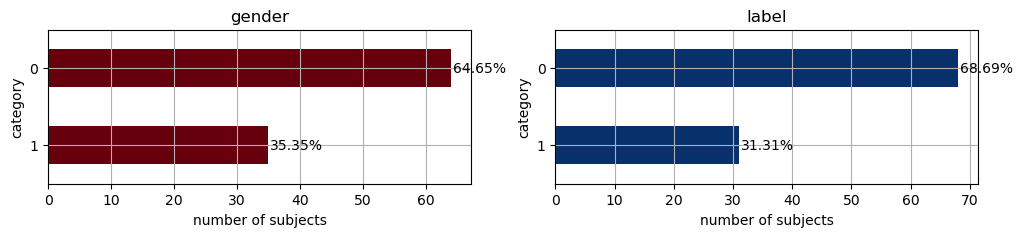

In [8]:
# Reference: https://towardsdatascience.com/machine-learning-with-python-classification-complete-tutorial-d2c99dc524ec

fig, axes = plt.subplots(1, 2, figsize=(12, 2))

df_raw['gender'].value_counts().sort_values().plot(kind="barh", ax=axes[0], grid=True, colormap='Reds_r', title='gender')
df_raw['_Label'].value_counts().sort_values().plot(kind="barh", ax=axes[1], grid=True, colormap='Blues_r', title='label')

axes[0].set_xlabel('number of subjects')
axes[1].set_xlabel('number of subjects')
axes[0].set_ylabel('category')
axes[1].set_ylabel('category')

categories = []
for i in axes[0].patches:
    categories.append(i.get_width())
n_Subjects = sum(categories)

for category in axes[0].patches:
    axes[0].text(category.get_width()+.3, category.get_y()+.20, str(round((category.get_width()/n_Subjects)*100, 2))+'%', fontsize=10, color='black')
for category in axes[1].patches:
    axes[1].text(category.get_width()+.3, category.get_y()+.20, str(round((category.get_width()/n_Subjects)*100, 2))+'%', fontsize=10, color='black')

plt.show()

In [9]:
df_raw['_Label'].value_counts()

0    68
1    31
Name: _Label, dtype: int64

# Majority Voting

## Read [Label] CSV file

In [13]:
# df_walk = pd.read_csv('result_walkingSubtask_cut.csv')
# df_sitstand = pd.read_csv('result_sit&standSubtask_downsampling.csv')
# df_eye = pd.read_csv('result_eyeSubtask_eyebrowOnly.csv')
# df_turn = pd.read_csv('result_turningSubtask.csv')
# df_eye = pd.read_csv('result_eyeSubtask_PCA.csv')

# df_walk = pd.read_csv(f'Training_Result/Walking_Subtask_val.csv') ### [update] 2023/08/21
# df_sitstand = pd.read_csv(f'Training_Result/SitStand_Subtask_val.csv') ### [update] 2023/08/21
# df_turn = pd.read_csv(f'Training_Result/Turning_Subtask.csv') ### [update] 2023/08/21
# df_eye = pd.read_csv('Training_Result/Facial_Subtask_val.csv') ### [update] 2023/08/31


# df_walk = pd.read_csv(f'Training_Result/Walking_Subtask_val_threshold.csv') ### [update] 2023/09/21

# # df_sitstand = pd.read_csv(f'Training_Result/SitStand_Subtask_val_threshold.csv') ### [update] 2023/09/21
# df_sitstand = pd.read_csv(f'Training_Result/SitStand_Subtask_val_threshold_method1.csv') ### [update] 2023/10/18
# # df_sitstand = pd.read_csv(f'Training_Result/SitStand_Subtask_val_threshold_method2.csv') ### [update] 2023/10/18

# df_turn = pd.read_csv(f'Training_Result/Turning_Subtask_val_threshold.csv') ### [update] 2023/09/21
# df_eye = pd.read_csv('Training_Result/Facial_Subtask_val_threshold.csv') ### [update] 2023/09/21


### [update] 20240516
df_walk = pd.read_csv("Training_Result_CNN2d_20240516/Walking_FS_weighted.csv")
df_sitstand = pd.read_csv("Training_Result_CNN2d_20240516/SitStand_combined.csv")
df_turn = pd.read_csv("Training_Result_CNN2d_20240516/Turning.csv")
df_facial = pd.read_csv("Training_Result_CNN2d_20240516/Facial_FS_weighted.csv")

In [14]:
walk_subtask_dict = {}
sitstand_subtask_dict = {}
eye_subtask_dict = {}
turn_subtask_dict = {}

def create_subtask_dictionary(data):
    tmp_dict = {}
    for i in range(data.shape[0]):
        pid = data.loc[i, 'pid']
        prediction = data.loc[i, 'prediction']
        actual = data.loc[i, 'actual']
        
        tmp_dict[pid] = {}
        tmp_dict[pid]['prediction'] = prediction
        tmp_dict[pid]['actual'] = actual
    return tmp_dict


walk_subtask_dict = create_subtask_dictionary(df_walk)
sitstand_subtask_dict = create_subtask_dictionary(df_sitstand)
eye_subtask_dict = create_subtask_dictionary(df_facial)
turn_subtask_dict = create_subtask_dictionary(df_turn)

print(f'# of pid in [Walk Subtask]: {len(walk_subtask_dict)}')
print(f'# of pid in [Sit&Stand Subtask]: {len(sitstand_subtask_dict)}')
print(f'# of pid in [Eye Subtask]: {len(eye_subtask_dict)}')
print(f'# of pid in [Turning Subtask]: {len(turn_subtask_dict)}')

# of pid in [Walk Subtask]: 88
# of pid in [Sit&Stand Subtask]: 88
# of pid in [Eye Subtask]: 96
# of pid in [Turning Subtask]: 83


## Get all subjects id

In [15]:
all_pid_list = []

def get_all_pid(walk, sitstand, eye, turn):
    tmp_list = []
    
    for i in range(walk.shape[0]):
        pid = walk.loc[i, 'pid']
        tmp_list.append(pid)
    for i in range(sitstand.shape[0]):
        pid = sitstand.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
            print(f'[add pid: Sit&Stand] pid: {pid}')
    for i in range(eye.shape[0]):
        pid = eye.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
            print(f'[add pid: Eye] pid: {pid}')
    for i in range(turn.shape[0]):
        pid = turn.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
            print(f'[add pid: Turning] pid: {pid}')
    
    return tmp_list


all_pid_list = get_all_pid(df_walk, df_sitstand, df_facial, df_turn)

[add pid: Eye] pid: 8
[add pid: Eye] pid: 14
[add pid: Eye] pid: 15
[add pid: Eye] pid: 23
[add pid: Eye] pid: 42
[add pid: Eye] pid: 47
[add pid: Eye] pid: 50
[add pid: Eye] pid: 53
[add pid: Eye] pid: 54
[add pid: Eye] pid: 55
[add pid: Eye] pid: 56


In [16]:
print(f'# of valid pid: {len(all_pid_list)}\n')
all_pid_list.sort()
print(all_pid_list)

# of valid pid: 99

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


## Analyze

In [17]:
all_pid_label_dict = {}

def combine_three_label(pidList, walk, sitstand, eye, turn):
    tmp_dict = {}
    
    for pid in pidList:
        tmp_dict[pid] = {}
        
        ### get walking subtask label
        row_idx_list = walk.index[walk['pid']==pid].tolist()
        if len(row_idx_list)==0:
            tmp_dict[pid]["_Walk"] = 'x'
        elif len(row_idx_list)==1:
            row_idx = row_idx_list[0]
            prediction = walk.loc[row_idx, 'prediction']
            tmp_dict[pid]["_Walk"] = prediction
        else:
            print(f'[Notice] Something wrong.')

        ### get sitstand subtask label
        row_idx_list = sitstand.index[sitstand['pid']==pid].tolist()
        if len(row_idx_list)==0:
            tmp_dict[pid]["_Sit&Stand"] = 'x'
        elif len(row_idx_list)==1:
            row_idx = row_idx_list[0]
            prediction = sitstand.loc[row_idx, 'prediction']
            tmp_dict[pid]["_Sit&Stand"] = prediction
        else:
            print(f'[Notice] Something wrong.')
            
        ### get eye subtask label
        row_idx_list = eye.index[eye['pid']==pid].tolist()
        if len(row_idx_list)==0:
            tmp_dict[pid]["_Eye"] = 'x'
        elif len(row_idx_list)==1:
            row_idx = row_idx_list[0]
            prediction = eye.loc[row_idx, 'prediction']
            tmp_dict[pid]["_Eye"] = prediction
        else:
            print(f'[Notice] Something wrong.')
            
        ### get turning subtask label
        row_idx_list = turn.index[turn['pid']==pid].tolist()
        if len(row_idx_list)==0:
            tmp_dict[pid]["_Turn"] = 'x'
        elif len(row_idx_list)==1:
            row_idx = row_idx_list[0]
            prediction = turn.loc[row_idx, 'prediction']
            tmp_dict[pid]["_Turn"] = prediction
        else:
            print(f'[Notice] Something wrong.')

    return tmp_dict

    
def add_ground_truth_label(pidList, walk, sitstand, eye, turn, all_dict):    
    for pid in pidList:
        if pid in walk_subtask_dict:
            actual = walk_subtask_dict[pid]['actual']
            all_dict[pid]['actual'] = actual
        elif pid in sitstand_subtask_dict:
            actual = sitstand_subtask_dict[pid]['actual']
            all_dict[pid]['actual'] = actual
        elif pid in eye_subtask_dict:
            actual = eye_subtask_dict[pid]['actual']
            all_dict[pid]['actual'] = actual
        elif pid in turn_subtask_dict:
            actual = turn_subtask_dict[pid]['actual']
            all_dict[pid]['actual'] = actual
        else:
            print(f'[Notice] pid NOT in any dict.')
    return all_dict
    
    
all_pid_label_dict = combine_three_label(all_pid_list, df_walk, df_sitstand, df_facial, df_turn)
all_pid_label_dict = add_ground_truth_label(all_pid_list, df_walk, df_sitstand, df_facial, df_turn, all_pid_label_dict)

In [18]:
print(f'# of valid pid-label pair: {len(all_pid_label_dict)}\n')

all_pid_label_dict

# of valid pid-label pair: 99



{1: {'_Walk': 1, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 0, 'actual': 0},
 2: {'_Walk': 0, '_Sit&Stand': 0, '_Eye': 1, '_Turn': 0, 'actual': 0},
 3: {'_Walk': 0, '_Sit&Stand': 0, '_Eye': 0, '_Turn': 0, 'actual': 0},
 4: {'_Walk': 1, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 'x', 'actual': 1},
 5: {'_Walk': 0, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 0, 'actual': 0},
 6: {'_Walk': 1, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 0, 'actual': 0},
 7: {'_Walk': 0, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 'x', 'actual': 0},
 8: {'_Walk': 'x', '_Sit&Stand': 'x', '_Eye': 1, '_Turn': 'x', 'actual': 0},
 9: {'_Walk': 1, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 'x', 'actual': 1},
 10: {'_Walk': 1, '_Sit&Stand': 0, '_Eye': 0, '_Turn': 0, 'actual': 1},
 11: {'_Walk': 1, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 1, 'actual': 1},
 12: {'_Walk': 1, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 0, 'actual': 1},
 13: {'_Walk': 1, '_Sit&Stand': 0, '_Eye': 0, '_Turn': 0, 'actual': 0},
 14: {'_Walk': 'x', '_Sit&Stand': 'x', '_Eye': 0, '_Turn': 'x

In [19]:
all_pid_label_dict_sorted = {}

keys = list(all_pid_label_dict.keys())
keys.sort()

all_pid_label_dict_sorted = {i: all_pid_label_dict[i] for i in keys}

print(f'# of valid pid-label pair: {len(all_pid_label_dict_sorted)}\n')

all_pid_label_dict_sorted

# of valid pid-label pair: 99



{1: {'_Walk': 1, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 0, 'actual': 0},
 2: {'_Walk': 0, '_Sit&Stand': 0, '_Eye': 1, '_Turn': 0, 'actual': 0},
 3: {'_Walk': 0, '_Sit&Stand': 0, '_Eye': 0, '_Turn': 0, 'actual': 0},
 4: {'_Walk': 1, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 'x', 'actual': 1},
 5: {'_Walk': 0, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 0, 'actual': 0},
 6: {'_Walk': 1, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 0, 'actual': 0},
 7: {'_Walk': 0, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 'x', 'actual': 0},
 8: {'_Walk': 'x', '_Sit&Stand': 'x', '_Eye': 1, '_Turn': 'x', 'actual': 0},
 9: {'_Walk': 1, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 'x', 'actual': 1},
 10: {'_Walk': 1, '_Sit&Stand': 0, '_Eye': 0, '_Turn': 0, 'actual': 1},
 11: {'_Walk': 1, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 1, 'actual': 1},
 12: {'_Walk': 1, '_Sit&Stand': 1, '_Eye': 0, '_Turn': 0, 'actual': 1},
 13: {'_Walk': 1, '_Sit&Stand': 0, '_Eye': 0, '_Turn': 0, 'actual': 0},
 14: {'_Walk': 'x', '_Sit&Stand': 'x', '_Eye': 0, '_Turn': 'x

In [20]:
def check_three_label(label1, label2, label3, label4):
    tmp_predict = 0
    if label1=="x":
        cnt = 0
        if label2==1: cnt += 1
        if label3==1: cnt += 1
        if label4==1: cnt += 1
        if cnt>=2: tmp_predict = 1
        else: tmp_predict = 0
    if label2=="x":
        cnt = 0
        if label1==1: cnt += 1
        if label3==1: cnt += 1
        if label4==1: cnt += 1
        if cnt>=2: tmp_predict = 1
        else: tmp_predict = 0
    if label3=="x":
        cnt = 0
        if label1==1: cnt += 1
        if label2==1: cnt += 1
        if label4==1: cnt += 1
        if cnt>=2: tmp_predict = 1
        else: tmp_predict = 0
    if label4=="x":
        cnt = 0
        if label1==1: cnt += 1
        if label2==1: cnt += 1
        if label3==1: cnt += 1
        if cnt>=2: tmp_predict = 1
        else: tmp_predict = 0
    return tmp_predict

def check_two_label(label1, label2, label3, label4):
    tmp_predict = 0
    if label1=="x" and label2=="x":
        if label3==1 or label4==1: tmp_predict = 1
        else: tmp_predict = 0
    if label1=="x" and label3=="x":
        if label2==1 or label4==1: tmp_predict = 1
        else: tmp_predict = 0
    if label1=="x" and label4=="x":
        if label2==1 or label3==1: tmp_predict = 1
        else: tmp_predict = 0
    if label2=="x" and label3=="x":
        if label1==1 or label4==1: tmp_predict = 1
        else: tmp_predict = 0
    if label2=="x" and label4=="x":
        if label1==1 or label3==1: tmp_predict = 1
        else: tmp_predict = 0
    if label3=="x" and label4=="x":
        if label1==1 or label2==1: tmp_predict = 1
        else: tmp_predict = 0
    return tmp_predict


def check_one_label(label1, label2, label3, label4):
    tmp_predict = 0
    if label1=="x" and label2=="x" and label3=="x":
        tmp_predict = label4
    if label1=="x" and label2=="x" and label4=="x":
        tmp_predict = label3
    if label1=="x" and label3=="x" and label4=="x":
        tmp_predict = label2
    if label2=="x" and label3=="x" and label4=="x":
        tmp_predict = label1
    return tmp_predict

In [21]:
final_prediction_result_dict = {}
actual_label_List = []
predict_label_List = []


def calculate_performance(data_dict):
    tmp_dict = {}
    n_correction = 0
    n_total = 0
    
    for key in data_dict:
        pid = key
        walk = data_dict[key]['_Walk']
        sit = data_dict[key]['_Sit&Stand']
        eye = data_dict[key]['_Eye']
        turn = data_dict[key]['_Turn']
        actual = data_dict[key]['actual']
        
        if walk!="x": walk = int(walk)
        if sit!="x": sit = int(sit)
        if eye!="x": eye = int(eye)
        if turn!="x": turn = int(turn)
        
        flag_valid = True
        if walk=="x" or sit=="x" or eye=="x" or turn=="x":
            n_x = 0
            if walk=="x": n_x += 1
            if sit=="x": n_x += 1
            if eye=="x": n_x += 1
            if turn=="x": n_x += 1
            
            if n_x==1:
                predict = check_three_label(walk, sit, eye, turn)
            elif n_x==2:
                predict = check_two_label(walk, sit, eye, turn)
            elif n_x==3:
                predict = check_one_label(walk, sit, eye, turn)
            elif n_x==4:
                flag_valid = False
                print(f'[Info] pid: {pid}, No label can be counted.')
            else:
                flag_valid = False
                print(f'[Info] pid: {pid}, Something wrong.')   
        else:
            cnt = 0
            if walk==1: cnt += 1
            if sit==1: cnt += 1
            if eye==1: cnt += 1
            if cnt>=2: 
                predict = 1
            else: 
                predict = 0
        
        if actual==predict: n_correction += 1
        
        if flag_valid == True:
            tmp_dict[pid] = {}
            tmp_dict[pid]["walk"] = walk
            tmp_dict[pid]["sit"] = sit
            tmp_dict[pid]["eye"] = eye
            tmp_dict[pid]["turn"] = turn
            tmp_dict[pid]["predict"] = predict
            tmp_dict[pid]["actual"] = actual
            
            actual_label_List.append(actual)
            predict_label_List.append(predict)
        if flag_valid == False:
            print(f'[pid {pid}] Not valid pid.')
            
    n_total = len(tmp_dict)
    return tmp_dict, n_correction, n_total


final_prediction_result_dict, n_CORRECT, n_TOTAL = calculate_performance(all_pid_label_dict_sorted)

In [22]:
final_prediction_result_dict

{1: {'walk': 1, 'sit': 1, 'eye': 0, 'turn': 0, 'predict': 1, 'actual': 0},
 2: {'walk': 0, 'sit': 0, 'eye': 1, 'turn': 0, 'predict': 0, 'actual': 0},
 3: {'walk': 0, 'sit': 0, 'eye': 0, 'turn': 0, 'predict': 0, 'actual': 0},
 4: {'walk': 1, 'sit': 1, 'eye': 0, 'turn': 'x', 'predict': 1, 'actual': 1},
 5: {'walk': 0, 'sit': 1, 'eye': 0, 'turn': 0, 'predict': 0, 'actual': 0},
 6: {'walk': 1, 'sit': 1, 'eye': 0, 'turn': 0, 'predict': 1, 'actual': 0},
 7: {'walk': 0, 'sit': 1, 'eye': 0, 'turn': 'x', 'predict': 0, 'actual': 0},
 8: {'walk': 'x',
  'sit': 'x',
  'eye': 1,
  'turn': 'x',
  'predict': 1,
  'actual': 0},
 9: {'walk': 1, 'sit': 1, 'eye': 0, 'turn': 'x', 'predict': 1, 'actual': 1},
 10: {'walk': 1, 'sit': 0, 'eye': 0, 'turn': 0, 'predict': 0, 'actual': 1},
 11: {'walk': 1, 'sit': 1, 'eye': 0, 'turn': 1, 'predict': 1, 'actual': 1},
 12: {'walk': 1, 'sit': 1, 'eye': 0, 'turn': 0, 'predict': 1, 'actual': 1},
 13: {'walk': 1, 'sit': 0, 'eye': 0, 'turn': 0, 'predict': 0, 'actual': 0},

-Performace: 89/99, 89.9%

# of subjects in [actual_label_List]: 99
# of subjects in [predict_label_List]: 99

==============  Classification Report  ==============
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        68
           1       0.84      0.84      0.84        31

    accuracy                           0.90        99
   macro avg       0.88      0.88      0.88        99
weighted avg       0.90      0.90      0.90        99

==================  Performance  ====================
0) TN: 63, FP: 5, FN: 5, TP: 26
1) Accuracy: 89.9%
2) Sensitivity (Recall): 83.87%
3) Specificity: 92.65%
4) G-Means: 88.15%
5) Precision: 83.87%
6) F1-Score: 0.84
7) F2-Measure: 0.84



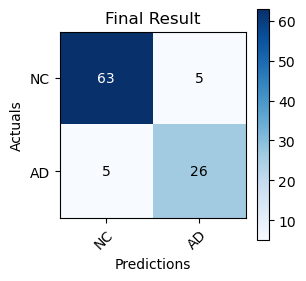

In [23]:
print(f'-Performace: {n_CORRECT}/{n_TOTAL}, {round(n_CORRECT/n_TOTAL*100, 2)}%\n')


from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix

def show_confusion_matrix():
    print(f'# of subjects in [actual_label_List]: {len(actual_label_List)}')
    print(f'# of subjects in [predict_label_List]: {len(predict_label_List)}\n')
    
    actual_label_array = np.array(actual_label_List)
    predict_label_array = np.array(predict_label_List)

    ### F1-Score
    print(f'==============  Classification Report  ==============')
    print(classification_report(actual_label_array, predict_label_array))

    ### Confusion Matrix
    matrix = confusion_matrix(actual_label_array, predict_label_array)
    TN, FP, FN, TP = matrix.ravel()

    value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    value_sensitivity = round(TP/(TP+FN), 4)
    value_specificity = round(TN/(TN+FP), 4)
    value_gmeans = round(np.sqrt(value_sensitivity*value_specificity), 4)
    value_precision = round(TP/(TP+FP), 4)
    value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
    value_f2_measure = round(5*value_precision*value_sensitivity / (4*value_precision+value_sensitivity), 2)

    print(f'==================  Performance  ====================')
    print(f'0) TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    print(f'1) Accuracy: {round(value_accuracy*100, 2)}%')
    print(f'2) Sensitivity (Recall): {round(value_sensitivity*100, 2)}%')
    print(f'3) Specificity: {round(value_specificity*100, 2)}%')
    print(f'4) G-Means: {round(value_gmeans*100, 2)}%')
    print(f'5) Precision: {round(value_precision*100, 2)}%')
    print(f'6) F1-Score: {value_f1_score}')
    print(f'7) F2-Measure: {value_f2_measure}\n')
    

    classList = ['NC', 'AD']
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(3, 3), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Final Result', fontsize=12)
    plt.show()

    
    
show_confusion_matrix()

## 4 Subtasks

In [18]:
from matplotlib_venn import venn3

def plot_venn_diagram(data_dict):
    one_walk = set()
    one_sitstand = set()
    one_eye = set()
    one_turn = set()
    
    two_walk_sitstand = set()
    two_walk_eye = set()
    two_walk_turn = set()
    two_sitstand_eye = set()
    two_sitstand_turn = set()
    two_eye_turn = set()
    
    three_walk_sitstand_eye = set()
    three_walk_sitstand_turn = set()
    three_walk_eye_turn = set()
    three_sitstand_eye_turn = set()
    
    four_walk_sitstand_eye_turn = set()
    
    n_wrong_prediction = 0 
    n_correct_prediction = 0
    
    for key in data_dict:
        pid = key
        walk = data_dict[key]['walk']
        sit = data_dict[key]['sit']
        eye = data_dict[key]['eye']
        turn = data_dict[key]['turn']
        prediction = data_dict[key]['predict']
        actual = data_dict[key]['actual']
        
        if prediction==actual:
            n_correct_prediction += 1
            if walk==actual and sit!=actual and eye!=actual and turn!=actual: one_walk.add(pid)
            elif walk!=actual and sit==actual and eye!=actual and turn!=actual: one_sitstand.add(pid)
            elif walk!=actual and sit!=actual and eye==actual and turn!=actual: one_eye.add(pid)
            elif walk!=actual and sit!=actual and eye!=actual and turn==actual: one_turn.add(pid)
            elif walk==actual and sit==actual and eye!=actual and turn!=actual: two_walk_sitstand.add(pid)
            elif walk==actual and sit!=actual and eye==actual and turn!=actual: two_walk_eye.add(pid)
            elif walk==actual and sit!=actual and eye!=actual and turn==actual: two_walk_turn.add(pid)
            elif walk!=actual and sit==actual and eye==actual and turn!=actual: two_sitstand_eye.add(pid)
            elif walk!=actual and sit==actual and eye!=actual and turn==actual: two_sitstand_turn.add(pid)
            elif walk!=actual and sit!=actual and eye==actual and turn==actual: two_eye_turn.add(pid)
            elif walk==actual and sit==actual and eye==actual and turn!=actual: three_walk_sitstand_eye.add(pid)
            elif walk==actual and sit==actual and eye!=actual and turn==actual: three_walk_sitstand_turn.add(pid)
            elif walk==actual and sit!=actual and eye==actual and turn==actual: three_walk_eye_turn.add(pid)
            elif walk!=actual and sit==actual and eye==actual and turn==actual: three_sitstand_eye_turn.add(pid)
            elif walk==actual and sit==actual and eye==actual and turn==actual: four_walk_sitstand_eye_turn.add(pid)
            else:
                print(f'actual: {actual}, walk: {walk}, sit: {sit}, eye: {eye}, turn: {turn}')
                print(f'[Notice] check the if condition.')
        else:
            n_wrong_prediction += 1
    
    print(f'(1) n_correct_prediction: {n_correct_prediction}')
    
    print(f'      -one_walk: {len(one_walk)}')
    print(f'      -one_sitstand: {len(one_sitstand)}')
    print(f'      -one_eye: {len(one_eye)}')
    print(f'      -one_turn: {len(one_turn)}')
    
    print(f'      -two_walk_sitstand: {len(two_walk_sitstand)}')
    print(f'      -two_walk_eye: {len(two_walk_eye)}')
    print(f'      -two_walk_turn: {len(two_walk_turn)}')
    print(f'      -two_sitstand_eye: {len(two_sitstand_eye)}')
    print(f'      -two_sitstand_turn: {len(two_sitstand_turn)}')
    print(f'      -two_eye_turn: {len(two_eye_turn)}')
    
    print(f'      -three_walk_sitstand_eye: {len(three_walk_sitstand_eye)}')
    print(f'      -three_walk_sitstand_turn: {len(three_walk_sitstand_turn)}')
    print(f'      -three_walk_eye_turn: {len(three_walk_eye_turn)}')
    print(f'      -three_sitstand_eye_turn: {len(three_sitstand_eye_turn)}')
    
    print(f'      -four_walk_sitstand_eye_turn: {len(four_walk_sitstand_eye_turn)}')

    print(f'(2) n_wrong_prediction: {n_wrong_prediction}')
    
    # v = venn3(subsets=(len(one_walk), len(one_sitstand), len(two_walk_sitstand), len(one_eye), len(two_walk_eye), len(two_sitstand_eye), len(three_walk_sitstand_eye)), set_labels=('Walk', 'Sit&Stand', 'Eye'))
    
plot_venn_diagram(final_prediction_result_dict)

(1) n_correct_prediction: 66
      -one_walk: 0
      -one_sitstand: 0
      -one_eye: 9
      -one_turn: 0
      -two_walk_sitstand: 5
      -two_walk_eye: 3
      -two_walk_turn: 0
      -two_sitstand_eye: 2
      -two_sitstand_turn: 0
      -two_eye_turn: 0
      -three_walk_sitstand_eye: 4
      -three_walk_sitstand_turn: 8
      -three_walk_eye_turn: 9
      -three_sitstand_eye_turn: 8
      -four_walk_sitstand_eye_turn: 18
(2) n_wrong_prediction: 33


## 3 Subtasks

(1) n_correct_prediction: 74
      -one_walk: 2
      -one_sitstand: 3
      -one_eye: 11
      -two_walk_sitstand: 14
      -two_walk_eye: 9
      -two_sitstand_eye: 17
      -three_walk_sitstand_eye: 18
(2) n_wrong_prediction: 25


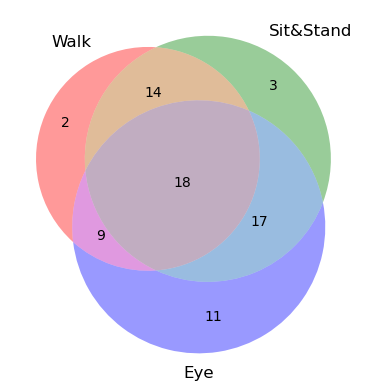

In [18]:
from matplotlib_venn import venn3

def plot_venn_diagram(data_dict):
    one_walk = set()
    one_sitstand = set()
    one_eye = set()
    two_walk_sitstand = set()
    two_walk_eye = set()
    two_sitstand_eye = set()
    three_walk_sitstand_eye = set()
    
    n_wrong_prediction = 0 
    n_correct_prediction = 0
    
    for key in data_dict:
        pid = key
        walk = data_dict[key]['walk']
        sit = data_dict[key]['sit']
        eye = data_dict[key]['eye']
        prediction = data_dict[key]['predict']
        actual = data_dict[key]['actual']
        
        if prediction==actual:
            n_correct_prediction += 1
            if walk==actual and sit!=actual and eye!=actual: one_walk.add(pid)
            elif walk!=actual and sit==actual and eye!=actual: one_sitstand.add(pid)
            elif walk!=actual and sit!=actual and eye==actual: one_eye.add(pid)
            elif walk==actual and sit==actual and eye!=actual: two_walk_sitstand.add(pid)
            elif walk==actual and sit!=actual and eye==actual: two_walk_eye.add(pid)
            elif walk!=actual and sit==actual and eye==actual: two_sitstand_eye.add(pid)
            elif walk==actual and sit==actual and eye==actual: three_walk_sitstand_eye.add(pid)
            else:
                print(f'[Notice] check the if condition.')
        else:
            n_wrong_prediction += 1
    
    print(f'(1) n_correct_prediction: {n_correct_prediction}')
    print(f'      -one_walk: {len(one_walk)}')
    print(f'      -one_sitstand: {len(one_sitstand)}')
    print(f'      -one_eye: {len(one_eye)}')
    print(f'      -two_walk_sitstand: {len(two_walk_sitstand)}')
    print(f'      -two_walk_eye: {len(two_walk_eye)}')
    print(f'      -two_sitstand_eye: {len(two_sitstand_eye)}')
    print(f'      -three_walk_sitstand_eye: {len(three_walk_sitstand_eye)}')
    print(f'(2) n_wrong_prediction: {n_wrong_prediction}')
    
    v = venn3(subsets=(len(one_walk), len(one_sitstand), len(two_walk_sitstand), len(one_eye), len(two_walk_eye), len(two_sitstand_eye), len(three_walk_sitstand_eye)), set_labels=('Walk', 'Sit&Stand', 'Eye'))
    
plot_venn_diagram(final_prediction_result_dict)

# Weighted Voting

## Read CSV file

In [10]:
# # df_walk = pd.read_csv(f'Training_Result/Walking_Subtask_val_threshold.csv') ### [update] 2023/09/21
# # df_walk = pd.read_csv('Training_Result/Walking_Subtask_val_threshold_240306.csv') ### [update] 2024/03/06
# # df_walk = pd.read_csv('Training_Result_CNN2d_grayscale/Walking_Subtask_Weighted.csv') ### [update] 2024/03/28
# # df_walk = pd.read_csv('Training_Result_CNN2d_20240328/Walking_Subtask_Model2_FS_Dynamic_Weighted.csv') ### [update] 2024/03/28
# df_walk = pd.read_csv('Training_Result_CNN2d_20240409/Walking_Subtask_Model2_FS_Dynamic_Weighted.csv')


# # df_sitstand = pd.read_csv(f'Training_Result/SitStand_Subtask_val_threshold.csv') ### [update] 2023/09/21
# # df_sitstand = pd.read_csv('Training_Result/SitStand_Subtask_val_threshold_method1.csv') ### [update] 2023/10/18
# # df_sitstand = pd.read_csv('Training_Result/SitStand_Subtask_val_threshold_method2.csv') ### [update] 2023/10/18
# df_sitstand = pd.read_csv('Training_Result_CNN2d_grayscale/SitStand_Subtask.csv') ### [update] 2024/03/28

# df_turn = pd.read_csv('Training_Result/Turning_Subtask_val_threshold.csv') ### [update] 2023/09/21

# # df_facial = pd.read_csv('Training_Result/Facial_Subtask_val_threshold.csv') ### [update] 2023/09/21
# # df_facial = pd.read_csv('Training_Result/Facial_Subtask_val_threshold_0227.csv') ### [update] 2024/02/27
# # df_facial = pd.read_csv('Training_Result_CNN2d_grayscale/Facial_Subtask_Weighted.csv') ### [update] 2024/03/28
# # df_facial = pd.read_csv('Training_Result_CNN2d_20240328/Facial_Subtask_Model2_FS_Dynamic_Weighted.csv') ### [update] 2024/03/28
# df_facial = pd.read_csv('Training_Result_CNN2d_20240409/Facial_Subtask_Model3_FS_Dynamic_Weighted.csv')


### [update] 20240516
df_walk = pd.read_csv("Training_Result_CNN2d_20240516/Walking_FS_weighted.csv")
df_sitstand = pd.read_csv("Training_Result_CNN2d_20240516/SitStand_combined.csv")
df_turn = pd.read_csv("Training_Result_CNN2d_20240516/Turning.csv")
df_facial = pd.read_csv("Training_Result_CNN2d_20240516/Facial_FS_weighted.csv")

In [11]:
walk_subtask_dict = {}
sitstand_subtask_dict = {}
facial_subtask_dict = {}
turn_subtask_dict = {}

def create_walking_sitstand_facial_subtask_dictionary(data):
    tmp_dict = {}
    for i in range(data.shape[0]):
        pid = data.loc[i, 'pid']
        p_class1 = data.loc[i, 'avgProb'] ### probability for class 1 (AD)
        prediction = data.loc[i, 'prediction']
        actual = data.loc[i, 'actual']
        
        p_class0 = 1 - p_class1 ### probability for class 0 (NC)
        
        tmp_dict[pid] = {}
        tmp_dict[pid]['prob_class0'] = p_class0
        tmp_dict[pid]['prob_class1'] = p_class1
        tmp_dict[pid]['prediction'] = prediction
        tmp_dict[pid]['actual'] = actual
    return tmp_dict


def create_turning_subtask_dictionary(data):
    tmp_dict = {}
    for i in range(data.shape[0]):
        pid = data.loc[i, 'pid']
        p_class0 = data.loc[i, 'prob_NC']
        p_class1 = data.loc[i, 'prob_AD']
        prediction = data.loc[i, 'prediction']
        actual = data.loc[i, 'actual']
        
        tmp_dict[pid] = {}
        tmp_dict[pid]['prob_class0'] = p_class0
        tmp_dict[pid]['prob_class1'] = p_class1
        tmp_dict[pid]['prediction'] = prediction
        tmp_dict[pid]['actual'] = actual
    return tmp_dict


walk_subtask_dict = create_walking_sitstand_facial_subtask_dictionary(df_walk)
sitstand_subtask_dict = create_walking_sitstand_facial_subtask_dictionary(df_sitstand)
facial_subtask_dict = create_walking_sitstand_facial_subtask_dictionary(df_facial)

turn_subtask_dict = create_turning_subtask_dictionary(df_turn)

In [12]:
print(f'# of pid in [Walk Subtask]: {len(walk_subtask_dict)} subjects.')
print(f'# of pid in [Sit&Stand Subtask]: {len(sitstand_subtask_dict)} subjects.')
print(f'# of pid in [Facial Subtask]: {len(facial_subtask_dict)} subjects.')
print(f'# of pid in [Turning Subtask]: {len(turn_subtask_dict)} subjects.')

# of pid in [Walk Subtask]: 88 subjects.
# of pid in [Sit&Stand Subtask]: 88 subjects.
# of pid in [Facial Subtask]: 96 subjects.
# of pid in [Turning Subtask]: 83 subjects.


## Get all subjects id

In [13]:
all_pid_list = []
all_pid_list_based = []

def get_all_pid(walk, sitstand, facial, turn):
    tmp_list = []
    
    for i in range(walk.shape[0]):
        pid = walk.loc[i, 'pid']
        tmp_list.append(pid)
    for i in range(sitstand.shape[0]):
        pid = sitstand.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
            print(f'[add pid: Sit&Stand] pid: {pid}')
    for i in range(facial.shape[0]):
        pid = facial.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
            print(f'[add pid: Facial] pid: {pid}')
    for i in range(turn.shape[0]):
        pid = turn.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
            print(f'[add pid: Turning] pid: {pid}')
    return tmp_list

def get_all_pid_based(walk, sitstand, facial, turn, pidList):
    tmp_list = []
    pid_walk, pid_sitstand, pid_turn, pid_facial = [], [], [], []
    
    for i in range(walk.shape[0]): pid_walk.append(walk.loc[i, 'pid'])
    for i in range(sitstand.shape[0]): pid_sitstand.append(sitstand.loc[i, 'pid'])
    for i in range(turn.shape[0]): pid_turn.append(turn.loc[i, 'pid'])
    for i in range(facial.shape[0]): pid_facial.append(facial.loc[i, 'pid'])

    for pid in pidList:
        if (pid in pid_walk) and (pid in pid_sitstand) and (pid in pid_turn) and (pid in pid_facial):
            tmp_list.append(pid)
    return tmp_list, pid_walk, pid_sitstand, pid_turn, pid_facial



all_pid_list = get_all_pid(df_walk, df_sitstand, df_facial, df_turn)
all_pid_list_based, walk_pid_list, sitstand_pid_list, turn_pid_list, facial_pid_list = get_all_pid_based(df_walk, df_sitstand, df_facial, df_turn, all_pid_list)

print(f'\n# of valid pid: {len(all_pid_list)} subjects.')
print(all_pid_list)
print(f'\n# of valid pid: {len(all_pid_list_based)} subjects.')
print(all_pid_list_based)

print(f'\n# of subjects in 【Walking】 Subtask: {len(walk_pid_list)} subjects.')
print(walk_pid_list)
print(f'\n# of subjects in 【SitStand】 Subtask: {len(sitstand_pid_list)} subjects.')
print(sitstand_pid_list)
print(f'\n# of subjects in 【Turning】 Subtask: {len(turn_pid_list)} subjects.')
print(turn_pid_list)
print(f'\n# of subjects in 【Facial】 Subtask: {len(facial_pid_list)} subjects.')
print(facial_pid_list)

[add pid: Facial] pid: 8
[add pid: Facial] pid: 14
[add pid: Facial] pid: 15
[add pid: Facial] pid: 23
[add pid: Facial] pid: 42
[add pid: Facial] pid: 47
[add pid: Facial] pid: 50
[add pid: Facial] pid: 53
[add pid: Facial] pid: 54
[add pid: Facial] pid: 55
[add pid: Facial] pid: 56

# of valid pid: 99 subjects.
[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 48, 49, 51, 52, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 8, 14, 15, 23, 42, 47, 50, 53, 54, 55, 56]

# of valid pid: 81 subjects.
[1, 2, 3, 5, 6, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 48, 49, 51, 52, 57, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87

## Get F1-Score for each subtask

In [14]:
f1_score_walk = 0.88
f1_score_sitstand = 0.58
f1_score_turn = 0.71
f1_score_facial = 0.64

## Subtask Importance (for each pid)

In [15]:
threshold_walk_5f = [0.4, 0.51, 0.4, 0.4, 0.43] ### 1_GaitAnalysis_ver3_YOLO7_Training/Walking_Model2_0409/FS_Dynamic/Save_CNN2d_Parameters/threshold_5f.csv
threshold_sitstand_5f = [0.4, 0.4, 0.4178, 0.4, 0.4]
threshold_turn_5f = [0.44, 0.4, 0.4, 0.45, 0.4]
threshold_facial_5f = [0.43, 0.4, 0.43, 0.46, 0.43] ### 2_EyeTrackingAnalysis/Facial_Model3_0409/FS_Dynamic/Save_CNN2d_Parameters/threshold_5fold.csv

In [16]:
testPid_walk_5f, testPid_sitstand_5f, testPid_turn_5f, testPid_facial_5f = [], [], [], []

def get_subtask_5f_subjectId():
    walk_test_csv = '../5_Gait_and_Eye/Training_Fix_5Fold/walk_test_5fold.csv'
    sitstand_test_csv = '../5_Gait_and_Eye/Training_Fix_5Fold/sitstand_test_5fold.csv'
    turn_test_csv = '../5_Gait_and_Eye/Training_Fix_5Fold/turn_test_5fold.csv'
    facial_test_csv = '../5_Gait_and_Eye/Training_Fix_5Fold/eyes_test_5fold.csv'
    
    tmp_walk_testID_5f, tmp_sitstand_testID_5f, tmp_turn_testID_5f, tmp_facial_testID_5f = [], [], [], []
    
    walk_file = open(walk_test_csv, "r")
    tmp_walk_testID_5f = list(csv.reader(walk_file, delimiter=","))
    walk_file.close()

    sitstand_file = open(sitstand_test_csv, "r")
    tmp_sitstand_testID_5f = list(csv.reader(sitstand_file, delimiter=","))
    sitstand_file.close()

    turn_file = open(turn_test_csv, "r")
    tmp_turn_testID_5f = list(csv.reader(turn_file, delimiter=","))
    turn_file.close()

    facial_file = open(facial_test_csv, "r")
    tmp_facial_testID_5f = list(csv.reader(facial_file, delimiter=","))
    facial_file.close()
    return tmp_walk_testID_5f, tmp_sitstand_testID_5f, tmp_turn_testID_5f, tmp_facial_testID_5f


testPid_walk_5f, testPid_sitstand_5f, testPid_turn_5f, testPid_facial_5f = get_subtask_5f_subjectId()

for idx in range(n_SUBTASK):
    subtask_list = ['Walk', 'SitStand', 'Turn', 'Facial']
    print(f'-------- Subtask {subtask_list[idx]} --------')
    if idx==0:
        for i in range(n_FOLD):
            print(f'(num: {len(testPid_walk_5f[i])}) {testPid_walk_5f[i]}')
    elif idx==1:
        for i in range(n_FOLD):
            print(f'(num: {len(testPid_sitstand_5f[i])}) {testPid_sitstand_5f[i]}')
    elif idx==2:
        for i in range(n_FOLD):
            print(f'(num: {len(testPid_turn_5f[i])}) {testPid_turn_5f[i]}')
    elif idx==3:
        for i in range(n_FOLD):
            print(f'(num: {len(testPid_facial_5f[i])}) {testPid_facial_5f[i]}')

-------- Subtask Walk --------
(num: 18) ['01', '02', '04', '11', '29', '34', '36', '37', '44', '45', '49', '59', '67', '75', '81', '83', '89', '94']
(num: 18) ['05', '10', '12', '21', '35', '43', '52', '61', '62', '65', '66', '70', '82', '87', '90', '91', '93', '96']
(num: 18) ['03', '13', '20', '28', '33', '40', '46', '48', '57', '60', '68', '69', '71', '72', '76', '79', '86', '97']
(num: 17) ['06', '100', '16', '19', '26', '27', '30', '31', '32', '38', '51', '74', '78', '84', '85', '95', '99']
(num: 17) ['07', '09', '17', '18', '22', '24', '25', '39', '58', '63', '64', '73', '77', '80', '88', '92', '98']
-------- Subtask SitStand --------
(num: 18) ['01', '02', '04', '11', '29', '34', '36', '37', '44', '45', '49', '59', '67', '75', '81', '83', '89', '94']
(num: 18) ['05', '10', '12', '21', '35', '43', '52', '61', '62', '65', '66', '70', '82', '87', '90', '91', '93', '96']
(num: 18) ['03', '13', '20', '28', '33', '40', '46', '48', '57', '60', '68', '69', '71', '72', '76', '79', '86',

In [17]:
walk_subjects, sitstand_subjects, turn_subjects, facial_subjects = {}, {}, {}, {}

def get_each_subtask_subject():
    tmp_walk, tmp_sitstand, tmp_turn, tmp_facial = {}, {}, {}, {}
    for fold_idx in range(n_FOLD):
        tmp_list = testPid_walk_5f[fold_idx]
        for pid in tmp_list:
            tmp_walk[int(pid)] = fold_idx
            # tmp_walk.append(int(pid))

        tmp_list = testPid_sitstand_5f[fold_idx]
        for pid in tmp_list:
            tmp_sitstand[int(pid)] = fold_idx
            # tmp_sitstand.append(int(pid))

        tmp_list = testPid_turn_5f[fold_idx]
        for pid in tmp_list:
            tmp_turn[int(pid)] = fold_idx
            # tmp_turn.append(int(pid))

        tmp_list = testPid_facial_5f[fold_idx]
        for pid in tmp_list:
            tmp_facial[int(pid)] = fold_idx
            # tmp_facial.append(int(pid))
    return tmp_walk, tmp_sitstand, tmp_turn, tmp_facial

walk_subjects, sitstand_subjects, turn_subjects, facial_subjects = get_each_subtask_subject()

print(f'Walking Subtask: {len(walk_subjects)} subjects.')
print(f'SitStand Subtask: {len(sitstand_subjects)} subjects.')
print(f'Turn Subtask: {len(turn_subjects)} subjects.')
print(f'Facial Subtask: {len(facial_subjects)} subjects.')

Walking Subtask: 88 subjects.
SitStand Subtask: 88 subjects.
Turn Subtask: 83 subjects.
Facial Subtask: 96 subjects.


In [18]:
subtask_importance_data = {}

def organize_subtask_importance_data(pidList):
    # lambda_walk = f1_score_walk * f1_score_walk
    # lambda_sitstand = f1_score_sitstand * f1_score_sitstand
    # lambda_turn = f1_score_turn * f1_score_turn
    # lambda_facial = f1_score_facial * f1_score_facial
    
    lambda_walk = f1_score_walk
    lambda_sitstand = f1_score_sitstand
    lambda_turn = f1_score_turn
    lambda_facial = f1_score_facial

    tmp_dict = {}
    for pid in pidList:
        tmp_dict[pid] = {}
        tmp_dict[pid]['Walk'] = {}
        tmp_dict[pid]['SitStand'] = {}
        tmp_dict[pid]['Turn'] = {}
        tmp_dict[pid]['Facial'] = {}

        if pid in walk_subjects:
            tmp_dict[pid]['Walk']['Fold'] = walk_subjects[pid]
            tmp_dict[pid]['Walk']['Threshold'] = threshold_walk_5f[walk_subjects[pid]]
            tmp_dict[pid]['Walk']['probAD'] = walk_subtask_dict[pid]['prob_class1']
            tmp_dict[pid]['Walk']['conf'] = abs(threshold_walk_5f[walk_subjects[pid]]-walk_subtask_dict[pid]['prob_class1'])
            tmp_dict[pid]['Walk']['probAD_weighted'] = round(walk_subtask_dict[pid]['prob_class1']*lambda_walk, 4)
            
        if pid in sitstand_subjects:
            tmp_dict[pid]['SitStand']['Fold'] = sitstand_subjects[pid]
            tmp_dict[pid]['SitStand']['Threshold'] = threshold_sitstand_5f[sitstand_subjects[pid]]
            tmp_dict[pid]['SitStand']['probAD'] = sitstand_subtask_dict[pid]['prob_class1']
            tmp_dict[pid]['SitStand']['conf'] = abs(threshold_sitstand_5f[sitstand_subjects[pid]]-sitstand_subtask_dict[pid]['prob_class1'])
            tmp_dict[pid]['SitStand']['probAD_weighted'] = round(sitstand_subtask_dict[pid]['prob_class1']*lambda_sitstand, 4)
            
        if pid in turn_subjects:
            tmp_dict[pid]['Turn']['Fold'] = turn_subjects[pid]
            tmp_dict[pid]['Turn']['Threshold'] = threshold_turn_5f[turn_subjects[pid]]
            tmp_dict[pid]['Turn']['probAD'] = turn_subtask_dict[pid]['prob_class1']
            tmp_dict[pid]['Turn']['conf'] = abs(threshold_turn_5f[turn_subjects[pid]]-turn_subtask_dict[pid]['prob_class1'])
            tmp_dict[pid]['Turn']['probAD_weighted'] = round(turn_subtask_dict[pid]['prob_class1']*lambda_turn, 4)
            
        if pid in facial_subjects:
            tmp_dict[pid]['Facial']['Fold'] = facial_subjects[pid]
            tmp_dict[pid]['Facial']['Threshold'] = threshold_facial_5f[facial_subjects[pid]]
            tmp_dict[pid]['Facial']['probAD'] = facial_subtask_dict[pid]['prob_class1']
            tmp_dict[pid]['Facial']['conf'] = abs(threshold_facial_5f[facial_subjects[pid]]-facial_subtask_dict[pid]['prob_class1'])
            tmp_dict[pid]['Facial']['probAD_weighted'] = round(facial_subtask_dict[pid]['prob_class1']*lambda_facial, 4)
    return tmp_dict

subtask_importance_data = organize_subtask_importance_data(all_pid_list)

In [19]:
subtask_importance_data[28]

{'Walk': {'Fold': 2,
  'Threshold': 0.4,
  'probAD': 0.9421,
  'conf': 0.5421,
  'probAD_weighted': 0.829},
 'SitStand': {'Fold': 2,
  'Threshold': 0.4178,
  'probAD': 0.4149,
  'conf': 0.0029000000000000137,
  'probAD_weighted': 0.2406},
 'Turn': {'Fold': 2,
  'Threshold': 0.4,
  'probAD': 0.4284,
  'conf': 0.02839999999999998,
  'probAD_weighted': 0.3042},
 'Facial': {'Fold': 2,
  'Threshold': 0.43,
  'probAD': 0.6008,
  'conf': 0.1708,
  'probAD_weighted': 0.3845}}

In [20]:
def show_subtask_importance_each_subject():
    for pid in subtask_importance_data:
        walk_result = subtask_importance_data[pid]['Walk']
        sitstand_result = subtask_importance_data[pid]['SitStand']
        turn_result = subtask_importance_data[pid]['Turn']
        facial_result = subtask_importance_data[pid]['Facial']

        n_subtasks = 0
        walk_conf, sitstand_conf, turn_conf, facial_conf = 0, 0, 0, 0
        if len(walk_result)!=0:
            n_subtasks += 1
            # walk_conf = walk_result['conf']*f1_score_walk*f1_score_walk
            walk_conf = walk_result['conf']*f1_score_walk
        if len(sitstand_result)!=0:
            n_subtasks += 1
            # sitstand_conf = sitstand_result['conf']*f1_score_sitstand*f1_score_sitstand
            sitstand_conf = sitstand_result['conf']*f1_score_sitstand
        if len(turn_result)!=0:
            n_subtasks += 1
            # turn_conf = turn_result['conf']*f1_score_turn*f1_score_turn
            turn_conf = turn_result['conf']*f1_score_turn
        if len(facial_result)!=0:
            n_subtasks += 1
            # facial_conf = facial_result['conf']*f1_score_facial*f1_score_facial
            facial_conf = facial_result['conf']*f1_score_facial

        tmp_sum = walk_conf + sitstand_conf + turn_conf + facial_conf
        walk_conf = round((walk_conf / tmp_sum)*100, 4)
        sitstand_conf = round((sitstand_conf / tmp_sum)*100, 4)
        turn_conf = round((turn_conf / tmp_sum)*100, 4)
        facial_conf = round((facial_conf / tmp_sum)*100, 4)
            
        print(f'[Pid {pid}] Walk: {walk_conf}%, SitStand: {sitstand_conf}%, Turn: {turn_conf}%, Facial: {facial_conf}%')


show_subtask_importance_each_subject()

[Pid 1] Walk: 44.8495%, SitStand: 6.3774%, Turn: 27.2314%, Facial: 21.5416%
[Pid 2] Walk: 55.3522%, SitStand: 5.7026%, Turn: 38.6628%, Facial: 0.2824%
[Pid 3] Walk: 47.2434%, SitStand: 8.8098%, Turn: 32.8262%, Facial: 11.1206%
[Pid 4] Walk: 74.6698%, SitStand: 10.3312%, Turn: 0.0%, Facial: 14.999%
[Pid 5] Walk: 32.393%, SitStand: 23.1683%, Turn: 8.0977%, Facial: 36.341%
[Pid 6] Walk: 58.6366%, SitStand: 12.8519%, Turn: 28.1031%, Facial: 0.4085%
[Pid 7] Walk: 69.432%, SitStand: 7.3593%, Turn: 0.0%, Facial: 23.2087%
[Pid 9] Walk: 45.4279%, SitStand: 26.9122%, Turn: 0.0%, Facial: 27.6599%
[Pid 10] Walk: 55.1536%, SitStand: 9.5652%, Turn: 24.0367%, Facial: 11.2445%
[Pid 11] Walk: 66.2565%, SitStand: 9.6034%, Turn: 21.9619%, Facial: 2.1782%
[Pid 12] Walk: 46.3134%, SitStand: 6.5991%, Turn: 39.7232%, Facial: 7.3644%
[Pid 13] Walk: 52.7959%, SitStand: 13.4218%, Turn: 12.2392%, Facial: 21.543%
[Pid 16] Walk: 58.8381%, SitStand: 7.7028%, Turn: 25.9394%, Facial: 7.5197%
[Pid 17] Walk: 80.0239%, 

## Analyze (Based)

In [21]:
based_result_dict = {}
based_result_pred_list = []
based_result_true_list = []

def calculate_weighted_probability(pidList):
    # lambda_walk = f1_score_walk * f1_score_walk
    # lambda_sitstand = f1_score_sitstand * f1_score_sitstand
    # lambda_turn = f1_score_turn * f1_score_turn
    # lambda_facial = f1_score_facial * f1_score_facial

    lambda_walk = f1_score_walk
    lambda_sitstand = f1_score_sitstand
    lambda_turn = f1_score_turn
    lambda_facial = f1_score_facial
    
    tmp_pred_list = []
    tmp_true_list = []
    
    for pid in pidList:
        walk_probNC, walk_probAD, walk_conf = 0, 0, subtask_importance_data[pid]['Walk']['conf']
        sitstand_probNC, sitstand_probAD, sitstand_conf = 0, 0, subtask_importance_data[pid]['SitStand']['conf']
        turn_probNC, turn_probAD, turn_conf = 0, 0, subtask_importance_data[pid]['Turn']['conf']
        facial_probNC, facial_probAD, facial_conf = 0, 0, subtask_importance_data[pid]['Facial']['conf']
        
        n_subtask = 0
        
        pred_label = 0
        actual_label = 0
        
        if pid in walk_subtask_dict:
            n_subtask += 1
            walk_probNC = walk_subtask_dict[pid]['prob_class0']
            walk_probAD = walk_subtask_dict[pid]['prob_class1']
            actual_label = walk_subtask_dict[pid]['actual']
        if pid in sitstand_subtask_dict:
            n_subtask += 1
            sitstand_probNC = sitstand_subtask_dict[pid]['prob_class0']
            sitstand_probAD = sitstand_subtask_dict[pid]['prob_class1']
            actual_label = sitstand_subtask_dict[pid]['actual']
        if pid in turn_subtask_dict:
            n_subtask += 1
            turn_probNC = turn_subtask_dict[pid]['prob_class0']
            turn_probAD = turn_subtask_dict[pid]['prob_class1']
            actual_label = turn_subtask_dict[pid]['actual']
        if pid in facial_subtask_dict:
            n_subtask += 1
            facial_probNC = facial_subtask_dict[pid]['prob_class0'] 
            facial_probAD = facial_subtask_dict[pid]['prob_class1'] 
            actual_label = facial_subtask_dict[pid]['actual']
        
        probNC = (lambda_walk*walk_conf*walk_probNC + lambda_sitstand*sitstand_conf*sitstand_probNC + lambda_turn*turn_conf*turn_probNC + lambda_facial*facial_conf*facial_probNC)/n_subtask
        probAD = (lambda_walk*walk_conf*walk_probAD + lambda_sitstand*sitstand_conf*sitstand_probAD + lambda_turn*turn_conf*turn_probAD + lambda_facial*facial_conf*facial_probAD)/n_subtask

        # ----- [Sum to 1] start -----
        probSum = probNC+probAD
        probNC = probNC*(1/probSum)
        probAD = probAD*(1/probSum)
        # ----- [Sum to 1] end -------
        
        if probAD >= probNC: pred_label = 1
        else: pred_label = 0

        based_result_dict[pid] = {}
        based_result_dict[pid]['prediction'] = pred_label
        based_result_dict[pid]['actual'] = actual_label
        
        tmp_pred_list.append(pred_label)
        tmp_true_list.append(actual_label)
    return tmp_pred_list, tmp_true_list


def show_confusion_matrix(pred_list, true_list):
    predict_label_array = np.array(pred_list)
    actual_label_array = np.array(true_list)

    ### F1-Score
    print(f'==============  Classification Report  ==============')
    print(classification_report(actual_label_array, predict_label_array))

    ### Confusion Matrix
    matrix = confusion_matrix(actual_label_array, predict_label_array)
    TN, FP, FN, TP = matrix.ravel()

    value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    value_sensitivity = round(TP/(TP+FN), 4)
    value_specificity = round(TN/(TN+FP), 4)
    value_gmean = round(np.sqrt(value_sensitivity*value_specificity), 4)
    value_precision = round(TP/(TP+FP), 4)
    value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
    value_f2_measure = round(5*value_precision*value_sensitivity / (4*value_precision+value_sensitivity), 2)

    print(f'==================  Performance  ====================')
    print(f'0) TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    print(f'1) Accuracy: {round(value_accuracy*100, 2)}%')
    print(f'2) Sensitivity (Recall): {round(value_sensitivity*100, 2)}%')
    print(f'3) Specificity: {round(value_specificity*100, 2)}%')
    print(f'4) G-Mean: {round(value_gmean*100, 2)}%')
    print(f'5) Precision: {round(value_precision*100, 2)}%')
    print(f'6) F1-Score: {value_f1_score}')
    print(f'7) F2-Measure: {value_f2_measure}')
    print(f'8) Number of Subjects: {len(pred_list)}\n')
    
    classList = ['NC', 'AD']
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(3, 3), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Based', fontsize=12)
    plt.show()

==============  Classification Report  ==============
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        56
           1       0.88      0.88      0.88        25

    accuracy                           0.93        81
   macro avg       0.91      0.91      0.91        81
weighted avg       0.93      0.93      0.93        81

==================  Performance  ====================
0) TN: 53, FP: 3, FN: 3, TP: 22
1) Accuracy: 92.59%
2) Sensitivity (Recall): 88.0%
3) Specificity: 94.64%
4) G-Mean: 91.26%
5) Precision: 88.0%
6) F1-Score: 0.88
7) F2-Measure: 0.88
8) Number of Subjects: 81



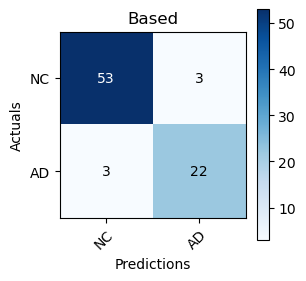

In [22]:
based_result_pred_list, based_result_true_list = calculate_weighted_probability(all_pid_list_based) 
show_confusion_matrix(based_result_pred_list, based_result_true_list)

## Analyze (Combined)

In [23]:
print(walk_subtask_dict[1])
print(sitstand_subtask_dict[1])
print(turn_subtask_dict[1])
print(facial_subtask_dict[1])

{'prob_class0': 0.13, 'prob_class1': 0.87, 'prediction': 1, 'actual': 0}
{'prob_class0': 0.49860000000000004, 'prob_class1': 0.5014, 'prediction': 1, 'actual': 0}
{'prob_class0': 0.9137, 'prob_class1': 0.0863, 'prediction': 0, 'actual': 0}
{'prob_class0': 0.8804, 'prob_class1': 0.1196, 'prediction': 0, 'actual': 0}


In [24]:
combined_result_dict = {}
combined_result_pred_list = []
combined_result_true_list = []

def calculate_weighted_probability(pidList):
    # lambda_walk = f1_score_walk * f1_score_walk            
    # lambda_sitstand = f1_score_sitstand * f1_score_sitstand 
    # lambda_turn = f1_score_turn * f1_score_turn            
    # lambda_facial = f1_score_facial * f1_score_facial       

    lambda_walk = f1_score_walk
    lambda_sitstand = f1_score_sitstand
    lambda_turn = f1_score_turn
    lambda_facial = f1_score_facial
    
    tmp_pred_list = []
    tmp_true_list = []
    
    for pid in pidList:
        walk_probNC, walk_probAD, walk_conf = 0, 0, 0
        sitstand_probNC, sitstand_probAD, sitstand_conf = 0, 0, 0
        turn_probNC, turn_probAD, turn_conf = 0, 0, 0
        facial_probNC, facial_probAD, facial_conf = 0, 0, 0

        n_subtask = 0
        
        pred_label = 0
        actual_label = 0
        
        if pid in walk_subtask_dict:
            n_subtask += 1
            walk_probNC = walk_subtask_dict[pid]['prob_class0']
            walk_probAD = walk_subtask_dict[pid]['prob_class1']
            actual_label = walk_subtask_dict[pid]['actual']
            walk_conf = subtask_importance_data[pid]['Walk']['conf']
        if pid in sitstand_subtask_dict:
            n_subtask += 1
            sitstand_probNC = sitstand_subtask_dict[pid]['prob_class0']
            sitstand_probAD = sitstand_subtask_dict[pid]['prob_class1']
            actual_label = sitstand_subtask_dict[pid]['actual']
            sitstand_conf = subtask_importance_data[pid]['SitStand']['conf']
        if pid in turn_subtask_dict:
            n_subtask += 1
            turn_probNC = turn_subtask_dict[pid]['prob_class0']
            turn_probAD = turn_subtask_dict[pid]['prob_class1']
            actual_label = turn_subtask_dict[pid]['actual']
            turn_conf = subtask_importance_data[pid]['Turn']['conf']
        if pid in facial_subtask_dict:
            n_subtask += 1
            facial_probNC = facial_subtask_dict[pid]['prob_class0'] 
            facial_probAD = facial_subtask_dict[pid]['prob_class1'] 
            actual_label = facial_subtask_dict[pid]['actual']
            facial_conf = subtask_importance_data[pid]['Facial']['conf']
        
        probNC = (lambda_walk*walk_conf*walk_probNC + lambda_sitstand*sitstand_conf*sitstand_probNC + lambda_turn*turn_conf*turn_probNC + lambda_facial*facial_conf*facial_probNC)/n_subtask
        probAD = (lambda_walk*walk_conf*walk_probAD + lambda_sitstand*sitstand_conf*sitstand_probAD + lambda_turn*turn_conf*turn_probAD + lambda_facial*facial_conf*facial_probAD)/n_subtask

        # ----- [Sum to 1] start -----
        probSum = probNC+probAD
        probNC = probNC*(1/probSum)
        probAD = probAD*(1/probSum)
        # ----- [Sum to 1] end -------
        
        if probAD >= probNC: pred_label = 1
        else: pred_label = 0

        combined_result_dict[pid] = {}
        combined_result_dict[pid]['predNC'] = round(probNC, 4)
        combined_result_dict[pid]['predAD'] = round(probAD, 4)
        combined_result_dict[pid]['prediction'] = pred_label
        combined_result_dict[pid]['actual'] = actual_label
        
        tmp_pred_list.append(pred_label)
        tmp_true_list.append(actual_label)
    return tmp_pred_list, tmp_true_list


def show_confusion_matrix(pred_list, true_list):
    predict_label_array = np.array(pred_list)
    actual_label_array = np.array(true_list)

    ### F1-Score
    print(f'==============  Classification Report  ==============')
    print(classification_report(actual_label_array, predict_label_array))

    ### Confusion Matrix
    matrix = confusion_matrix(actual_label_array, predict_label_array)
    TN, FP, FN, TP = matrix.ravel()

    value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    value_sensitivity = round(TP/(TP+FN), 4)
    value_specificity = round(TN/(TN+FP), 4)
    value_gmean = round(np.sqrt(value_sensitivity*value_specificity), 4)
    value_precision = round(TP/(TP+FP), 4)
    value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
    value_f2_measure = round(5*value_precision*value_sensitivity / (4*value_precision+value_sensitivity), 2)

    print(f'==================  Performance  ====================')
    print(f'0) TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    print(f'1) Accuracy: {round(value_accuracy*100, 2)}%')
    print(f'2) Sensitivity (Recall): {round(value_sensitivity*100, 2)}%')
    print(f'3) Specificity: {round(value_specificity*100, 2)}%')
    print(f'4) G-Mean: {round(value_gmean*100, 2)}%')
    print(f'5) Precision: {round(value_precision*100, 2)}%')
    print(f'6) F1-Score: {value_f1_score}')
    print(f'7) F2-Measure: {value_f2_measure}')
    print(f'8) Number of Subjects: {len(pred_list)}\n')
    
    classList = ['NC', 'AD']
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(3, 3), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Combined', fontsize=12)
    plt.show()


==============  Classification Report  ==============
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        68
           1       0.87      0.87      0.87        31

    accuracy                           0.92        99
   macro avg       0.91      0.91      0.91        99
weighted avg       0.92      0.92      0.92        99

==================  Performance  ====================
0) TN: 64, FP: 4, FN: 4, TP: 27
1) Accuracy: 91.92%
2) Sensitivity (Recall): 87.1%
3) Specificity: 94.12%
4) G-Mean: 90.54%
5) Precision: 87.1%
6) F1-Score: 0.87
7) F2-Measure: 0.87
8) Number of Subjects: 99



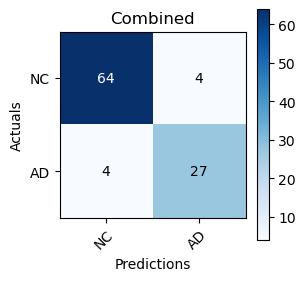

In [25]:
combined_result_pred_list, combined_result_true_list = calculate_weighted_probability(all_pid_list)    
show_confusion_matrix(combined_result_pred_list, combined_result_true_list)

In [26]:
combined_result_dict

{1: {'predNC': 0.5286, 'predAD': 0.4714, 'prediction': 0, 'actual': 0},
 2: {'predNC': 0.9426, 'predAD': 0.0574, 'prediction': 0, 'actual': 0},
 3: {'predNC': 0.8538, 'predAD': 0.1462, 'prediction': 0, 'actual': 0},
 4: {'predNC': 0.1765, 'predAD': 0.8235, 'prediction': 1, 'actual': 1},
 5: {'predNC': 0.654, 'predAD': 0.346, 'prediction': 0, 'actual': 0},
 6: {'predNC': 0.3348, 'predAD': 0.6652, 'prediction': 1, 'actual': 0},
 7: {'predNC': 0.9005, 'predAD': 0.0995, 'prediction': 0, 'actual': 0},
 9: {'predNC': 0.41, 'predAD': 0.59, 'prediction': 1, 'actual': 1},
 10: {'predNC': 0.3844, 'predAD': 0.6156, 'prediction': 1, 'actual': 1},
 11: {'predNC': 0.1853, 'predAD': 0.8147, 'prediction': 1, 'actual': 1},
 12: {'predNC': 0.5379, 'predAD': 0.4621, 'prediction': 0, 'actual': 1},
 13: {'predNC': 0.4522, 'predAD': 0.5478, 'prediction': 1, 'actual': 0},
 16: {'predNC': 0.2532, 'predAD': 0.7468, 'prediction': 1, 'actual': 1},
 17: {'predNC': 0.1697, 'predAD': 0.8303, 'prediction': 1, 'actua

## 2 Subtasks

In [27]:
def get_subtask_combination():
    s1 = "walk"
    s2 = "sitstand"
    s3 = "turn"
    s4 = "facial"

    combination = []
    combination.append([s1, s2])
    combination.append([s1, s3])
    combination.append([s1, s4])
    combination.append([s2, s3])
    combination.append([s2, s4])
    combination.append([s3, s4])
    return combination
    
subtask_combination = get_subtask_combination()
subtask_combination

[['walk', 'sitstand'],
 ['walk', 'turn'],
 ['walk', 'facial'],
 ['sitstand', 'turn'],
 ['sitstand', 'facial'],
 ['turn', 'facial']]

In [28]:
def get_wegith_result(task1, task2, pidList):
    if task1=="walk": 
        score1 = f1_score_walk
        result1 = walk_subtask_dict
    elif task1=="sitstand": 
        score1 = f1_score_sitstand
        result1 = sitstand_subtask_dict
    elif task1=="turn": 
        score1 = f1_score_turn
        result1 = turn_subtask_dict
    elif task1=="facial": 
        score1 = f1_score_facial
        result1 = facial_subtask_dict

    if task2=="walk": 
        score2 = f1_score_walk
        result2 = walk_subtask_dict
    elif task2=="sitstand": 
        score2 = f1_score_sitstand
        result2 = sitstand_subtask_dict
    elif task2=="turn":
        score2 = f1_score_turn
        result2 = turn_subtask_dict
    elif task2=="facial": 
        score2 = f1_score_facial
        result2 = facial_subtask_dict

    # lambda1 = score1*score1
    # lambda2 = score2*score2
    lambda1 = score1
    lambda2 = score2

    tmp_result_dict = {}
    tmp_pred_list, tmp_true_list = [], []

    for pid in pidList:
        task1_probNC, task1_probAD = 0, 0
        task2_probNC, task2_probAD = 0, 0
        conf1, conf2 = 0, 0

        n_subtask = 0
        if pid in result1:
            n_subtask += 1
            task1_probNC = result1[pid]['prob_class0']
            task1_probAD = result1[pid]['prob_class1']
            actual_label = result1[pid]['actual']
            if task1=="walk": conf1 = subtask_importance_data[pid]['Walk']['conf']
            if task1=="sitstand": conf1 = subtask_importance_data[pid]['SitStand']['conf']
            if task1=="turn": conf1 = subtask_importance_data[pid]['Turn']['conf']
            if task1=="facial": conf1 = subtask_importance_data[pid]['Facial']['conf']
            
        if pid in result2:
            n_subtask += 1
            task2_probNC = result2[pid]['prob_class0']
            task2_probAD = result2[pid]['prob_class1']
            actual_label = result2[pid]['actual']
            if task2=="walk": conf2 = subtask_importance_data[pid]['Walk']['conf']
            if task2=="sitstand": conf2 = subtask_importance_data[pid]['SitStand']['conf']
            if task2=="turn": conf2 = subtask_importance_data[pid]['Turn']['conf']
            if task2=="facial": conf2 = subtask_importance_data[pid]['Facial']['conf']

        if n_subtask==0:
            print(f'Combined [{task1}, {task2}] pid {pid} NOT exist.')
        else:
            probNC = (lambda1*conf1*task1_probNC + lambda2*conf2*task2_probNC)/n_subtask
            probAD = (lambda1*conf1*task1_probAD + lambda2*conf2*task2_probAD)/n_subtask
            
            if probAD >= probNC: pred_label = 1
            else: pred_label = 0
    
            tmp_result_dict[pid] = {}
            tmp_result_dict[pid]['probNC'] = probNC
            tmp_result_dict[pid]['probAD'] = probAD
            tmp_result_dict[pid]['prediction'] = pred_label
            tmp_result_dict[pid]['actual'] = actual_label
            
            tmp_pred_list.append(pred_label)
            tmp_true_list.append(actual_label)
    return tmp_pred_list, tmp_true_list, tmp_result_dict


def show_weight_result_with_confusion_matrix(task1, task2, pred_list, true_list):
    predict_label_array = np.array(pred_list)
    actual_label_array = np.array(true_list)

    ### F1-Score
    # print(f'==============  Classification Report  ==============')
    # print(classification_report(actual_label_array, predict_label_array))

    ### Confusion Matrix
    matrix = confusion_matrix(actual_label_array, predict_label_array)
    TN, FP, FN, TP = matrix.ravel()

    value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    value_sensitivity = round(TP/(TP+FN), 4)
    value_specificity = round(TN/(TN+FP), 4)
    value_gmean = round(np.sqrt(value_sensitivity*value_specificity), 4)
    value_precision = round(TP/(TP+FP), 4)
    value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
    value_f2_measure = round(5*value_precision*value_sensitivity / (4*value_precision+value_sensitivity), 2)

    # print(f'==================  Performance  ====================')
    print(f'0) TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    print(f'1) Accuracy: {round(value_accuracy*100, 2)}%')
    print(f'2) Sensitivity (Recall): {round(value_sensitivity*100, 2)}%')
    print(f'3) Specificity: {round(value_specificity*100, 2)}%')
    print(f'4) G-Mean: {round(value_gmean*100, 2)}%')
    print(f'5) Precision: {round(value_precision*100, 2)}%')
    print(f'6) F1-Score: {value_f1_score}')
    print(f'7) F2-Measure: {value_f2_measure}')
    print(f'8) Number of Subjects: {len(pred_list)}\n')
    
    classList = ['NC', 'AD']
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(3, 3), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title(f'Combined [{task1}, {task2}]', fontsize=12)
    plt.show()

def combination_result_with_2_subtask(pidList, combination):
    for comb in combination:
        task1 = comb[0]
        task2 = comb[1]

        print(f'------------------------------ Combined [{task1}, {task2}] ------------------------------')
        pred_list, true_list, weighted_result_dict = get_wegith_result(task1, task2, pidList)
        show_weight_result_with_confusion_matrix(task1, task2, pred_list, true_list)
    return weighted_result_dict

------------------------------ Combined [walk, sitstand] ------------------------------
Combined [walk, sitstand] pid 8 NOT exist.
Combined [walk, sitstand] pid 14 NOT exist.
Combined [walk, sitstand] pid 15 NOT exist.
Combined [walk, sitstand] pid 23 NOT exist.
Combined [walk, sitstand] pid 42 NOT exist.
Combined [walk, sitstand] pid 47 NOT exist.
Combined [walk, sitstand] pid 50 NOT exist.
Combined [walk, sitstand] pid 53 NOT exist.
Combined [walk, sitstand] pid 54 NOT exist.
Combined [walk, sitstand] pid 55 NOT exist.
Combined [walk, sitstand] pid 56 NOT exist.
0) TN: 53, FP: 5, FN: 2, TP: 28
1) Accuracy: 92.05%
2) Sensitivity (Recall): 93.33%
3) Specificity: 91.38%
4) G-Mean: 92.35%
5) Precision: 84.85%
6) F1-Score: 0.89
7) F2-Measure: 0.92
8) Number of Subjects: 88



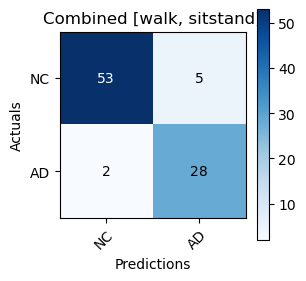

------------------------------ Combined [walk, turn] ------------------------------
Combined [walk, turn] pid 8 NOT exist.
Combined [walk, turn] pid 14 NOT exist.
Combined [walk, turn] pid 15 NOT exist.
Combined [walk, turn] pid 23 NOT exist.
Combined [walk, turn] pid 42 NOT exist.
Combined [walk, turn] pid 47 NOT exist.
Combined [walk, turn] pid 50 NOT exist.
Combined [walk, turn] pid 53 NOT exist.
Combined [walk, turn] pid 54 NOT exist.
Combined [walk, turn] pid 55 NOT exist.
Combined [walk, turn] pid 56 NOT exist.
0) TN: 54, FP: 4, FN: 3, TP: 27
1) Accuracy: 92.05%
2) Sensitivity (Recall): 90.0%
3) Specificity: 93.1%
4) G-Mean: 91.54%
5) Precision: 87.1%
6) F1-Score: 0.89
7) F2-Measure: 0.89
8) Number of Subjects: 88



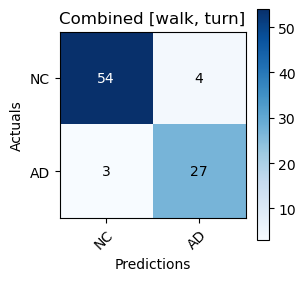

------------------------------ Combined [walk, facial] ------------------------------
0) TN: 63, FP: 5, FN: 3, TP: 28
1) Accuracy: 91.92%
2) Sensitivity (Recall): 90.32%
3) Specificity: 92.65%
4) G-Mean: 91.48%
5) Precision: 84.85%
6) F1-Score: 0.87
7) F2-Measure: 0.89
8) Number of Subjects: 99



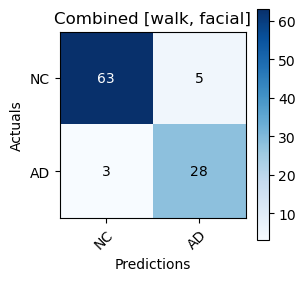

------------------------------ Combined [sitstand, turn] ------------------------------
Combined [sitstand, turn] pid 8 NOT exist.
Combined [sitstand, turn] pid 14 NOT exist.
Combined [sitstand, turn] pid 15 NOT exist.
Combined [sitstand, turn] pid 23 NOT exist.
Combined [sitstand, turn] pid 42 NOT exist.
Combined [sitstand, turn] pid 47 NOT exist.
Combined [sitstand, turn] pid 50 NOT exist.
Combined [sitstand, turn] pid 53 NOT exist.
Combined [sitstand, turn] pid 54 NOT exist.
Combined [sitstand, turn] pid 55 NOT exist.
Combined [sitstand, turn] pid 56 NOT exist.
0) TN: 52, FP: 6, FN: 11, TP: 19
1) Accuracy: 80.68%
2) Sensitivity (Recall): 63.33%
3) Specificity: 89.66%
4) G-Mean: 75.35%
5) Precision: 76.0%
6) F1-Score: 0.69
7) F2-Measure: 0.66
8) Number of Subjects: 88



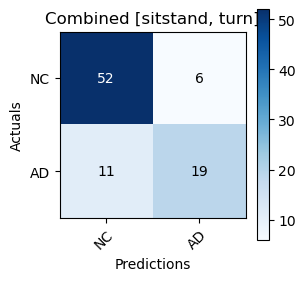

------------------------------ Combined [sitstand, facial] ------------------------------
0) TN: 63, FP: 5, FN: 19, TP: 12
1) Accuracy: 75.76%
2) Sensitivity (Recall): 38.71%
3) Specificity: 92.65%
4) G-Mean: 59.89%
5) Precision: 70.59%
6) F1-Score: 0.5
7) F2-Measure: 0.43
8) Number of Subjects: 99



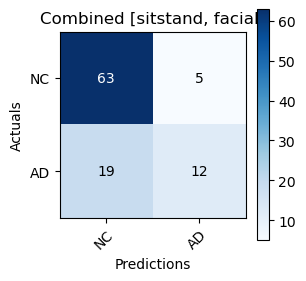

------------------------------ Combined [turn, facial] ------------------------------
Combined [turn, facial] pid 60 NOT exist.
0) TN: 63, FP: 5, FN: 14, TP: 16
1) Accuracy: 80.61%
2) Sensitivity (Recall): 53.33%
3) Specificity: 92.65%
4) G-Mean: 70.29%
5) Precision: 76.19%
6) F1-Score: 0.63
7) F2-Measure: 0.57
8) Number of Subjects: 98



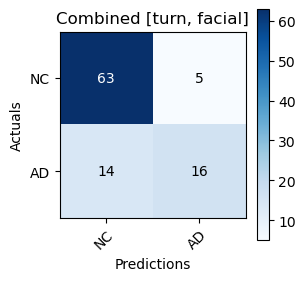

In [29]:
twoSubtask_weighted_result_dict = combination_result_with_2_subtask(all_pid_list, subtask_combination)

In [30]:
twoSubtask_weighted_result_dict[1]

{'probNC': 0.2024007934,
 'probAD': 0.022668206599999997,
 'prediction': 0,
 'actual': 0}

## 3 Subtasks

In [30]:
def get_subtask_combination():
    s1 = "walk"
    s2 = "sitstand"
    s3 = "turn"
    s4 = "facial"

    combination = []
    combination.append([s1, s2, s3])
    combination.append([s1, s2, s4])
    combination.append([s1, s3, s4])
    combination.append([s2, s3, s4])
    return combination
    
subtask_combination = get_subtask_combination()
subtask_combination

[['walk', 'sitstand', 'turn'],
 ['walk', 'sitstand', 'facial'],
 ['walk', 'turn', 'facial'],
 ['sitstand', 'turn', 'facial']]

------------------------------ Combined [walk, sitstand, turn] ------------------------------
Combined [walk, sitstand, turn] pid 8 NOT exist.
Combined [walk, sitstand, turn] pid 14 NOT exist.
Combined [walk, sitstand, turn] pid 15 NOT exist.
Combined [walk, sitstand, turn] pid 23 NOT exist.
Combined [walk, sitstand, turn] pid 42 NOT exist.
Combined [walk, sitstand, turn] pid 47 NOT exist.
Combined [walk, sitstand, turn] pid 50 NOT exist.
Combined [walk, sitstand, turn] pid 53 NOT exist.
Combined [walk, sitstand, turn] pid 54 NOT exist.
Combined [walk, sitstand, turn] pid 55 NOT exist.
Combined [walk, sitstand, turn] pid 56 NOT exist.
0) TN: 54, FP: 4, FN: 3, TP: 27
1) Accuracy: 92.05%
2) Sensitivity (Recall): 90.0%
3) Specificity: 93.1%
4) G-Mean: 91.54%
5) Precision: 87.1%
6) F1-Score: 0.89
7) F2-Measure: 0.89
8) Number of Subjects: 88



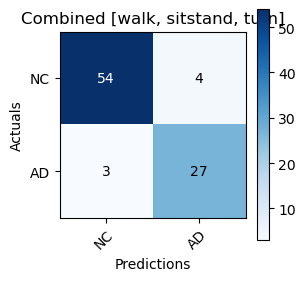

------------------------------ Combined [walk, sitstand, facial] ------------------------------
0) TN: 63, FP: 5, FN: 4, TP: 27
1) Accuracy: 90.91%
2) Sensitivity (Recall): 87.1%
3) Specificity: 92.65%
4) G-Mean: 89.83%
5) Precision: 84.38%
6) F1-Score: 0.86
7) F2-Measure: 0.87
8) Number of Subjects: 99



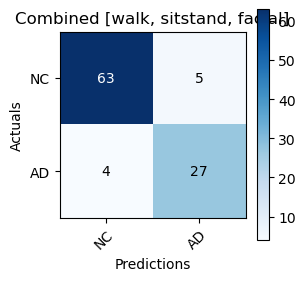

------------------------------ Combined [walk, turn, facial] ------------------------------
0) TN: 64, FP: 4, FN: 4, TP: 27
1) Accuracy: 91.92%
2) Sensitivity (Recall): 87.1%
3) Specificity: 94.12%
4) G-Mean: 90.54%
5) Precision: 87.1%
6) F1-Score: 0.87
7) F2-Measure: 0.87
8) Number of Subjects: 99



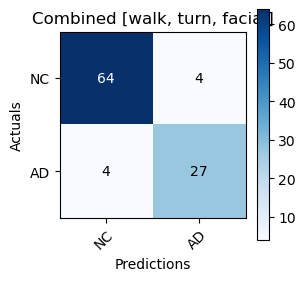

------------------------------ Combined [sitstand, turn, facial] ------------------------------
0) TN: 64, FP: 4, FN: 13, TP: 18
1) Accuracy: 82.83%
2) Sensitivity (Recall): 58.06%
3) Specificity: 94.12%
4) G-Mean: 73.92%
5) Precision: 81.82%
6) F1-Score: 0.68
7) F2-Measure: 0.62
8) Number of Subjects: 99



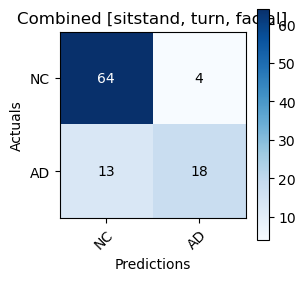

In [31]:
def get_wegith_result_3_task(task1, task2, task3, pidList):
    if task1=="walk": 
        score1 = f1_score_walk
        result1 = walk_subtask_dict
    elif task1=="sitstand": 
        score1 = f1_score_sitstand
        result1 = sitstand_subtask_dict
    elif task1=="turn": 
        score1 = f1_score_turn
        result1 = turn_subtask_dict
    elif task1=="facial": 
        score1 = f1_score_facial
        result1 = facial_subtask_dict

    if task2=="walk": 
        score2 = f1_score_walk
        result2 = walk_subtask_dict
    elif task2=="sitstand": 
        score2 = f1_score_sitstand
        result2 = sitstand_subtask_dict
    elif task2=="turn":
        score2 = f1_score_turn
        result2 = turn_subtask_dict
    elif task2=="facial": 
        score2 = f1_score_facial
        result2 = facial_subtask_dict

    if task3=="walk": 
        score3 = f1_score_walk
        result3 = walk_subtask_dict
    elif task3=="sitstand": 
        score3 = f1_score_sitstand
        result3 = sitstand_subtask_dict
    elif task3=="turn":
        score3 = f1_score_turn
        result3 = turn_subtask_dict
    elif task3=="facial": 
        score3 = f1_score_facial
        result3 = facial_subtask_dict

    # lambda1 = score1*score1
    # lambda2 = score2*score2
    # lambda3 = score3*score3
    lambda1 = score1
    lambda2 = score2
    lambda3 = score3

    tmp_result_dict = {}
    tmp_pred_list, tmp_true_list = [], []

    for pid in pidList:
        task1_probNC, task1_probAD = 0, 0
        task2_probNC, task2_probAD = 0, 0
        task3_probNC, task3_probAD = 0, 0
        conf1, conf2, conf3 = 0, 0, 0

        n_subtask = 0
        if pid in result1:
            n_subtask += 1
            task1_probNC = result1[pid]['prob_class0']
            task1_probAD = result1[pid]['prob_class1']
            actual_label = result1[pid]['actual']
            if task1=="walk": conf1 = subtask_importance_data[pid]['Walk']['conf']
            if task1=="sitstand": conf1 = subtask_importance_data[pid]['SitStand']['conf']
            if task1=="turn": conf1 = subtask_importance_data[pid]['Turn']['conf']
            if task1=="facial": conf1 = subtask_importance_data[pid]['Facial']['conf']
        if pid in result2:
            n_subtask += 1
            task2_probNC = result2[pid]['prob_class0']
            task2_probAD = result2[pid]['prob_class1']
            actual_label = result2[pid]['actual']
            if task2=="walk": conf2 = subtask_importance_data[pid]['Walk']['conf']
            if task2=="sitstand": conf2 = subtask_importance_data[pid]['SitStand']['conf']
            if task2=="turn": conf2 = subtask_importance_data[pid]['Turn']['conf']
            if task2=="facial": conf2 = subtask_importance_data[pid]['Facial']['conf']
        if pid in result3:
            n_subtask += 1
            task3_probNC = result3[pid]['prob_class0']
            task3_probAD = result3[pid]['prob_class1']
            actual_label = result3[pid]['actual']
            if task3=="walk": conf3 = subtask_importance_data[pid]['Walk']['conf']
            if task3=="sitstand": conf3 = subtask_importance_data[pid]['SitStand']['conf']
            if task3=="turn": conf3 = subtask_importance_data[pid]['Turn']['conf']
            if task3=="facial": conf3 = subtask_importance_data[pid]['Facial']['conf']

        if n_subtask==0:
            print(f'Combined [{task1}, {task2}, {task3}] pid {pid} NOT exist.')
        else:
            probNC = (lambda1*conf1*task1_probNC + lambda2*conf2*task2_probNC + lambda3*conf3*task3_probNC)/n_subtask
            probAD = (lambda1*conf1*task1_probAD + lambda2*conf2*task2_probAD + lambda3*conf3*task3_probAD)/n_subtask
            
            if probAD >= probNC: pred_label = 1
            else: pred_label = 0
    
            tmp_result_dict[pid] = {}
            tmp_result_dict[pid]['probNC'] = probNC
            tmp_result_dict[pid]['probAD'] = probAD
            tmp_result_dict[pid]['prediction'] = pred_label
            tmp_result_dict[pid]['actual'] = actual_label
            
            tmp_pred_list.append(pred_label)
            tmp_true_list.append(actual_label)
    return tmp_pred_list, tmp_true_list, tmp_result_dict


def show_weight_result_with_confusion_matrix(task1, task2, task3, pred_list, true_list):
    predict_label_array = np.array(pred_list)
    actual_label_array = np.array(true_list)

    ### F1-Score
    # print(f'==============  Classification Report  ==============')
    # print(classification_report(actual_label_array, predict_label_array))

    ### Confusion Matrix
    matrix = confusion_matrix(actual_label_array, predict_label_array)
    TN, FP, FN, TP = matrix.ravel()

    value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    value_sensitivity = round(TP/(TP+FN), 4)
    value_specificity = round(TN/(TN+FP), 4)
    value_gmean = round(np.sqrt(value_sensitivity*value_specificity), 4)
    value_precision = round(TP/(TP+FP), 4)
    value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
    value_f2_measure = round(5*value_precision*value_sensitivity / (4*value_precision+value_sensitivity), 2)

    # print(f'==================  Performance  ====================')
    print(f'0) TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    print(f'1) Accuracy: {round(value_accuracy*100, 2)}%')
    print(f'2) Sensitivity (Recall): {round(value_sensitivity*100, 2)}%')
    print(f'3) Specificity: {round(value_specificity*100, 2)}%')
    print(f'4) G-Mean: {round(value_gmean*100, 2)}%')
    print(f'5) Precision: {round(value_precision*100, 2)}%')
    print(f'6) F1-Score: {value_f1_score}')
    print(f'7) F2-Measure: {value_f2_measure}')
    print(f'8) Number of Subjects: {len(pred_list)}\n')
    
    classList = ['NC', 'AD']
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(3, 3), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title(f'Combined [{task1}, {task2}, {task3}]', fontsize=12)
    plt.show()

def combination_result_with_3_subtask(pidList, combination):
    for comb in combination:
        task1 = comb[0]
        task2 = comb[1]
        task3 = comb[2]

        print(f'------------------------------ Combined [{task1}, {task2}, {task3}] ------------------------------')
        pred_list, true_list, weighted_result_dict = get_wegith_result_3_task(task1, task2, task3, pidList)
        show_weight_result_with_confusion_matrix(task1, task2, task3, pred_list, true_list)
    return weighted_result_dict

threeSubtask_weighted_result_dict = combination_result_with_3_subtask(all_pid_list, subtask_combination)

In [32]:
threeSubtask_weighted_result_dict[1]

{'probNC': 0.14455838183333333,
 'probAD': 0.024973284833333328,
 'prediction': 0,
 'actual': 0}

## Random Seed

In [29]:
# [RandomSeed]
walking_f1score_list = [0.88, 0.91, 0.85, 0.88, 0.92, 0.89, 0.86, 0.88, 0.87, 0.89]
sitstand_f1score_list = [0.56, 0.41, 0.33, 0.51, 0.25, 0.46, 0.4, 0.35, 0.32, 0.38]
facial_f1score_list = [0.64, 0.49, 0.77, 0.51, 0.6, 0.53, 0.6, 0.57, 0.68, 0.69]
seed_value_list = [10, 20, 42, 64, 100, 123, 200, 456, 1001, 12321]

### 2 Subtasks

In [30]:
def get_subtask_combination():
    s1 = "walk"
    s2 = "sitstand"
    s3 = "turn"
    s4 = "facial"

    combination = []
    combination.append([s1, s2])
    combination.append([s1, s3])
    combination.append([s1, s4])
    combination.append([s2, s3])
    combination.append([s2, s4])
    combination.append([s3, s4])
    return combination
    
subtask_combination = get_subtask_combination()
subtask_combination

[['walk', 'sitstand'],
 ['walk', 'turn'],
 ['walk', 'facial'],
 ['sitstand', 'turn'],
 ['sitstand', 'facial'],
 ['turn', 'facial']]

In [31]:
def create_walking_sitstand_facial_subtask_dictionary_RandomSeed(filename):
    data = pd.read_csv(filename)
    tmp_dict = {}
    for i in range(data.shape[0]):
        pid = data.loc[i, 'pid']
        p_class1 = data.loc[i, 'avgProb'] ### probability for class 1 (AD)
        prediction = data.loc[i, 'prediction']
        actual = data.loc[i, 'actual']
        
        p_class0 = 1 - p_class1 ### probability for class 0 (NC)
        
        tmp_dict[pid] = {}
        tmp_dict[pid]['prob_class0'] = p_class0
        tmp_dict[pid]['prob_class1'] = p_class1
        tmp_dict[pid]['prediction'] = prediction
        tmp_dict[pid]['actual'] = actual
    return tmp_dict


def create_turning_subtask_dictionary_RandomSeed(filename):
    data = pd.read_csv(filename)
    tmp_dict = {}
    for i in range(data.shape[0]):
        pid = data.loc[i, 'pid']
        p_class0 = data.loc[i, 'prob_NC']
        p_class1 = data.loc[i, 'prob_AD']
        prediction = data.loc[i, 'prediction']
        actual = data.loc[i, 'actual']
        
        tmp_dict[pid] = {}
        tmp_dict[pid]['prob_class0'] = p_class0
        tmp_dict[pid]['prob_class1'] = p_class1
        tmp_dict[pid]['prediction'] = prediction
        tmp_dict[pid]['actual'] = actual
    return tmp_dict

def organize_subtask_importance_data_RandomSeed(pidList, w_f1score, s_f1score, t_f1score, f_f1score, w_dict, s_dict, t_dict, f_dict):
    lambda_walk = w_f1score
    lambda_sitstand = s_f1score
    lambda_turn = t_f1score
    lambda_facial = f_f1score

    tmp_dict = {}
    for pid in pidList:
        tmp_dict[pid] = {}
        tmp_dict[pid]['Walk'] = {}
        tmp_dict[pid]['SitStand'] = {}
        tmp_dict[pid]['Turn'] = {}
        tmp_dict[pid]['Facial'] = {}

        if pid in walk_subjects:
            tmp_dict[pid]['Walk']['Fold'] = walk_subjects[pid]
            tmp_dict[pid]['Walk']['Threshold'] = threshold_walk_5f[walk_subjects[pid]]
            tmp_dict[pid]['Walk']['probAD'] = w_dict[pid]['prob_class1']
            tmp_dict[pid]['Walk']['conf'] = abs(threshold_walk_5f[walk_subjects[pid]]-w_dict[pid]['prob_class1'])
            tmp_dict[pid]['Walk']['probAD_weighted'] = round(w_dict[pid]['prob_class1']*lambda_walk, 4)
            
        if pid in sitstand_subjects:
            tmp_dict[pid]['SitStand']['Fold'] = sitstand_subjects[pid]
            tmp_dict[pid]['SitStand']['Threshold'] = threshold_sitstand_5f[sitstand_subjects[pid]]
            tmp_dict[pid]['SitStand']['probAD'] = s_dict[pid]['prob_class1']
            tmp_dict[pid]['SitStand']['conf'] = abs(threshold_sitstand_5f[sitstand_subjects[pid]]-s_dict[pid]['prob_class1'])
            tmp_dict[pid]['SitStand']['probAD_weighted'] = round(s_dict[pid]['prob_class1']*lambda_sitstand, 4)
            
        if pid in turn_subjects:
            tmp_dict[pid]['Turn']['Fold'] = turn_subjects[pid]
            tmp_dict[pid]['Turn']['Threshold'] = threshold_turn_5f[turn_subjects[pid]]
            tmp_dict[pid]['Turn']['probAD'] = t_dict[pid]['prob_class1']
            tmp_dict[pid]['Turn']['conf'] = abs(threshold_turn_5f[turn_subjects[pid]]-t_dict[pid]['prob_class1'])
            tmp_dict[pid]['Turn']['probAD_weighted'] = round(t_dict[pid]['prob_class1']*lambda_turn, 4)
            
        if pid in facial_subjects:
            tmp_dict[pid]['Facial']['Fold'] = facial_subjects[pid]
            tmp_dict[pid]['Facial']['Threshold'] = threshold_facial_5f[facial_subjects[pid]]
            tmp_dict[pid]['Facial']['probAD'] = f_dict[pid]['prob_class1']
            tmp_dict[pid]['Facial']['conf'] = abs(threshold_facial_5f[facial_subjects[pid]]-f_dict[pid]['prob_class1'])
            tmp_dict[pid]['Facial']['probAD_weighted'] = round(f_dict[pid]['prob_class1']*lambda_facial, 4)
    return tmp_dict

In [32]:
WS_accuracy, WT_accuracy, WF_accuracy, ST_accuracy, SF_accuracy, TF_accuracy = [], [], [], [], [], []
WS_sensitivity, WT_sensitivity, WF_sensitivity, ST_sensitivity, SF_sensitivity, TF_sensitivity = [], [], [], [], [], []
WS_specificity, WT_specificity, WF_specificity, ST_specificity, SF_specificity, TF_specificity = [], [], [], [], [], []
WS_precision, WT_precision, WF_precision, ST_precision, SF_precision, TF_precision = [], [], [], [], [], []
WS_f1score, WT_f1score, WF_f1score, ST_f1score, SF_f1score, TF_f1score = [], [], [], [], [], []


def get_weighted_result_RandomSeed(pidList, task1, task2, score1, score2, result1, result2, subtask_importance):
    lambda1 = score1
    lambda2 = score2

    tmp_result_dict = {}
    tmp_pred_list, tmp_true_list = [], []

    for pid in pidList:
        task1_probNC, task1_probAD = 0, 0
        task2_probNC, task2_probAD = 0, 0
        conf1, conf2 = 0, 0

        n_subtask = 0
        if pid in result1:
            n_subtask += 1
            task1_probNC = result1[pid]['prob_class0']
            task1_probAD = result1[pid]['prob_class1']
            actual_label = result1[pid]['actual']
            if task1=="walk": conf1 = subtask_importance[pid]['Walk']['conf']
            if task1=="sitstand": conf1 = subtask_importance[pid]['SitStand']['conf']
            if task1=="turn": conf1 = subtask_importance[pid]['Turn']['conf']
            if task1=="facial": conf1 = subtask_importance[pid]['Facial']['conf']
            
        if pid in result2:
            n_subtask += 1
            task2_probNC = result2[pid]['prob_class0']
            task2_probAD = result2[pid]['prob_class1']
            actual_label = result2[pid]['actual']
            if task2=="walk": conf2 = subtask_importance[pid]['Walk']['conf']
            if task2=="sitstand": conf2 = subtask_importance[pid]['SitStand']['conf']
            if task2=="turn": conf2 = subtask_importance[pid]['Turn']['conf']
            if task2=="facial": conf2 = subtask_importance[pid]['Facial']['conf']

        if n_subtask==0:
            print(f'Combined [{task1}, {task2}] pid {pid} NOT exist.')
        else:
            probNC = (lambda1*conf1*task1_probNC + lambda2*conf2*task2_probNC)/n_subtask
            probAD = (lambda1*conf1*task1_probAD + lambda2*conf2*task2_probAD)/n_subtask
            
            if probAD >= probNC: pred_label = 1
            else: pred_label = 0
    
            tmp_result_dict[pid] = {}
            tmp_result_dict[pid]['probNC'] = probNC
            tmp_result_dict[pid]['probAD'] = probAD
            tmp_result_dict[pid]['prediction'] = pred_label
            tmp_result_dict[pid]['actual'] = actual_label
            
            tmp_pred_list.append(pred_label)
            tmp_true_list.append(actual_label)
    return tmp_pred_list, tmp_true_list, tmp_result_dict


def show_weighted_result_with_confusion_matrix_RandomSeed(task1, task2, pred_list, true_list):
    predict_label_array = np.array(pred_list)
    actual_label_array = np.array(true_list)

    ### F1-Score
    # print(f'==============  Classification Report  ==============')
    # print(classification_report(actual_label_array, predict_label_array))

    ### Confusion Matrix
    matrix = confusion_matrix(actual_label_array, predict_label_array)
    TN, FP, FN, TP = matrix.ravel()

    value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    value_sensitivity = round(TP/(TP+FN), 4)
    value_specificity = round(TN/(TN+FP), 4)
    value_gmean = round(np.sqrt(value_sensitivity*value_specificity), 4)
    value_precision = round(TP/(TP+FP), 4)
    value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
    value_f2_measure = round(5*value_precision*value_sensitivity / (4*value_precision+value_sensitivity), 2)

    # print(f'==================  Performance  ====================')
    print(f'0) TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    print(f'1) Accuracy: {round(value_accuracy*100, 2)}%')
    print(f'2) Sensitivity (Recall): {round(value_sensitivity*100, 2)}%')
    print(f'3) Specificity: {round(value_specificity*100, 2)}%')
    print(f'4) G-Mean: {round(value_gmean*100, 2)}%')
    print(f'5) Precision: {round(value_precision*100, 2)}%')
    print(f'6) F1-Score: {value_f1_score}')
    print(f'7) F2-Measure: {value_f2_measure}')
    print(f'8) Number of Subjects: {len(pred_list)}\n')
    
    classList = ['NC', 'AD']
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(3, 3), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title(f'Combined [{task1}, {task2}]', fontsize=12)
    plt.show()

    if task1=="walk" and task2=="sitstand":
        WS_accuracy.append(round(value_accuracy*100, 2))
        WS_sensitivity.append(round(value_sensitivity*100, 2))
        WS_specificity.append(round(value_specificity*100, 2))
        WS_precision.append(round(value_precision*100, 2))
        WS_f1score.append(value_f1_score)
    elif task1=="walk" and task2=="turn":
        WT_accuracy.append(round(value_accuracy*100, 2))
        WT_sensitivity.append(round(value_sensitivity*100, 2))
        WT_specificity.append(round(value_specificity*100, 2))
        WT_precision.append(round(value_precision*100, 2))
        WT_f1score.append(value_f1_score)
    elif task1=="walk" and task2=="facial":
        WF_accuracy.append(round(value_accuracy*100, 2))
        WF_sensitivity.append(round(value_sensitivity*100, 2))
        WF_specificity.append(round(value_specificity*100, 2))
        WF_precision.append(round(value_precision*100, 2))
        WF_f1score.append(value_f1_score)
    elif task1=="sitstand" and task2=="turn":
        ST_accuracy.append(round(value_accuracy*100, 2))
        ST_sensitivity.append(round(value_sensitivity*100, 2))
        ST_specificity.append(round(value_specificity*100, 2))
        ST_precision.append(round(value_precision*100, 2))
        ST_f1score.append(value_f1_score)
    elif task1=="sitstand" and task2=="facial":
        SF_accuracy.append(round(value_accuracy*100, 2))
        SF_sensitivity.append(round(value_sensitivity*100, 2))
        SF_specificity.append(round(value_specificity*100, 2))
        SF_precision.append(round(value_precision*100, 2))
        SF_f1score.append(value_f1_score)
    elif task1=="turn" and task2=="facial":
        TF_accuracy.append(round(value_accuracy*100, 2))
        TF_sensitivity.append(round(value_sensitivity*100, 2))
        TF_specificity.append(round(value_specificity*100, 2))
        TF_precision.append(round(value_precision*100, 2))
        TF_f1score.append(value_f1_score)
        
    
    
def combination_result_with_2_subtask_RandomSeed(pidList, combination, seed_value_list):
    for idx, seed_value in enumerate(seed_value_list):
        w_f1score = walking_f1score_list[idx]
        s_f1score = sitstand_f1score_list[idx]
        t_f1score = f1_score_turn
        f_f1score = facial_f1score_list[idx]
        
        w_filename = "../1_GaitAnalysis_ver3_YOLO7_Training/Walking_RandomSeed_FS_0516_v2/Results/" + str(seed_value) + "_FS_weighted.csv"
        s_filename = "../1_GaitAnalysis_ver3_YOLO7_Training/SitAndStand_RandomSeed/Results/" + str(seed_value) + "_SitStand_combined.csv "
        t_filename = "../3_TurningSubtask/RandomSeed/" + str(seed_value) + "_Turning_Subtask.csv "
        f_filename = "../2_EyeTrackingAnalysis/Facial_RandomSeed_FS_0516_v2/Results/" + str(seed_value) + "_FS_weighted.csv "
        
        w_result_dict = create_walking_sitstand_facial_subtask_dictionary_RandomSeed(w_filename)
        s_result_dict = create_walking_sitstand_facial_subtask_dictionary_RandomSeed(s_filename)
        t_result_dict = create_turning_subtask_dictionary_RandomSeed(t_filename)
        f_result_dict = create_walking_sitstand_facial_subtask_dictionary_RandomSeed(f_filename)
        
        subtask_importance = {}
        subtask_importance = organize_subtask_importance_data_RandomSeed(pidList, w_f1score, s_f1score, t_f1score, f_f1score, w_result_dict, s_result_dict, t_result_dict, f_result_dict)
        
        for comb in combination:
            task1 = comb[0]
            task2 = comb[1]
            
            if task1=="walk":
                score1 = w_f1score
                result1 = w_result_dict
            elif task1=="sitstand":
                score1 = s_f1score
                result1 = s_result_dict
            elif task1=="turn":
                score1 = t_f1score
                result1 = t_result_dict
            elif task1=="facial":
                score1 = f_f1score
                result1 = f_result_dict
                
            if task2=="walk":
                score2 = w_f1score
                result2 = w_result_dict
            elif task2=="sitstand":
                score2 = s_f1score
                result2 = s_result_dict
            elif task2=="turn":
                score2 = t_f1score
                result2 = t_result_dict
            elif task2=="facial":
                score2 = f_f1score
                result2 = f_result_dict
                

            print(f'------------------------------ Seed_value=[{seed_value}], Combined [{task1}, {task2}] ------------------------------')
            pred_list, true_list, weighted_result_dict = get_weighted_result_RandomSeed(pidList, task1, task2, score1, score2, result1, result2, subtask_importance)
            show_weighted_result_with_confusion_matrix_RandomSeed(task1, task2, pred_list, true_list)
    # return weighted_result_dict

------------------------------ Seed_value=[10], Combined [walk, sitstand] ------------------------------
Combined [walk, sitstand] pid 8 NOT exist.
Combined [walk, sitstand] pid 14 NOT exist.
Combined [walk, sitstand] pid 15 NOT exist.
Combined [walk, sitstand] pid 23 NOT exist.
Combined [walk, sitstand] pid 42 NOT exist.
Combined [walk, sitstand] pid 47 NOT exist.
Combined [walk, sitstand] pid 50 NOT exist.
Combined [walk, sitstand] pid 53 NOT exist.
Combined [walk, sitstand] pid 54 NOT exist.
Combined [walk, sitstand] pid 55 NOT exist.
Combined [walk, sitstand] pid 56 NOT exist.
0) TN: 53, FP: 5, FN: 2, TP: 28
1) Accuracy: 92.05%
2) Sensitivity (Recall): 93.33%
3) Specificity: 91.38%
4) G-Mean: 92.35%
5) Precision: 84.85%
6) F1-Score: 0.89
7) F2-Measure: 0.92
8) Number of Subjects: 88



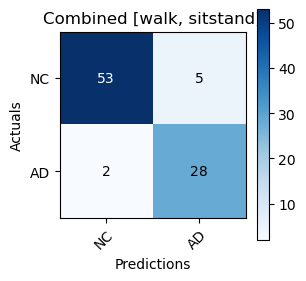

------------------------------ Seed_value=[10], Combined [walk, turn] ------------------------------
Combined [walk, turn] pid 8 NOT exist.
Combined [walk, turn] pid 14 NOT exist.
Combined [walk, turn] pid 15 NOT exist.
Combined [walk, turn] pid 23 NOT exist.
Combined [walk, turn] pid 42 NOT exist.
Combined [walk, turn] pid 47 NOT exist.
Combined [walk, turn] pid 50 NOT exist.
Combined [walk, turn] pid 53 NOT exist.
Combined [walk, turn] pid 54 NOT exist.
Combined [walk, turn] pid 55 NOT exist.
Combined [walk, turn] pid 56 NOT exist.
0) TN: 54, FP: 4, FN: 3, TP: 27
1) Accuracy: 92.05%
2) Sensitivity (Recall): 90.0%
3) Specificity: 93.1%
4) G-Mean: 91.54%
5) Precision: 87.1%
6) F1-Score: 0.89
7) F2-Measure: 0.89
8) Number of Subjects: 88



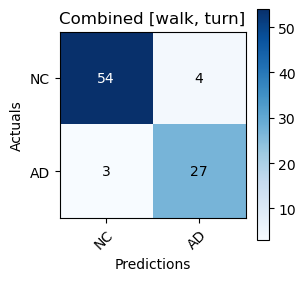

------------------------------ Seed_value=[10], Combined [walk, facial] ------------------------------
0) TN: 63, FP: 5, FN: 3, TP: 28
1) Accuracy: 91.92%
2) Sensitivity (Recall): 90.32%
3) Specificity: 92.65%
4) G-Mean: 91.48%
5) Precision: 84.85%
6) F1-Score: 0.87
7) F2-Measure: 0.89
8) Number of Subjects: 99



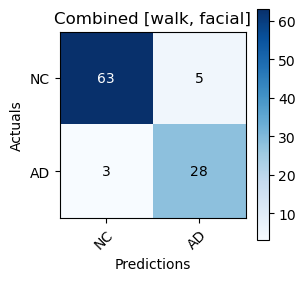

------------------------------ Seed_value=[10], Combined [sitstand, turn] ------------------------------
Combined [sitstand, turn] pid 8 NOT exist.
Combined [sitstand, turn] pid 14 NOT exist.
Combined [sitstand, turn] pid 15 NOT exist.
Combined [sitstand, turn] pid 23 NOT exist.
Combined [sitstand, turn] pid 42 NOT exist.
Combined [sitstand, turn] pid 47 NOT exist.
Combined [sitstand, turn] pid 50 NOT exist.
Combined [sitstand, turn] pid 53 NOT exist.
Combined [sitstand, turn] pid 54 NOT exist.
Combined [sitstand, turn] pid 55 NOT exist.
Combined [sitstand, turn] pid 56 NOT exist.
0) TN: 52, FP: 6, FN: 11, TP: 19
1) Accuracy: 80.68%
2) Sensitivity (Recall): 63.33%
3) Specificity: 89.66%
4) G-Mean: 75.35%
5) Precision: 76.0%
6) F1-Score: 0.69
7) F2-Measure: 0.66
8) Number of Subjects: 88



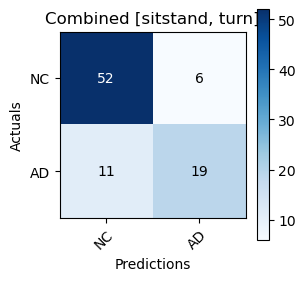

------------------------------ Seed_value=[10], Combined [sitstand, facial] ------------------------------
0) TN: 63, FP: 5, FN: 19, TP: 12
1) Accuracy: 75.76%
2) Sensitivity (Recall): 38.71%
3) Specificity: 92.65%
4) G-Mean: 59.89%
5) Precision: 70.59%
6) F1-Score: 0.5
7) F2-Measure: 0.43
8) Number of Subjects: 99



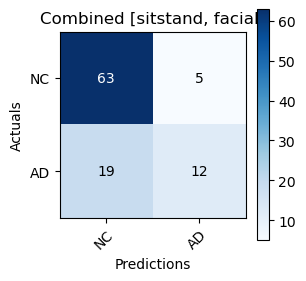

------------------------------ Seed_value=[10], Combined [turn, facial] ------------------------------
Combined [turn, facial] pid 60 NOT exist.
0) TN: 64, FP: 4, FN: 15, TP: 15
1) Accuracy: 80.61%
2) Sensitivity (Recall): 50.0%
3) Specificity: 94.12%
4) G-Mean: 68.6%
5) Precision: 78.95%
6) F1-Score: 0.61
7) F2-Measure: 0.54
8) Number of Subjects: 98



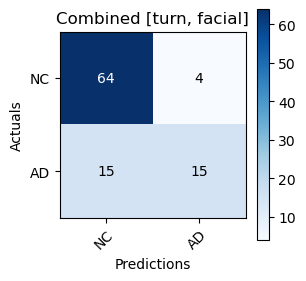

------------------------------ Seed_value=[20], Combined [walk, sitstand] ------------------------------
Combined [walk, sitstand] pid 8 NOT exist.
Combined [walk, sitstand] pid 14 NOT exist.
Combined [walk, sitstand] pid 15 NOT exist.
Combined [walk, sitstand] pid 23 NOT exist.
Combined [walk, sitstand] pid 42 NOT exist.
Combined [walk, sitstand] pid 47 NOT exist.
Combined [walk, sitstand] pid 50 NOT exist.
Combined [walk, sitstand] pid 53 NOT exist.
Combined [walk, sitstand] pid 54 NOT exist.
Combined [walk, sitstand] pid 55 NOT exist.
Combined [walk, sitstand] pid 56 NOT exist.
0) TN: 53, FP: 5, FN: 0, TP: 30
1) Accuracy: 94.32%
2) Sensitivity (Recall): 100.0%
3) Specificity: 91.38%
4) G-Mean: 95.59%
5) Precision: 85.71%
6) F1-Score: 0.92
7) F2-Measure: 0.97
8) Number of Subjects: 88



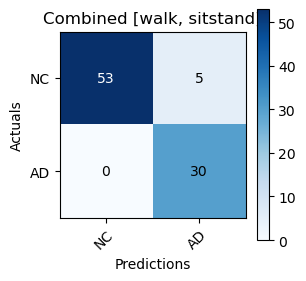

------------------------------ Seed_value=[20], Combined [walk, turn] ------------------------------
Combined [walk, turn] pid 8 NOT exist.
Combined [walk, turn] pid 14 NOT exist.
Combined [walk, turn] pid 15 NOT exist.
Combined [walk, turn] pid 23 NOT exist.
Combined [walk, turn] pid 42 NOT exist.
Combined [walk, turn] pid 47 NOT exist.
Combined [walk, turn] pid 50 NOT exist.
Combined [walk, turn] pid 53 NOT exist.
Combined [walk, turn] pid 54 NOT exist.
Combined [walk, turn] pid 55 NOT exist.
Combined [walk, turn] pid 56 NOT exist.
0) TN: 54, FP: 4, FN: 2, TP: 28
1) Accuracy: 93.18%
2) Sensitivity (Recall): 93.33%
3) Specificity: 93.1%
4) G-Mean: 93.21%
5) Precision: 87.5%
6) F1-Score: 0.9
7) F2-Measure: 0.92
8) Number of Subjects: 88



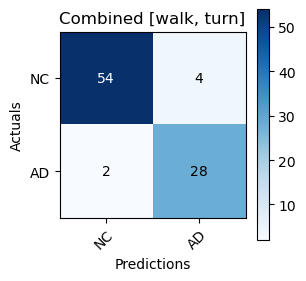

------------------------------ Seed_value=[20], Combined [walk, facial] ------------------------------
0) TN: 64, FP: 4, FN: 3, TP: 28
1) Accuracy: 92.93%
2) Sensitivity (Recall): 90.32%
3) Specificity: 94.12%
4) G-Mean: 92.2%
5) Precision: 87.5%
6) F1-Score: 0.89
7) F2-Measure: 0.9
8) Number of Subjects: 99



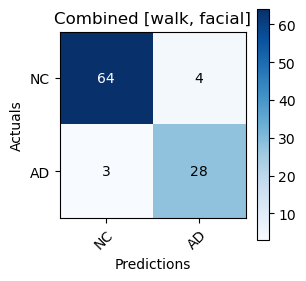

------------------------------ Seed_value=[20], Combined [sitstand, turn] ------------------------------
Combined [sitstand, turn] pid 8 NOT exist.
Combined [sitstand, turn] pid 14 NOT exist.
Combined [sitstand, turn] pid 15 NOT exist.
Combined [sitstand, turn] pid 23 NOT exist.
Combined [sitstand, turn] pid 42 NOT exist.
Combined [sitstand, turn] pid 47 NOT exist.
Combined [sitstand, turn] pid 50 NOT exist.
Combined [sitstand, turn] pid 53 NOT exist.
Combined [sitstand, turn] pid 54 NOT exist.
Combined [sitstand, turn] pid 55 NOT exist.
Combined [sitstand, turn] pid 56 NOT exist.
0) TN: 54, FP: 4, FN: 18, TP: 12
1) Accuracy: 75.0%
2) Sensitivity (Recall): 40.0%
3) Specificity: 93.1%
4) G-Mean: 61.02%
5) Precision: 75.0%
6) F1-Score: 0.52
7) F2-Measure: 0.44
8) Number of Subjects: 88



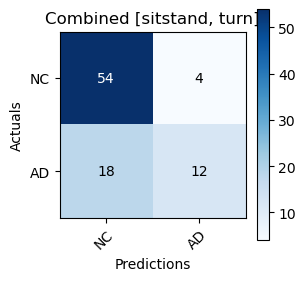

------------------------------ Seed_value=[20], Combined [sitstand, facial] ------------------------------
0) TN: 66, FP: 2, FN: 24, TP: 7
1) Accuracy: 73.74%
2) Sensitivity (Recall): 22.58%
3) Specificity: 97.06%
4) G-Mean: 46.81%
5) Precision: 77.78%
6) F1-Score: 0.35
7) F2-Measure: 0.26
8) Number of Subjects: 99



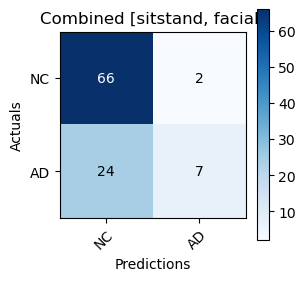

------------------------------ Seed_value=[20], Combined [turn, facial] ------------------------------
Combined [turn, facial] pid 60 NOT exist.
0) TN: 66, FP: 2, FN: 14, TP: 16
1) Accuracy: 83.67%
2) Sensitivity (Recall): 53.33%
3) Specificity: 97.06%
4) G-Mean: 71.95%
5) Precision: 88.89%
6) F1-Score: 0.67
7) F2-Measure: 0.58
8) Number of Subjects: 98



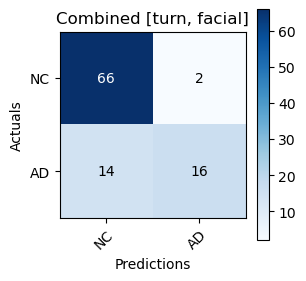

------------------------------ Seed_value=[42], Combined [walk, sitstand] ------------------------------
Combined [walk, sitstand] pid 8 NOT exist.
Combined [walk, sitstand] pid 14 NOT exist.
Combined [walk, sitstand] pid 15 NOT exist.
Combined [walk, sitstand] pid 23 NOT exist.
Combined [walk, sitstand] pid 42 NOT exist.
Combined [walk, sitstand] pid 47 NOT exist.
Combined [walk, sitstand] pid 50 NOT exist.
Combined [walk, sitstand] pid 53 NOT exist.
Combined [walk, sitstand] pid 54 NOT exist.
Combined [walk, sitstand] pid 55 NOT exist.
Combined [walk, sitstand] pid 56 NOT exist.
0) TN: 50, FP: 8, FN: 1, TP: 29
1) Accuracy: 89.77%
2) Sensitivity (Recall): 96.67%
3) Specificity: 86.21%
4) G-Mean: 91.29%
5) Precision: 78.38%
6) F1-Score: 0.87
7) F2-Measure: 0.92
8) Number of Subjects: 88



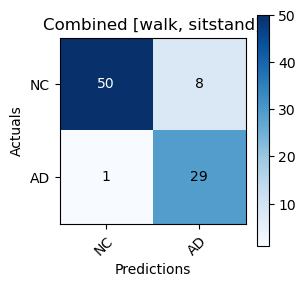

------------------------------ Seed_value=[42], Combined [walk, turn] ------------------------------
Combined [walk, turn] pid 8 NOT exist.
Combined [walk, turn] pid 14 NOT exist.
Combined [walk, turn] pid 15 NOT exist.
Combined [walk, turn] pid 23 NOT exist.
Combined [walk, turn] pid 42 NOT exist.
Combined [walk, turn] pid 47 NOT exist.
Combined [walk, turn] pid 50 NOT exist.
Combined [walk, turn] pid 53 NOT exist.
Combined [walk, turn] pid 54 NOT exist.
Combined [walk, turn] pid 55 NOT exist.
Combined [walk, turn] pid 56 NOT exist.
0) TN: 54, FP: 4, FN: 3, TP: 27
1) Accuracy: 92.05%
2) Sensitivity (Recall): 90.0%
3) Specificity: 93.1%
4) G-Mean: 91.54%
5) Precision: 87.1%
6) F1-Score: 0.89
7) F2-Measure: 0.89
8) Number of Subjects: 88



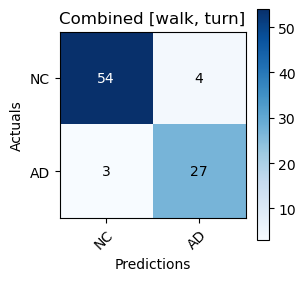

------------------------------ Seed_value=[42], Combined [walk, facial] ------------------------------
0) TN: 65, FP: 3, FN: 3, TP: 28
1) Accuracy: 93.94%
2) Sensitivity (Recall): 90.32%
3) Specificity: 95.59%
4) G-Mean: 92.92%
5) Precision: 90.32%
6) F1-Score: 0.9
7) F2-Measure: 0.9
8) Number of Subjects: 99



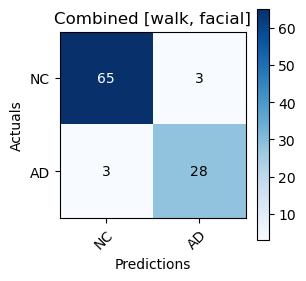

------------------------------ Seed_value=[42], Combined [sitstand, turn] ------------------------------
Combined [sitstand, turn] pid 8 NOT exist.
Combined [sitstand, turn] pid 14 NOT exist.
Combined [sitstand, turn] pid 15 NOT exist.
Combined [sitstand, turn] pid 23 NOT exist.
Combined [sitstand, turn] pid 42 NOT exist.
Combined [sitstand, turn] pid 47 NOT exist.
Combined [sitstand, turn] pid 50 NOT exist.
Combined [sitstand, turn] pid 53 NOT exist.
Combined [sitstand, turn] pid 54 NOT exist.
Combined [sitstand, turn] pid 55 NOT exist.
Combined [sitstand, turn] pid 56 NOT exist.
0) TN: 51, FP: 7, FN: 16, TP: 14
1) Accuracy: 73.86%
2) Sensitivity (Recall): 46.67%
3) Specificity: 87.93%
4) G-Mean: 64.06%
5) Precision: 66.67%
6) F1-Score: 0.55
7) F2-Measure: 0.5
8) Number of Subjects: 88



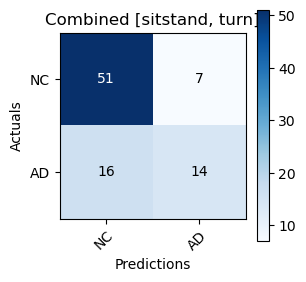

------------------------------ Seed_value=[42], Combined [sitstand, facial] ------------------------------
0) TN: 68, FP: 0, FN: 23, TP: 8
1) Accuracy: 76.77%
2) Sensitivity (Recall): 25.81%
3) Specificity: 100.0%
4) G-Mean: 50.8%
5) Precision: 100.0%
6) F1-Score: 0.41
7) F2-Measure: 0.3
8) Number of Subjects: 99



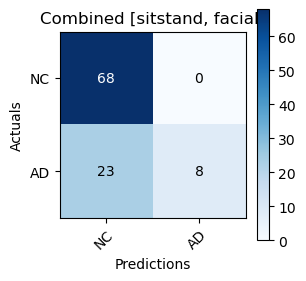

------------------------------ Seed_value=[42], Combined [turn, facial] ------------------------------
Combined [turn, facial] pid 60 NOT exist.
0) TN: 67, FP: 1, FN: 14, TP: 16
1) Accuracy: 84.69%
2) Sensitivity (Recall): 53.33%
3) Specificity: 98.53%
4) G-Mean: 72.49%
5) Precision: 94.12%
6) F1-Score: 0.68
7) F2-Measure: 0.58
8) Number of Subjects: 98



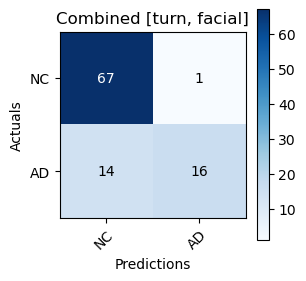

------------------------------ Seed_value=[64], Combined [walk, sitstand] ------------------------------
Combined [walk, sitstand] pid 8 NOT exist.
Combined [walk, sitstand] pid 14 NOT exist.
Combined [walk, sitstand] pid 15 NOT exist.
Combined [walk, sitstand] pid 23 NOT exist.
Combined [walk, sitstand] pid 42 NOT exist.
Combined [walk, sitstand] pid 47 NOT exist.
Combined [walk, sitstand] pid 50 NOT exist.
Combined [walk, sitstand] pid 53 NOT exist.
Combined [walk, sitstand] pid 54 NOT exist.
Combined [walk, sitstand] pid 55 NOT exist.
Combined [walk, sitstand] pid 56 NOT exist.
0) TN: 55, FP: 3, FN: 0, TP: 30
1) Accuracy: 96.59%
2) Sensitivity (Recall): 100.0%
3) Specificity: 94.83%
4) G-Mean: 97.38%
5) Precision: 90.91%
6) F1-Score: 0.95
7) F2-Measure: 0.98
8) Number of Subjects: 88



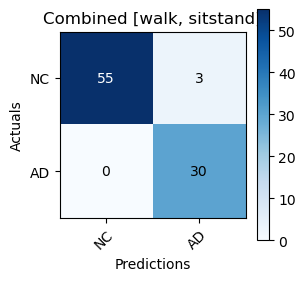

------------------------------ Seed_value=[64], Combined [walk, turn] ------------------------------
Combined [walk, turn] pid 8 NOT exist.
Combined [walk, turn] pid 14 NOT exist.
Combined [walk, turn] pid 15 NOT exist.
Combined [walk, turn] pid 23 NOT exist.
Combined [walk, turn] pid 42 NOT exist.
Combined [walk, turn] pid 47 NOT exist.
Combined [walk, turn] pid 50 NOT exist.
Combined [walk, turn] pid 53 NOT exist.
Combined [walk, turn] pid 54 NOT exist.
Combined [walk, turn] pid 55 NOT exist.
Combined [walk, turn] pid 56 NOT exist.
0) TN: 54, FP: 4, FN: 2, TP: 28
1) Accuracy: 93.18%
2) Sensitivity (Recall): 93.33%
3) Specificity: 93.1%
4) G-Mean: 93.21%
5) Precision: 87.5%
6) F1-Score: 0.9
7) F2-Measure: 0.92
8) Number of Subjects: 88



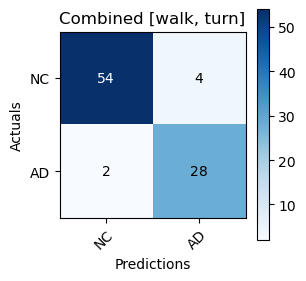

------------------------------ Seed_value=[64], Combined [walk, facial] ------------------------------
0) TN: 64, FP: 4, FN: 0, TP: 31
1) Accuracy: 95.96%
2) Sensitivity (Recall): 100.0%
3) Specificity: 94.12%
4) G-Mean: 97.02%
5) Precision: 88.57%
6) F1-Score: 0.94
7) F2-Measure: 0.97
8) Number of Subjects: 99



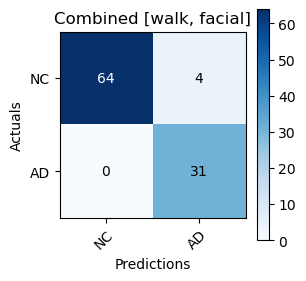

------------------------------ Seed_value=[64], Combined [sitstand, turn] ------------------------------
Combined [sitstand, turn] pid 8 NOT exist.
Combined [sitstand, turn] pid 14 NOT exist.
Combined [sitstand, turn] pid 15 NOT exist.
Combined [sitstand, turn] pid 23 NOT exist.
Combined [sitstand, turn] pid 42 NOT exist.
Combined [sitstand, turn] pid 47 NOT exist.
Combined [sitstand, turn] pid 50 NOT exist.
Combined [sitstand, turn] pid 53 NOT exist.
Combined [sitstand, turn] pid 54 NOT exist.
Combined [sitstand, turn] pid 55 NOT exist.
Combined [sitstand, turn] pid 56 NOT exist.
0) TN: 52, FP: 6, FN: 15, TP: 15
1) Accuracy: 76.14%
2) Sensitivity (Recall): 50.0%
3) Specificity: 89.66%
4) G-Mean: 66.96%
5) Precision: 71.43%
6) F1-Score: 0.59
7) F2-Measure: 0.53
8) Number of Subjects: 88



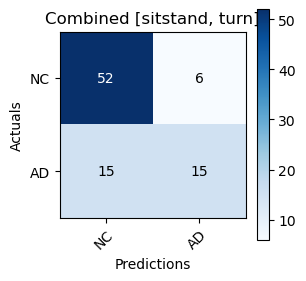

------------------------------ Seed_value=[64], Combined [sitstand, facial] ------------------------------
0) TN: 67, FP: 1, FN: 24, TP: 7
1) Accuracy: 74.75%
2) Sensitivity (Recall): 22.58%
3) Specificity: 98.53%
4) G-Mean: 47.17%
5) Precision: 87.5%
6) F1-Score: 0.36
7) F2-Measure: 0.27
8) Number of Subjects: 99



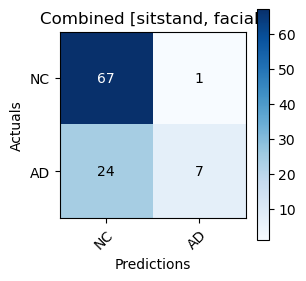

------------------------------ Seed_value=[64], Combined [turn, facial] ------------------------------
Combined [turn, facial] pid 60 NOT exist.
0) TN: 64, FP: 4, FN: 15, TP: 15
1) Accuracy: 80.61%
2) Sensitivity (Recall): 50.0%
3) Specificity: 94.12%
4) G-Mean: 68.6%
5) Precision: 78.95%
6) F1-Score: 0.61
7) F2-Measure: 0.54
8) Number of Subjects: 98



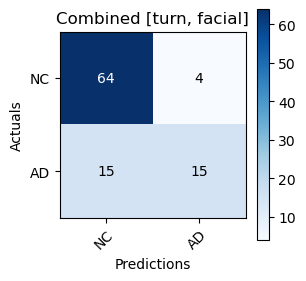

------------------------------ Seed_value=[100], Combined [walk, sitstand] ------------------------------
Combined [walk, sitstand] pid 8 NOT exist.
Combined [walk, sitstand] pid 14 NOT exist.
Combined [walk, sitstand] pid 15 NOT exist.
Combined [walk, sitstand] pid 23 NOT exist.
Combined [walk, sitstand] pid 42 NOT exist.
Combined [walk, sitstand] pid 47 NOT exist.
Combined [walk, sitstand] pid 50 NOT exist.
Combined [walk, sitstand] pid 53 NOT exist.
Combined [walk, sitstand] pid 54 NOT exist.
Combined [walk, sitstand] pid 55 NOT exist.
Combined [walk, sitstand] pid 56 NOT exist.
0) TN: 55, FP: 3, FN: 0, TP: 30
1) Accuracy: 96.59%
2) Sensitivity (Recall): 100.0%
3) Specificity: 94.83%
4) G-Mean: 97.38%
5) Precision: 90.91%
6) F1-Score: 0.95
7) F2-Measure: 0.98
8) Number of Subjects: 88



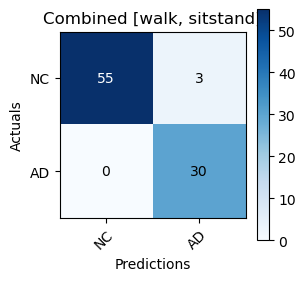

------------------------------ Seed_value=[100], Combined [walk, turn] ------------------------------
Combined [walk, turn] pid 8 NOT exist.
Combined [walk, turn] pid 14 NOT exist.
Combined [walk, turn] pid 15 NOT exist.
Combined [walk, turn] pid 23 NOT exist.
Combined [walk, turn] pid 42 NOT exist.
Combined [walk, turn] pid 47 NOT exist.
Combined [walk, turn] pid 50 NOT exist.
Combined [walk, turn] pid 53 NOT exist.
Combined [walk, turn] pid 54 NOT exist.
Combined [walk, turn] pid 55 NOT exist.
Combined [walk, turn] pid 56 NOT exist.
0) TN: 55, FP: 3, FN: 1, TP: 29
1) Accuracy: 95.45%
2) Sensitivity (Recall): 96.67%
3) Specificity: 94.83%
4) G-Mean: 95.75%
5) Precision: 90.62%
6) F1-Score: 0.94
7) F2-Measure: 0.95
8) Number of Subjects: 88



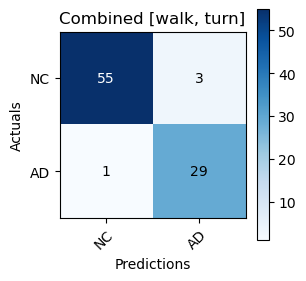

------------------------------ Seed_value=[100], Combined [walk, facial] ------------------------------
0) TN: 66, FP: 2, FN: 2, TP: 29
1) Accuracy: 95.96%
2) Sensitivity (Recall): 93.55%
3) Specificity: 97.06%
4) G-Mean: 95.29%
5) Precision: 93.55%
6) F1-Score: 0.94
7) F2-Measure: 0.94
8) Number of Subjects: 99



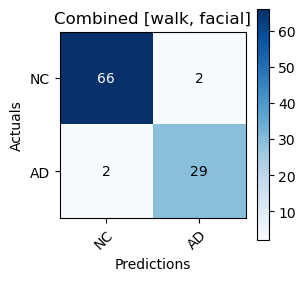

------------------------------ Seed_value=[100], Combined [sitstand, turn] ------------------------------
Combined [sitstand, turn] pid 8 NOT exist.
Combined [sitstand, turn] pid 14 NOT exist.
Combined [sitstand, turn] pid 15 NOT exist.
Combined [sitstand, turn] pid 23 NOT exist.
Combined [sitstand, turn] pid 42 NOT exist.
Combined [sitstand, turn] pid 47 NOT exist.
Combined [sitstand, turn] pid 50 NOT exist.
Combined [sitstand, turn] pid 53 NOT exist.
Combined [sitstand, turn] pid 54 NOT exist.
Combined [sitstand, turn] pid 55 NOT exist.
Combined [sitstand, turn] pid 56 NOT exist.
0) TN: 51, FP: 7, FN: 18, TP: 12
1) Accuracy: 71.59%
2) Sensitivity (Recall): 40.0%
3) Specificity: 87.93%
4) G-Mean: 59.31%
5) Precision: 63.16%
6) F1-Score: 0.49
7) F2-Measure: 0.43
8) Number of Subjects: 88



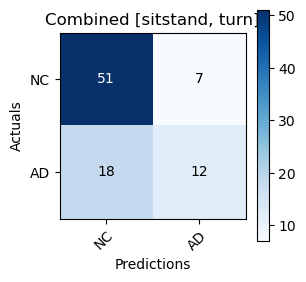

------------------------------ Seed_value=[100], Combined [sitstand, facial] ------------------------------
0) TN: 68, FP: 0, FN: 24, TP: 7
1) Accuracy: 75.76%
2) Sensitivity (Recall): 22.58%
3) Specificity: 100.0%
4) G-Mean: 47.52%
5) Precision: 100.0%
6) F1-Score: 0.37
7) F2-Measure: 0.27
8) Number of Subjects: 99



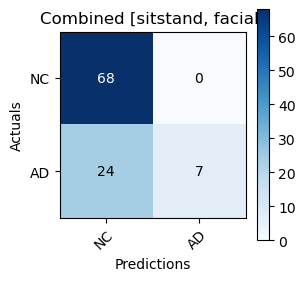

------------------------------ Seed_value=[100], Combined [turn, facial] ------------------------------
Combined [turn, facial] pid 60 NOT exist.
0) TN: 66, FP: 2, FN: 16, TP: 14
1) Accuracy: 81.63%
2) Sensitivity (Recall): 46.67%
3) Specificity: 97.06%
4) G-Mean: 67.3%
5) Precision: 87.5%
6) F1-Score: 0.61
7) F2-Measure: 0.51
8) Number of Subjects: 98



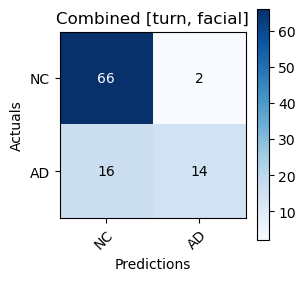

------------------------------ Seed_value=[123], Combined [walk, sitstand] ------------------------------
Combined [walk, sitstand] pid 8 NOT exist.
Combined [walk, sitstand] pid 14 NOT exist.
Combined [walk, sitstand] pid 15 NOT exist.
Combined [walk, sitstand] pid 23 NOT exist.
Combined [walk, sitstand] pid 42 NOT exist.
Combined [walk, sitstand] pid 47 NOT exist.
Combined [walk, sitstand] pid 50 NOT exist.
Combined [walk, sitstand] pid 53 NOT exist.
Combined [walk, sitstand] pid 54 NOT exist.
Combined [walk, sitstand] pid 55 NOT exist.
Combined [walk, sitstand] pid 56 NOT exist.
0) TN: 53, FP: 5, FN: 1, TP: 29
1) Accuracy: 93.18%
2) Sensitivity (Recall): 96.67%
3) Specificity: 91.38%
4) G-Mean: 93.99%
5) Precision: 85.29%
6) F1-Score: 0.91
7) F2-Measure: 0.94
8) Number of Subjects: 88



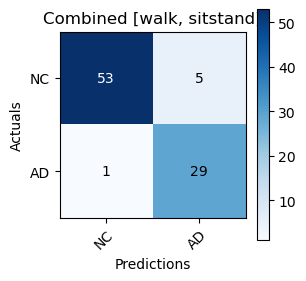

------------------------------ Seed_value=[123], Combined [walk, turn] ------------------------------
Combined [walk, turn] pid 8 NOT exist.
Combined [walk, turn] pid 14 NOT exist.
Combined [walk, turn] pid 15 NOT exist.
Combined [walk, turn] pid 23 NOT exist.
Combined [walk, turn] pid 42 NOT exist.
Combined [walk, turn] pid 47 NOT exist.
Combined [walk, turn] pid 50 NOT exist.
Combined [walk, turn] pid 53 NOT exist.
Combined [walk, turn] pid 54 NOT exist.
Combined [walk, turn] pid 55 NOT exist.
Combined [walk, turn] pid 56 NOT exist.
0) TN: 54, FP: 4, FN: 2, TP: 28
1) Accuracy: 93.18%
2) Sensitivity (Recall): 93.33%
3) Specificity: 93.1%
4) G-Mean: 93.21%
5) Precision: 87.5%
6) F1-Score: 0.9
7) F2-Measure: 0.92
8) Number of Subjects: 88



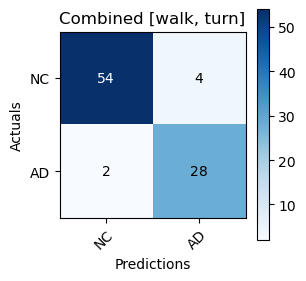

------------------------------ Seed_value=[123], Combined [walk, facial] ------------------------------
0) TN: 62, FP: 6, FN: 3, TP: 28
1) Accuracy: 90.91%
2) Sensitivity (Recall): 90.32%
3) Specificity: 91.18%
4) G-Mean: 90.75%
5) Precision: 82.35%
6) F1-Score: 0.86
7) F2-Measure: 0.89
8) Number of Subjects: 99



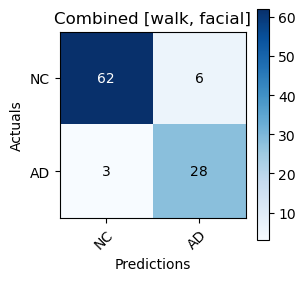

------------------------------ Seed_value=[123], Combined [sitstand, turn] ------------------------------
Combined [sitstand, turn] pid 8 NOT exist.
Combined [sitstand, turn] pid 14 NOT exist.
Combined [sitstand, turn] pid 15 NOT exist.
Combined [sitstand, turn] pid 23 NOT exist.
Combined [sitstand, turn] pid 42 NOT exist.
Combined [sitstand, turn] pid 47 NOT exist.
Combined [sitstand, turn] pid 50 NOT exist.
Combined [sitstand, turn] pid 53 NOT exist.
Combined [sitstand, turn] pid 54 NOT exist.
Combined [sitstand, turn] pid 55 NOT exist.
Combined [sitstand, turn] pid 56 NOT exist.
0) TN: 52, FP: 6, FN: 15, TP: 15
1) Accuracy: 76.14%
2) Sensitivity (Recall): 50.0%
3) Specificity: 89.66%
4) G-Mean: 66.96%
5) Precision: 71.43%
6) F1-Score: 0.59
7) F2-Measure: 0.53
8) Number of Subjects: 88



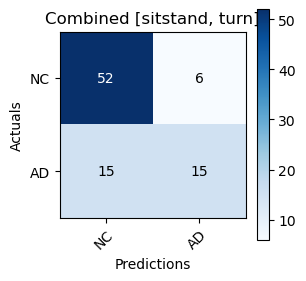

------------------------------ Seed_value=[123], Combined [sitstand, facial] ------------------------------
0) TN: 65, FP: 3, FN: 25, TP: 6
1) Accuracy: 71.72%
2) Sensitivity (Recall): 19.35%
3) Specificity: 95.59%
4) G-Mean: 43.01%
5) Precision: 66.67%
6) F1-Score: 0.3
7) F2-Measure: 0.23
8) Number of Subjects: 99



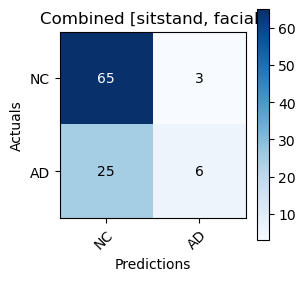

------------------------------ Seed_value=[123], Combined [turn, facial] ------------------------------
Combined [turn, facial] pid 60 NOT exist.
0) TN: 62, FP: 6, FN: 16, TP: 14
1) Accuracy: 77.55%
2) Sensitivity (Recall): 46.67%
3) Specificity: 91.18%
4) G-Mean: 65.23%
5) Precision: 70.0%
6) F1-Score: 0.56
7) F2-Measure: 0.5
8) Number of Subjects: 98



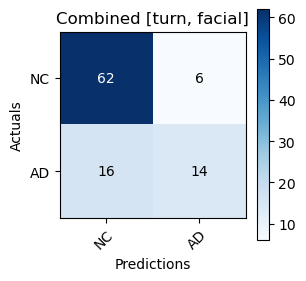

------------------------------ Seed_value=[200], Combined [walk, sitstand] ------------------------------
Combined [walk, sitstand] pid 8 NOT exist.
Combined [walk, sitstand] pid 14 NOT exist.
Combined [walk, sitstand] pid 15 NOT exist.
Combined [walk, sitstand] pid 23 NOT exist.
Combined [walk, sitstand] pid 42 NOT exist.
Combined [walk, sitstand] pid 47 NOT exist.
Combined [walk, sitstand] pid 50 NOT exist.
Combined [walk, sitstand] pid 53 NOT exist.
Combined [walk, sitstand] pid 54 NOT exist.
Combined [walk, sitstand] pid 55 NOT exist.
Combined [walk, sitstand] pid 56 NOT exist.
0) TN: 51, FP: 7, FN: 1, TP: 29
1) Accuracy: 90.91%
2) Sensitivity (Recall): 96.67%
3) Specificity: 87.93%
4) G-Mean: 92.2%
5) Precision: 80.56%
6) F1-Score: 0.88
7) F2-Measure: 0.93
8) Number of Subjects: 88



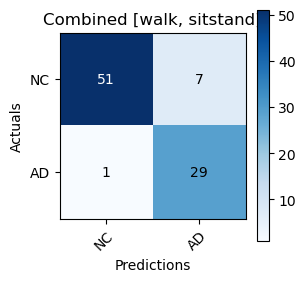

------------------------------ Seed_value=[200], Combined [walk, turn] ------------------------------
Combined [walk, turn] pid 8 NOT exist.
Combined [walk, turn] pid 14 NOT exist.
Combined [walk, turn] pid 15 NOT exist.
Combined [walk, turn] pid 23 NOT exist.
Combined [walk, turn] pid 42 NOT exist.
Combined [walk, turn] pid 47 NOT exist.
Combined [walk, turn] pid 50 NOT exist.
Combined [walk, turn] pid 53 NOT exist.
Combined [walk, turn] pid 54 NOT exist.
Combined [walk, turn] pid 55 NOT exist.
Combined [walk, turn] pid 56 NOT exist.
0) TN: 52, FP: 6, FN: 2, TP: 28
1) Accuracy: 90.91%
2) Sensitivity (Recall): 93.33%
3) Specificity: 89.66%
4) G-Mean: 91.48%
5) Precision: 82.35%
6) F1-Score: 0.87
7) F2-Measure: 0.91
8) Number of Subjects: 88



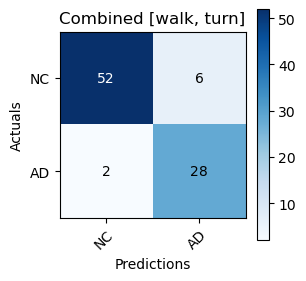

------------------------------ Seed_value=[200], Combined [walk, facial] ------------------------------
0) TN: 62, FP: 6, FN: 3, TP: 28
1) Accuracy: 90.91%
2) Sensitivity (Recall): 90.32%
3) Specificity: 91.18%
4) G-Mean: 90.75%
5) Precision: 82.35%
6) F1-Score: 0.86
7) F2-Measure: 0.89
8) Number of Subjects: 99



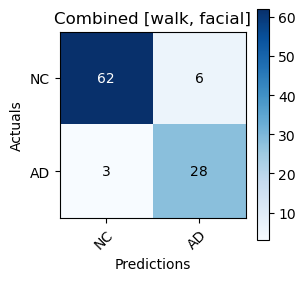

------------------------------ Seed_value=[200], Combined [sitstand, turn] ------------------------------
Combined [sitstand, turn] pid 8 NOT exist.
Combined [sitstand, turn] pid 14 NOT exist.
Combined [sitstand, turn] pid 15 NOT exist.
Combined [sitstand, turn] pid 23 NOT exist.
Combined [sitstand, turn] pid 42 NOT exist.
Combined [sitstand, turn] pid 47 NOT exist.
Combined [sitstand, turn] pid 50 NOT exist.
Combined [sitstand, turn] pid 53 NOT exist.
Combined [sitstand, turn] pid 54 NOT exist.
Combined [sitstand, turn] pid 55 NOT exist.
Combined [sitstand, turn] pid 56 NOT exist.
0) TN: 53, FP: 5, FN: 18, TP: 12
1) Accuracy: 73.86%
2) Sensitivity (Recall): 40.0%
3) Specificity: 91.38%
4) G-Mean: 60.46%
5) Precision: 70.59%
6) F1-Score: 0.51
7) F2-Measure: 0.44
8) Number of Subjects: 88



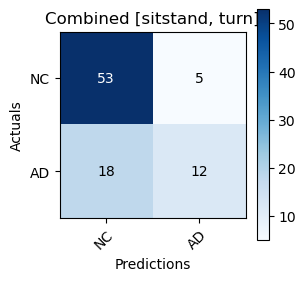

------------------------------ Seed_value=[200], Combined [sitstand, facial] ------------------------------
0) TN: 67, FP: 1, FN: 26, TP: 5
1) Accuracy: 72.73%
2) Sensitivity (Recall): 16.13%
3) Specificity: 98.53%
4) G-Mean: 39.87%
5) Precision: 83.33%
6) F1-Score: 0.27
7) F2-Measure: 0.19
8) Number of Subjects: 99



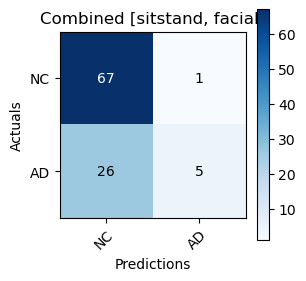

------------------------------ Seed_value=[200], Combined [turn, facial] ------------------------------
Combined [turn, facial] pid 60 NOT exist.
0) TN: 66, FP: 2, FN: 14, TP: 16
1) Accuracy: 83.67%
2) Sensitivity (Recall): 53.33%
3) Specificity: 97.06%
4) G-Mean: 71.95%
5) Precision: 88.89%
6) F1-Score: 0.67
7) F2-Measure: 0.58
8) Number of Subjects: 98



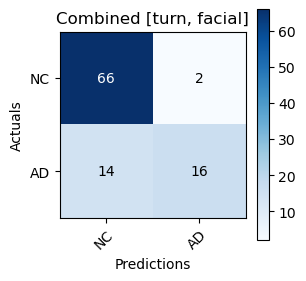

------------------------------ Seed_value=[456], Combined [walk, sitstand] ------------------------------
Combined [walk, sitstand] pid 8 NOT exist.
Combined [walk, sitstand] pid 14 NOT exist.
Combined [walk, sitstand] pid 15 NOT exist.
Combined [walk, sitstand] pid 23 NOT exist.
Combined [walk, sitstand] pid 42 NOT exist.
Combined [walk, sitstand] pid 47 NOT exist.
Combined [walk, sitstand] pid 50 NOT exist.
Combined [walk, sitstand] pid 53 NOT exist.
Combined [walk, sitstand] pid 54 NOT exist.
Combined [walk, sitstand] pid 55 NOT exist.
Combined [walk, sitstand] pid 56 NOT exist.
0) TN: 51, FP: 7, FN: 0, TP: 30
1) Accuracy: 92.05%
2) Sensitivity (Recall): 100.0%
3) Specificity: 87.93%
4) G-Mean: 93.77%
5) Precision: 81.08%
6) F1-Score: 0.9
7) F2-Measure: 0.96
8) Number of Subjects: 88



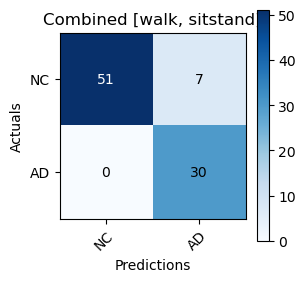

------------------------------ Seed_value=[456], Combined [walk, turn] ------------------------------
Combined [walk, turn] pid 8 NOT exist.
Combined [walk, turn] pid 14 NOT exist.
Combined [walk, turn] pid 15 NOT exist.
Combined [walk, turn] pid 23 NOT exist.
Combined [walk, turn] pid 42 NOT exist.
Combined [walk, turn] pid 47 NOT exist.
Combined [walk, turn] pid 50 NOT exist.
Combined [walk, turn] pid 53 NOT exist.
Combined [walk, turn] pid 54 NOT exist.
Combined [walk, turn] pid 55 NOT exist.
Combined [walk, turn] pid 56 NOT exist.
0) TN: 54, FP: 4, FN: 3, TP: 27
1) Accuracy: 92.05%
2) Sensitivity (Recall): 90.0%
3) Specificity: 93.1%
4) G-Mean: 91.54%
5) Precision: 87.1%
6) F1-Score: 0.89
7) F2-Measure: 0.89
8) Number of Subjects: 88



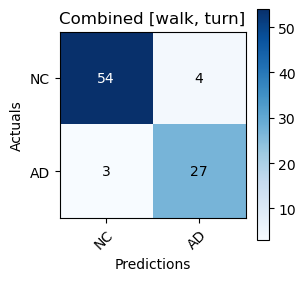

------------------------------ Seed_value=[456], Combined [walk, facial] ------------------------------
0) TN: 65, FP: 3, FN: 2, TP: 29
1) Accuracy: 94.95%
2) Sensitivity (Recall): 93.55%
3) Specificity: 95.59%
4) G-Mean: 94.56%
5) Precision: 90.62%
6) F1-Score: 0.92
7) F2-Measure: 0.93
8) Number of Subjects: 99



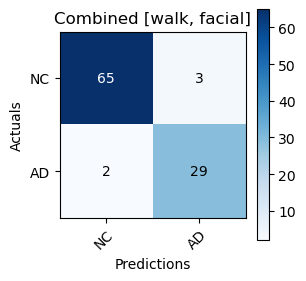

------------------------------ Seed_value=[456], Combined [sitstand, turn] ------------------------------
Combined [sitstand, turn] pid 8 NOT exist.
Combined [sitstand, turn] pid 14 NOT exist.
Combined [sitstand, turn] pid 15 NOT exist.
Combined [sitstand, turn] pid 23 NOT exist.
Combined [sitstand, turn] pid 42 NOT exist.
Combined [sitstand, turn] pid 47 NOT exist.
Combined [sitstand, turn] pid 50 NOT exist.
Combined [sitstand, turn] pid 53 NOT exist.
Combined [sitstand, turn] pid 54 NOT exist.
Combined [sitstand, turn] pid 55 NOT exist.
Combined [sitstand, turn] pid 56 NOT exist.
0) TN: 52, FP: 6, FN: 16, TP: 14
1) Accuracy: 75.0%
2) Sensitivity (Recall): 46.67%
3) Specificity: 89.66%
4) G-Mean: 64.69%
5) Precision: 70.0%
6) F1-Score: 0.56
7) F2-Measure: 0.5
8) Number of Subjects: 88



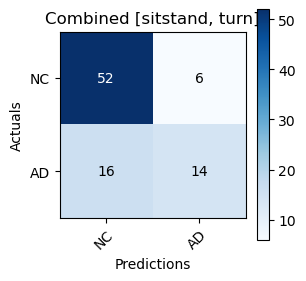

------------------------------ Seed_value=[456], Combined [sitstand, facial] ------------------------------
0) TN: 65, FP: 3, FN: 25, TP: 6
1) Accuracy: 71.72%
2) Sensitivity (Recall): 19.35%
3) Specificity: 95.59%
4) G-Mean: 43.01%
5) Precision: 66.67%
6) F1-Score: 0.3
7) F2-Measure: 0.23
8) Number of Subjects: 99



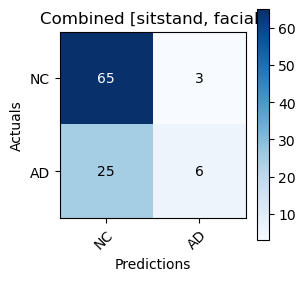

------------------------------ Seed_value=[456], Combined [turn, facial] ------------------------------
Combined [turn, facial] pid 60 NOT exist.
0) TN: 63, FP: 5, FN: 14, TP: 16
1) Accuracy: 80.61%
2) Sensitivity (Recall): 53.33%
3) Specificity: 92.65%
4) G-Mean: 70.29%
5) Precision: 76.19%
6) F1-Score: 0.63
7) F2-Measure: 0.57
8) Number of Subjects: 98



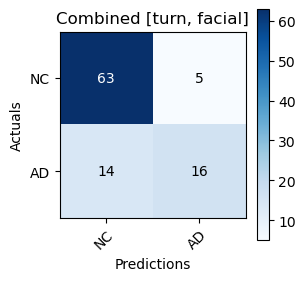

------------------------------ Seed_value=[1001], Combined [walk, sitstand] ------------------------------
Combined [walk, sitstand] pid 8 NOT exist.
Combined [walk, sitstand] pid 14 NOT exist.
Combined [walk, sitstand] pid 15 NOT exist.
Combined [walk, sitstand] pid 23 NOT exist.
Combined [walk, sitstand] pid 42 NOT exist.
Combined [walk, sitstand] pid 47 NOT exist.
Combined [walk, sitstand] pid 50 NOT exist.
Combined [walk, sitstand] pid 53 NOT exist.
Combined [walk, sitstand] pid 54 NOT exist.
Combined [walk, sitstand] pid 55 NOT exist.
Combined [walk, sitstand] pid 56 NOT exist.
0) TN: 51, FP: 7, FN: 1, TP: 29
1) Accuracy: 90.91%
2) Sensitivity (Recall): 96.67%
3) Specificity: 87.93%
4) G-Mean: 92.2%
5) Precision: 80.56%
6) F1-Score: 0.88
7) F2-Measure: 0.93
8) Number of Subjects: 88



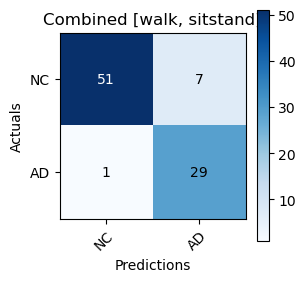

------------------------------ Seed_value=[1001], Combined [walk, turn] ------------------------------
Combined [walk, turn] pid 8 NOT exist.
Combined [walk, turn] pid 14 NOT exist.
Combined [walk, turn] pid 15 NOT exist.
Combined [walk, turn] pid 23 NOT exist.
Combined [walk, turn] pid 42 NOT exist.
Combined [walk, turn] pid 47 NOT exist.
Combined [walk, turn] pid 50 NOT exist.
Combined [walk, turn] pid 53 NOT exist.
Combined [walk, turn] pid 54 NOT exist.
Combined [walk, turn] pid 55 NOT exist.
Combined [walk, turn] pid 56 NOT exist.
0) TN: 53, FP: 5, FN: 2, TP: 28
1) Accuracy: 92.05%
2) Sensitivity (Recall): 93.33%
3) Specificity: 91.38%
4) G-Mean: 92.35%
5) Precision: 84.85%
6) F1-Score: 0.89
7) F2-Measure: 0.92
8) Number of Subjects: 88



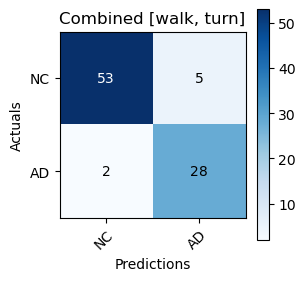

------------------------------ Seed_value=[1001], Combined [walk, facial] ------------------------------
0) TN: 62, FP: 6, FN: 2, TP: 29
1) Accuracy: 91.92%
2) Sensitivity (Recall): 93.55%
3) Specificity: 91.18%
4) G-Mean: 92.36%
5) Precision: 82.86%
6) F1-Score: 0.88
7) F2-Measure: 0.91
8) Number of Subjects: 99



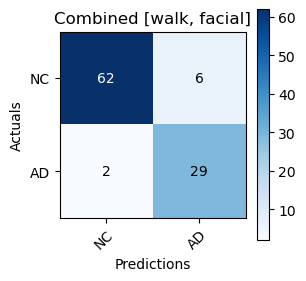

------------------------------ Seed_value=[1001], Combined [sitstand, turn] ------------------------------
Combined [sitstand, turn] pid 8 NOT exist.
Combined [sitstand, turn] pid 14 NOT exist.
Combined [sitstand, turn] pid 15 NOT exist.
Combined [sitstand, turn] pid 23 NOT exist.
Combined [sitstand, turn] pid 42 NOT exist.
Combined [sitstand, turn] pid 47 NOT exist.
Combined [sitstand, turn] pid 50 NOT exist.
Combined [sitstand, turn] pid 53 NOT exist.
Combined [sitstand, turn] pid 54 NOT exist.
Combined [sitstand, turn] pid 55 NOT exist.
Combined [sitstand, turn] pid 56 NOT exist.
0) TN: 53, FP: 5, FN: 15, TP: 15
1) Accuracy: 77.27%
2) Sensitivity (Recall): 50.0%
3) Specificity: 91.38%
4) G-Mean: 67.59%
5) Precision: 75.0%
6) F1-Score: 0.6
7) F2-Measure: 0.54
8) Number of Subjects: 88



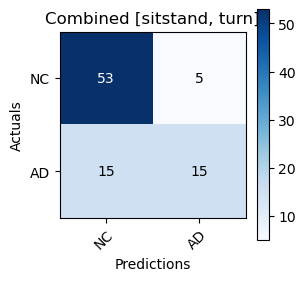

------------------------------ Seed_value=[1001], Combined [sitstand, facial] ------------------------------
0) TN: 65, FP: 3, FN: 23, TP: 8
1) Accuracy: 73.74%
2) Sensitivity (Recall): 25.81%
3) Specificity: 95.59%
4) G-Mean: 49.67%
5) Precision: 72.73%
6) F1-Score: 0.38
7) F2-Measure: 0.3
8) Number of Subjects: 99



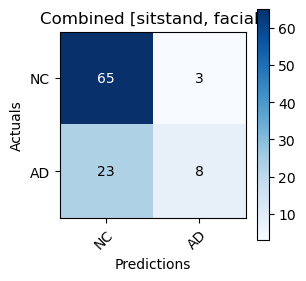

------------------------------ Seed_value=[1001], Combined [turn, facial] ------------------------------
Combined [turn, facial] pid 60 NOT exist.
0) TN: 62, FP: 6, FN: 11, TP: 19
1) Accuracy: 82.65%
2) Sensitivity (Recall): 63.33%
3) Specificity: 91.18%
4) G-Mean: 75.99%
5) Precision: 76.0%
6) F1-Score: 0.69
7) F2-Measure: 0.66
8) Number of Subjects: 98



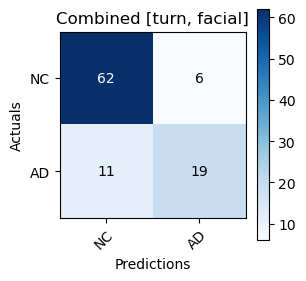

------------------------------ Seed_value=[12321], Combined [walk, sitstand] ------------------------------
Combined [walk, sitstand] pid 8 NOT exist.
Combined [walk, sitstand] pid 14 NOT exist.
Combined [walk, sitstand] pid 15 NOT exist.
Combined [walk, sitstand] pid 23 NOT exist.
Combined [walk, sitstand] pid 42 NOT exist.
Combined [walk, sitstand] pid 47 NOT exist.
Combined [walk, sitstand] pid 50 NOT exist.
Combined [walk, sitstand] pid 53 NOT exist.
Combined [walk, sitstand] pid 54 NOT exist.
Combined [walk, sitstand] pid 55 NOT exist.
Combined [walk, sitstand] pid 56 NOT exist.
0) TN: 54, FP: 4, FN: 1, TP: 29
1) Accuracy: 94.32%
2) Sensitivity (Recall): 96.67%
3) Specificity: 93.1%
4) G-Mean: 94.87%
5) Precision: 87.88%
6) F1-Score: 0.92
7) F2-Measure: 0.95
8) Number of Subjects: 88



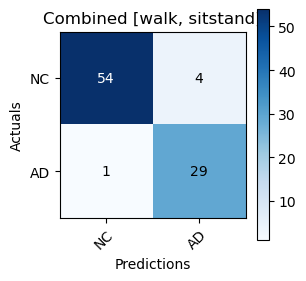

------------------------------ Seed_value=[12321], Combined [walk, turn] ------------------------------
Combined [walk, turn] pid 8 NOT exist.
Combined [walk, turn] pid 14 NOT exist.
Combined [walk, turn] pid 15 NOT exist.
Combined [walk, turn] pid 23 NOT exist.
Combined [walk, turn] pid 42 NOT exist.
Combined [walk, turn] pid 47 NOT exist.
Combined [walk, turn] pid 50 NOT exist.
Combined [walk, turn] pid 53 NOT exist.
Combined [walk, turn] pid 54 NOT exist.
Combined [walk, turn] pid 55 NOT exist.
Combined [walk, turn] pid 56 NOT exist.
0) TN: 55, FP: 3, FN: 3, TP: 27
1) Accuracy: 93.18%
2) Sensitivity (Recall): 90.0%
3) Specificity: 94.83%
4) G-Mean: 92.38%
5) Precision: 90.0%
6) F1-Score: 0.9
7) F2-Measure: 0.9
8) Number of Subjects: 88



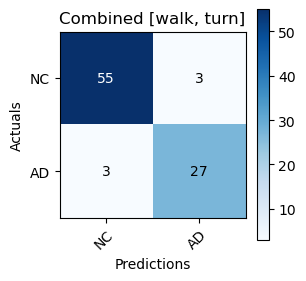

------------------------------ Seed_value=[12321], Combined [walk, facial] ------------------------------
0) TN: 64, FP: 4, FN: 3, TP: 28
1) Accuracy: 92.93%
2) Sensitivity (Recall): 90.32%
3) Specificity: 94.12%
4) G-Mean: 92.2%
5) Precision: 87.5%
6) F1-Score: 0.89
7) F2-Measure: 0.9
8) Number of Subjects: 99



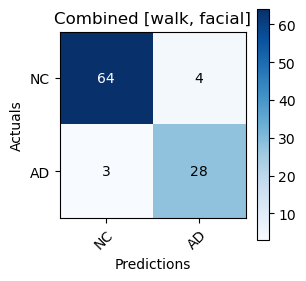

------------------------------ Seed_value=[12321], Combined [sitstand, turn] ------------------------------
Combined [sitstand, turn] pid 8 NOT exist.
Combined [sitstand, turn] pid 14 NOT exist.
Combined [sitstand, turn] pid 15 NOT exist.
Combined [sitstand, turn] pid 23 NOT exist.
Combined [sitstand, turn] pid 42 NOT exist.
Combined [sitstand, turn] pid 47 NOT exist.
Combined [sitstand, turn] pid 50 NOT exist.
Combined [sitstand, turn] pid 53 NOT exist.
Combined [sitstand, turn] pid 54 NOT exist.
Combined [sitstand, turn] pid 55 NOT exist.
Combined [sitstand, turn] pid 56 NOT exist.
0) TN: 51, FP: 7, FN: 18, TP: 12
1) Accuracy: 71.59%
2) Sensitivity (Recall): 40.0%
3) Specificity: 87.93%
4) G-Mean: 59.31%
5) Precision: 63.16%
6) F1-Score: 0.49
7) F2-Measure: 0.43
8) Number of Subjects: 88



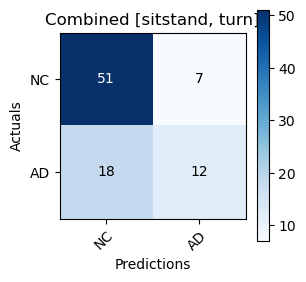

------------------------------ Seed_value=[12321], Combined [sitstand, facial] ------------------------------
0) TN: 66, FP: 2, FN: 24, TP: 7
1) Accuracy: 73.74%
2) Sensitivity (Recall): 22.58%
3) Specificity: 97.06%
4) G-Mean: 46.81%
5) Precision: 77.78%
6) F1-Score: 0.35
7) F2-Measure: 0.26
8) Number of Subjects: 99



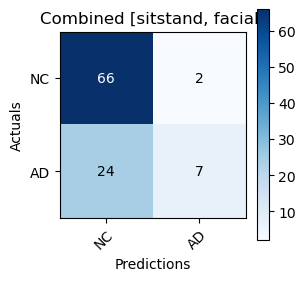

------------------------------ Seed_value=[12321], Combined [turn, facial] ------------------------------
Combined [turn, facial] pid 60 NOT exist.
0) TN: 64, FP: 4, FN: 16, TP: 14
1) Accuracy: 79.59%
2) Sensitivity (Recall): 46.67%
3) Specificity: 94.12%
4) G-Mean: 66.28%
5) Precision: 77.78%
6) F1-Score: 0.58
7) F2-Measure: 0.51
8) Number of Subjects: 98



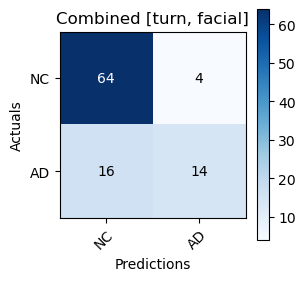

In [33]:
# twoSubtask_weighted_result_dict = combination_result_with_2_subtask(all_pid_list, subtask_combination, seed_value)
combination_result_with_2_subtask_RandomSeed(all_pid_list, subtask_combination, seed_value_list)

In [139]:
import statistics
print(f'Accuracy    ({len(WS_accuracy)}), mean({round(statistics.mean(WS_accuracy), 2)}), std({round(statistics.pstdev(WS_accuracy), 2)}): {WS_accuracy}')
print(f'Sensitivity ({len(WS_sensitivity)}), mean({round(statistics.mean(WS_sensitivity), 2)}), std({round(statistics.pstdev(WS_sensitivity), 2)}): {WS_sensitivity}')
print(f'Specificity ({len(WS_specificity)}), mean({round(statistics.mean(WS_specificity), 2)}), std({round(statistics.pstdev(WS_specificity), 2)}): {WS_specificity}')
print(f'Precision   ({len(WS_precision)}), mean({round(statistics.mean(WS_precision), 2)}), std({round(statistics.pstdev(WS_precision), 2)}): {WS_precision}')
print(f'F1-Score    ({len(WS_f1score)}), mean({round(statistics.mean(WS_f1score), 2)}), std({round(statistics.pstdev(WS_f1score), 2)}): {WS_f1score}')

Accuracy    (10), mean(93.07), std(2.24): [92.05, 94.32, 89.77, 96.59, 96.59, 93.18, 90.91, 92.05, 90.91, 94.32]
Sensitivity (10), mean(97.67), std(2.13): [93.33, 100.0, 96.67, 100.0, 100.0, 96.67, 96.67, 100.0, 96.67, 96.67]
Specificity (10), mean(90.69), std(2.91): [91.38, 91.38, 86.21, 94.83, 94.83, 91.38, 87.93, 87.93, 87.93, 93.1]
Precision   (10), mean(84.61), std(4.19): [84.85, 85.71, 78.38, 90.91, 90.91, 85.29, 80.56, 81.08, 80.56, 87.88]
F1-Score    (10), mean(0.91), std(0.03): [0.89, 0.92, 0.87, 0.95, 0.95, 0.91, 0.88, 0.9, 0.88, 0.92]


In [140]:
print(f'Accuracy    ({len(WT_accuracy)}), mean({round(statistics.mean(WT_accuracy), 2)}), std({round(statistics.pstdev(WT_accuracy), 2)}): {WT_accuracy}')
print(f'Sensitivity ({len(WT_sensitivity)}), mean({round(statistics.mean(WT_sensitivity), 2)}), std({round(statistics.pstdev(WT_sensitivity), 2)}): {WT_sensitivity}')
print(f'Specificity ({len(WT_specificity)}), mean({round(statistics.mean(WT_specificity), 2)}), std({round(statistics.pstdev(WT_specificity), 2)}): {WT_specificity}')
print(f'Precision   ({len(WT_precision)}), mean({round(statistics.mean(WT_precision), 2)}), std({round(statistics.pstdev(WT_precision), 2)}): {WT_precision}')
print(f'F1-Score    ({len(WT_f1score)}), mean({round(statistics.mean(WT_f1score), 2)}), std({round(statistics.pstdev(WT_f1score), 2)}): {WT_f1score}')

Accuracy    (10), mean(92.73), std(1.16): [92.05, 93.18, 92.05, 93.18, 95.45, 93.18, 90.91, 92.05, 92.05, 93.18]
Sensitivity (10), mean(92.33), std(2.13): [90.0, 93.33, 90.0, 93.33, 96.67, 93.33, 93.33, 90.0, 93.33, 90.0]
Specificity (10), mean(92.93), std(1.43): [93.1, 93.1, 93.1, 93.1, 94.83, 93.1, 89.66, 93.1, 91.38, 94.83]
Precision   (10), mean(87.16), std(2.21): [87.1, 87.5, 87.1, 87.5, 90.62, 87.5, 82.35, 87.1, 84.85, 90.0]
F1-Score    (10), mean(0.9), std(0.02): [0.89, 0.9, 0.89, 0.9, 0.94, 0.9, 0.87, 0.89, 0.89, 0.9]


In [141]:
print(f'Accuracy    ({len(WF_accuracy)}), mean({round(statistics.mean(WF_accuracy), 2)}), std({round(statistics.pstdev(WF_accuracy), 2)}): {WF_accuracy}')
print(f'Sensitivity ({len(WF_sensitivity)}), mean({round(statistics.mean(WF_sensitivity), 2)}), std({round(statistics.pstdev(WF_sensitivity), 2)}): {WF_sensitivity}')
print(f'Specificity ({len(WF_specificity)}), mean({round(statistics.mean(WF_specificity), 2)}), std({round(statistics.pstdev(WF_specificity), 2)}): {WF_specificity}')
print(f'Precision   ({len(WF_precision)}), mean({round(statistics.mean(WF_precision), 2)}), std({round(statistics.pstdev(WF_precision), 2)}): {WF_precision}')
print(f'F1-Score    ({len(WF_f1score)}), mean({round(statistics.mean(WF_f1score), 2)}), std({round(statistics.pstdev(WF_f1score), 2)}): {WF_f1score}')

Accuracy    (10), mean(93.23), std(1.81): [91.92, 92.93, 93.94, 95.96, 95.96, 90.91, 90.91, 94.95, 91.92, 92.93]
Sensitivity (10), mean(92.26), std(2.96): [90.32, 90.32, 90.32, 100.0, 93.55, 90.32, 90.32, 93.55, 93.55, 90.32]
Specificity (10), mean(93.68), std(1.98): [92.65, 94.12, 95.59, 94.12, 97.06, 91.18, 91.18, 95.59, 91.18, 94.12]
Precision   (10), mean(87.05), std(3.67): [84.85, 87.5, 90.32, 88.57, 93.55, 82.35, 82.35, 90.62, 82.86, 87.5]
F1-Score    (10), mean(0.9), std(0.03): [0.87, 0.89, 0.9, 0.94, 0.94, 0.86, 0.86, 0.92, 0.88, 0.89]


In [142]:
print(f'Accuracy    ({len(ST_accuracy)}), mean({round(statistics.mean(ST_accuracy), 2)}), std({round(statistics.pstdev(ST_accuracy), 2)}): {ST_accuracy}')
print(f'Sensitivity ({len(ST_sensitivity)}), mean({round(statistics.mean(ST_sensitivity), 2)}), std({round(statistics.pstdev(ST_sensitivity), 2)}): {ST_sensitivity}')
print(f'Specificity ({len(ST_specificity)}), mean({round(statistics.mean(ST_specificity), 2)}), std({round(statistics.pstdev(ST_specificity), 2)}): {ST_specificity}')
print(f'Precision   ({len(ST_precision)}), mean({round(statistics.mean(ST_precision), 2)}), std({round(statistics.pstdev(ST_precision), 2)}): {ST_precision}')
print(f'F1-Score    ({len(ST_f1score)}), mean({round(statistics.mean(ST_f1score), 2)}), std({round(statistics.pstdev(ST_f1score), 2)}): {ST_f1score}')

Accuracy    (10), mean(75.11), std(2.56): [80.68, 75.0, 73.86, 76.14, 71.59, 76.14, 73.86, 75.0, 77.27, 71.59]
Sensitivity (10), mean(46.67), std(6.99): [63.33, 40.0, 46.67, 50.0, 40.0, 50.0, 40.0, 46.67, 50.0, 40.0]
Specificity (10), mean(89.83), std(1.63): [89.66, 93.1, 87.93, 89.66, 87.93, 89.66, 91.38, 89.66, 91.38, 87.93]
Precision   (10), mean(70.24), std(4.41): [76.0, 75.0, 66.67, 71.43, 63.16, 71.43, 70.59, 70.0, 75.0, 63.16]
F1-Score    (10), mean(0.56), std(0.06): [0.69, 0.52, 0.55, 0.59, 0.49, 0.59, 0.51, 0.56, 0.6, 0.49]


In [143]:
print(f'Accuracy    ({len(SF_accuracy)}), mean({round(statistics.mean(SF_accuracy), 2)}), std({round(statistics.pstdev(SF_accuracy), 2)}): {SF_accuracy}')
print(f'Sensitivity ({len(SF_sensitivity)}), mean({round(statistics.mean(SF_sensitivity), 2)}), std({round(statistics.pstdev(SF_sensitivity), 2)}): {SF_sensitivity}')
print(f'Specificity ({len(SF_specificity)}), mean({round(statistics.mean(SF_specificity), 2)}), std({round(statistics.pstdev(SF_specificity), 2)}): {SF_specificity}')
print(f'Precision   ({len(SF_precision)}), mean({round(statistics.mean(SF_precision), 2)}), std({round(statistics.pstdev(SF_precision), 2)}): {SF_precision}')
print(f'F1-Score    ({len(SF_f1score)}), mean({round(statistics.mean(SF_f1score), 2)}), std({round(statistics.pstdev(SF_f1score), 2)}): {SF_f1score}')

Accuracy    (10), mean(74.04), std(1.63): [75.76, 73.74, 76.77, 74.75, 75.76, 71.72, 72.73, 71.72, 73.74, 73.74]
Sensitivity (10), mean(23.55), std(5.78): [38.71, 22.58, 25.81, 22.58, 22.58, 19.35, 16.13, 19.35, 25.81, 22.58]
Specificity (10), mean(97.06), std(2.18): [92.65, 97.06, 100.0, 98.53, 100.0, 95.59, 98.53, 95.59, 95.59, 97.06]
Precision   (10), mean(80.31), std(11.72): [70.59, 77.78, 100.0, 87.5, 100.0, 66.67, 83.33, 66.67, 72.73, 77.78]
F1-Score    (10), mean(0.36), std(0.06): [0.5, 0.35, 0.41, 0.36, 0.37, 0.3, 0.27, 0.3, 0.38, 0.35]


In [144]:
print(f'Accuracy    ({len(TF_accuracy)}), mean({round(statistics.mean(TF_accuracy), 2)}), std({round(statistics.pstdev(TF_accuracy), 2)}): {TF_accuracy}')
print(f'Sensitivity ({len(TF_sensitivity)}), mean({round(statistics.mean(TF_sensitivity), 2)}), std({round(statistics.pstdev(TF_sensitivity), 2)}): {TF_sensitivity}')
print(f'Specificity ({len(TF_specificity)}), mean({round(statistics.mean(TF_specificity), 2)}), std({round(statistics.pstdev(TF_specificity), 2)}): {TF_specificity}')
print(f'Precision   ({len(TF_precision)}), mean({round(statistics.mean(TF_precision), 2)}), std({round(statistics.pstdev(TF_precision), 2)}): {TF_precision}')
print(f'F1-Score    ({len(TF_f1score)}), mean({round(statistics.mean(TF_f1score), 2)}), std({round(statistics.pstdev(TF_f1score), 2)}): {TF_f1score}')

Accuracy    (10), mean(81.53), std(2.06): [80.61, 83.67, 84.69, 80.61, 81.63, 77.55, 83.67, 80.61, 82.65, 79.59]
Sensitivity (10), mean(51.67), std(4.77): [50.0, 53.33, 53.33, 50.0, 46.67, 46.67, 53.33, 53.33, 63.33, 46.67]
Specificity (10), mean(94.71), std(2.48): [94.12, 97.06, 98.53, 94.12, 97.06, 91.18, 97.06, 92.65, 91.18, 94.12]
Precision   (10), mean(81.73), std(7.22): [78.95, 88.89, 94.12, 78.95, 87.5, 70.0, 88.89, 76.19, 76.0, 77.78]
F1-Score    (10), mean(0.63), std(0.04): [0.61, 0.67, 0.68, 0.61, 0.61, 0.56, 0.67, 0.63, 0.69, 0.58]


### 3 Subtasks

In [145]:
def get_subtask_combination():
    s1 = "walk"
    s2 = "sitstand"
    s3 = "turn"
    s4 = "facial"

    combination = []
    combination.append([s1, s2, s3])
    combination.append([s1, s2, s4])
    combination.append([s1, s3, s4])
    combination.append([s2, s3, s4])
    return combination
    
subtask_combination = get_subtask_combination()
subtask_combination

[['walk', 'sitstand', 'turn'],
 ['walk', 'sitstand', 'facial'],
 ['walk', 'turn', 'facial'],
 ['sitstand', 'turn', 'facial']]

In [146]:
WST_accuracy, WSF_accuracy, WTF_accuracy, STF_accuracy = [], [], [], []
WST_sensitivity, WSF_sensitivity, WTF_sensitivity, STF_sensitivity = [], [], [], []
WST_specificity, WSF_specificity, WTF_specificity, STF_specificity = [], [], [], []
WST_precision, WSF_precision, WTF_precision, STF_precision = [], [], [], []
WST_f1score, WSF_f1score, WTF_f1score, STF_f1score = [], [], [], []


def show_weighted_result_with_confusion_matrix_RandomSeed(task1, task2, task3, pred_list, true_list):
    predict_label_array = np.array(pred_list)
    actual_label_array = np.array(true_list)

    ### F1-Score
    # print(f'==============  Classification Report  ==============')
    # print(classification_report(actual_label_array, predict_label_array))

    ### Confusion Matrix
    matrix = confusion_matrix(actual_label_array, predict_label_array)
    TN, FP, FN, TP = matrix.ravel()

    value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    value_sensitivity = round(TP/(TP+FN), 4)
    value_specificity = round(TN/(TN+FP), 4)
    value_gmean = round(np.sqrt(value_sensitivity*value_specificity), 4)
    value_precision = round(TP/(TP+FP), 4)
    value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
    value_f2_measure = round(5*value_precision*value_sensitivity / (4*value_precision+value_sensitivity), 2)

    # print(f'==================  Performance  ====================')
    print(f'0) TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    print(f'1) Accuracy: {round(value_accuracy*100, 2)}%')
    print(f'2) Sensitivity (Recall): {round(value_sensitivity*100, 2)}%')
    print(f'3) Specificity: {round(value_specificity*100, 2)}%')
    print(f'4) G-Mean: {round(value_gmean*100, 2)}%')
    print(f'5) Precision: {round(value_precision*100, 2)}%')
    print(f'6) F1-Score: {value_f1_score}')
    print(f'7) F2-Measure: {value_f2_measure}')
    print(f'8) Number of Subjects: {len(pred_list)}\n')
    
    classList = ['NC', 'AD']
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(3, 3), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title(f'Combined [{task1}, {task2}, {task3}]', fontsize=12)
    plt.show()
    
    
    if task1=="walk" and task2=="sitstand" and task3=="turn":
        WST_accuracy.append(round(value_accuracy*100, 2))
        WST_sensitivity.append(round(value_sensitivity*100, 2))
        WST_specificity.append(round(value_specificity*100, 2))
        WST_precision.append(round(value_precision*100, 2))
        WST_f1score.append(value_f1_score)
    elif task1=="walk" and task2=="sitstand" and task3=="facial":
        WSF_accuracy.append(round(value_accuracy*100, 2))
        WSF_sensitivity.append(round(value_sensitivity*100, 2))
        WSF_specificity.append(round(value_specificity*100, 2))
        WSF_precision.append(round(value_precision*100, 2))
        WSF_f1score.append(value_f1_score)
    elif task1=="walk" and task2=="turn" and task3=="facial":
        WTF_accuracy.append(round(value_accuracy*100, 2))
        WTF_sensitivity.append(round(value_sensitivity*100, 2))
        WTF_specificity.append(round(value_specificity*100, 2))
        WTF_precision.append(round(value_precision*100, 2))
        WTF_f1score.append(value_f1_score)
    elif task1=="sitstand" and task2=="turn" and task3=="facial":
        STF_accuracy.append(round(value_accuracy*100, 2))
        STF_sensitivity.append(round(value_sensitivity*100, 2))
        STF_specificity.append(round(value_specificity*100, 2))
        STF_precision.append(round(value_precision*100, 2))
        STF_f1score.append(value_f1_score)
    
    

In [149]:
def get_weighted_result_3_task_RandomSeed(pidList, task1, task2, task3, score1, score2, score3, result1, result2, result3, subtask_importance):
    lambda1 = score1
    lambda2 = score2
    lambda3 = score3

    tmp_result_dict = {}
    tmp_pred_list, tmp_true_list = [], []

    for pid in pidList:
        task1_probNC, task1_probAD = 0, 0
        task2_probNC, task2_probAD = 0, 0
        task3_probNC, task3_probAD = 0, 0
        conf1, conf2, conf3 = 0, 0, 0

        n_subtask = 0
        if pid in result1:
            n_subtask += 1
            task1_probNC = result1[pid]['prob_class0']
            task1_probAD = result1[pid]['prob_class1']
            actual_label = result1[pid]['actual']
            if task1=="walk": conf1 = subtask_importance[pid]['Walk']['conf']
            if task1=="sitstand": conf1 = subtask_importance[pid]['SitStand']['conf']
            if task1=="turn": conf1 = subtask_importance[pid]['Turn']['conf']
            if task1=="facial": conf1 = subtask_importance[pid]['Facial']['conf']
        if pid in result2:
            n_subtask += 1
            task2_probNC = result2[pid]['prob_class0']
            task2_probAD = result2[pid]['prob_class1']
            actual_label = result2[pid]['actual']
            if task2=="walk": conf2 = subtask_importance[pid]['Walk']['conf']
            if task2=="sitstand": conf2 = subtask_importance[pid]['SitStand']['conf']
            if task2=="turn": conf2 = subtask_importance[pid]['Turn']['conf']
            if task2=="facial": conf2 = subtask_importance[pid]['Facial']['conf']
        if pid in result3:
            n_subtask += 1
            task3_probNC = result3[pid]['prob_class0']
            task3_probAD = result3[pid]['prob_class1']
            actual_label = result3[pid]['actual']
            if task3=="walk": conf3 = subtask_importance[pid]['Walk']['conf']
            if task3=="sitstand": conf3 = subtask_importance[pid]['SitStand']['conf']
            if task3=="turn": conf3 = subtask_importance[pid]['Turn']['conf']
            if task3=="facial": conf3 = subtask_importance[pid]['Facial']['conf']

        if n_subtask==0:
            print(f'Combined [{task1}, {task2}, {task3}] pid {pid} NOT exist.')
        else:
            probNC = (lambda1*conf1*task1_probNC + lambda2*conf2*task2_probNC + lambda3*conf3*task3_probNC)/n_subtask
            probAD = (lambda1*conf1*task1_probAD + lambda2*conf2*task2_probAD + lambda3*conf3*task3_probAD)/n_subtask
            
            if probAD >= probNC: pred_label = 1
            else: pred_label = 0
    
            tmp_result_dict[pid] = {}
            tmp_result_dict[pid]['probNC'] = probNC
            tmp_result_dict[pid]['probAD'] = probAD
            tmp_result_dict[pid]['prediction'] = pred_label
            tmp_result_dict[pid]['actual'] = actual_label
            
            tmp_pred_list.append(pred_label)
            tmp_true_list.append(actual_label)
    return tmp_pred_list, tmp_true_list, tmp_result_dict





    
def combination_result_with_3_subtask(pidList, combination, seed_value_list):
    for idx, seed_value in enumerate(seed_value_list):
        w_f1score = walking_f1score_list[idx]
        s_f1score = sitstand_f1score_list[idx]
        t_f1score = f1_score_turn
        f_f1score = facial_f1score_list[idx]
        
        w_filename = "../1_GaitAnalysis_ver3_YOLO7_Training/Walking_RandomSeed_FS_0516_v2/Results/" + str(seed_value) + "_FS_weighted.csv"
        s_filename = "../1_GaitAnalysis_ver3_YOLO7_Training/SitAndStand_RandomSeed/Results/" + str(seed_value) + "_SitStand_combined.csv "
        t_filename = "../3_TurningSubtask/RandomSeed/" + str(seed_value) + "_Turning_Subtask.csv "
        f_filename = "../2_EyeTrackingAnalysis/Facial_RandomSeed_FS_0516_v2/Results/" + str(seed_value) + "_FS_weighted.csv "
        
        w_result_dict = create_walking_sitstand_facial_subtask_dictionary_RandomSeed(w_filename)
        s_result_dict = create_walking_sitstand_facial_subtask_dictionary_RandomSeed(s_filename)
        t_result_dict = create_turning_subtask_dictionary_RandomSeed(t_filename)
        f_result_dict = create_walking_sitstand_facial_subtask_dictionary_RandomSeed(f_filename)
        
        subtask_importance = {}
        subtask_importance = organize_subtask_importance_data_RandomSeed(pidList, w_f1score, s_f1score, t_f1score, f_f1score, w_result_dict, s_result_dict, t_result_dict, f_result_dict)
        
        
        for comb in combination:
            task1 = comb[0]
            task2 = comb[1]
            task3 = comb[2]
            
            if task1=="walk": 
                score1 = w_f1score
                result1 = w_result_dict
            elif task1=="sitstand": 
                score1 = s_f1score
                result1 = s_result_dict
            elif task1=="turn": 
                score1 = t_f1score
                result1 = t_result_dict
            elif task1=="facial": 
                score1 = f_f1score
                result1 = f_result_dict

            if task2=="walk": 
                score2 = w_f1score
                result2 = w_result_dict
            elif task2=="sitstand": 
                score2 = s_f1score
                result2 = s_result_dict
            elif task2=="turn":
                score2 = t_f1score
                result2 = t_result_dict
            elif task2=="facial": 
                score2 = f_f1score
                result2 = f_result_dict

            if task3=="walk": 
                score3 = w_f1score
                result3 = w_result_dict
            elif task3=="sitstand": 
                score3 = s_f1score
                result3 = s_result_dict
            elif task3=="turn":
                score3 = t_f1score
                result3 = t_result_dict
            elif task3=="facial": 
                score3 = f_f1score
                result3 = f_result_dict            

            print(f'------------------------------ Seed_value={seed_value}, Combined [{task1}, {task2}, {task3}] ------------------------------')
            pred_list, true_list, weighted_result_dict = get_weighted_result_3_task_RandomSeed(pidList, task1, task2, task3, score1, score2, score3, result1, result2, result3, subtask_importance)
            show_weighted_result_with_confusion_matrix_RandomSeed(task1, task2, task3, pred_list, true_list)
        
    # return weighted_result_dict



------------------------------ Seed_value=10, Combined [walk, sitstand, turn] ------------------------------
Combined [walk, sitstand, turn] pid 8 NOT exist.
Combined [walk, sitstand, turn] pid 14 NOT exist.
Combined [walk, sitstand, turn] pid 15 NOT exist.
Combined [walk, sitstand, turn] pid 23 NOT exist.
Combined [walk, sitstand, turn] pid 42 NOT exist.
Combined [walk, sitstand, turn] pid 47 NOT exist.
Combined [walk, sitstand, turn] pid 50 NOT exist.
Combined [walk, sitstand, turn] pid 53 NOT exist.
Combined [walk, sitstand, turn] pid 54 NOT exist.
Combined [walk, sitstand, turn] pid 55 NOT exist.
Combined [walk, sitstand, turn] pid 56 NOT exist.
0) TN: 54, FP: 4, FN: 3, TP: 27
1) Accuracy: 92.05%
2) Sensitivity (Recall): 90.0%
3) Specificity: 93.1%
4) G-Mean: 91.54%
5) Precision: 87.1%
6) F1-Score: 0.89
7) F2-Measure: 0.89
8) Number of Subjects: 88



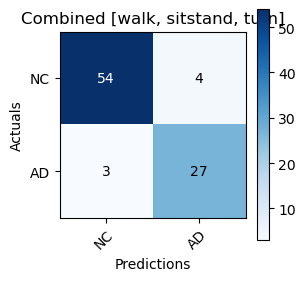

------------------------------ Seed_value=10, Combined [walk, sitstand, facial] ------------------------------
0) TN: 63, FP: 5, FN: 4, TP: 27
1) Accuracy: 90.91%
2) Sensitivity (Recall): 87.1%
3) Specificity: 92.65%
4) G-Mean: 89.83%
5) Precision: 84.38%
6) F1-Score: 0.86
7) F2-Measure: 0.87
8) Number of Subjects: 99



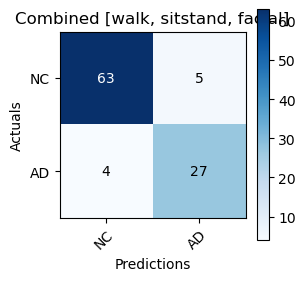

------------------------------ Seed_value=10, Combined [walk, turn, facial] ------------------------------
0) TN: 64, FP: 4, FN: 4, TP: 27
1) Accuracy: 91.92%
2) Sensitivity (Recall): 87.1%
3) Specificity: 94.12%
4) G-Mean: 90.54%
5) Precision: 87.1%
6) F1-Score: 0.87
7) F2-Measure: 0.87
8) Number of Subjects: 99



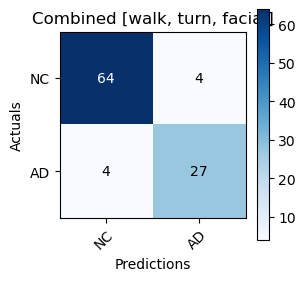

------------------------------ Seed_value=10, Combined [sitstand, turn, facial] ------------------------------
0) TN: 65, FP: 3, FN: 15, TP: 16
1) Accuracy: 81.82%
2) Sensitivity (Recall): 51.61%
3) Specificity: 95.59%
4) G-Mean: 70.24%
5) Precision: 84.21%
6) F1-Score: 0.64
7) F2-Measure: 0.56
8) Number of Subjects: 99



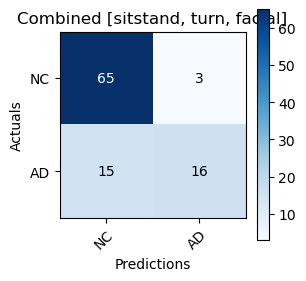

------------------------------ Seed_value=20, Combined [walk, sitstand, turn] ------------------------------
Combined [walk, sitstand, turn] pid 8 NOT exist.
Combined [walk, sitstand, turn] pid 14 NOT exist.
Combined [walk, sitstand, turn] pid 15 NOT exist.
Combined [walk, sitstand, turn] pid 23 NOT exist.
Combined [walk, sitstand, turn] pid 42 NOT exist.
Combined [walk, sitstand, turn] pid 47 NOT exist.
Combined [walk, sitstand, turn] pid 50 NOT exist.
Combined [walk, sitstand, turn] pid 53 NOT exist.
Combined [walk, sitstand, turn] pid 54 NOT exist.
Combined [walk, sitstand, turn] pid 55 NOT exist.
Combined [walk, sitstand, turn] pid 56 NOT exist.
0) TN: 55, FP: 3, FN: 2, TP: 28
1) Accuracy: 94.32%
2) Sensitivity (Recall): 93.33%
3) Specificity: 94.83%
4) G-Mean: 94.08%
5) Precision: 90.32%
6) F1-Score: 0.92
7) F2-Measure: 0.93
8) Number of Subjects: 88



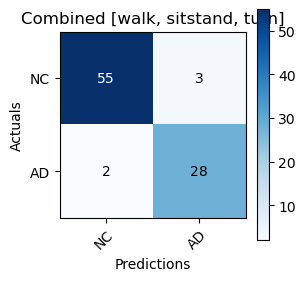

------------------------------ Seed_value=20, Combined [walk, sitstand, facial] ------------------------------
0) TN: 64, FP: 4, FN: 3, TP: 28
1) Accuracy: 92.93%
2) Sensitivity (Recall): 90.32%
3) Specificity: 94.12%
4) G-Mean: 92.2%
5) Precision: 87.5%
6) F1-Score: 0.89
7) F2-Measure: 0.9
8) Number of Subjects: 99



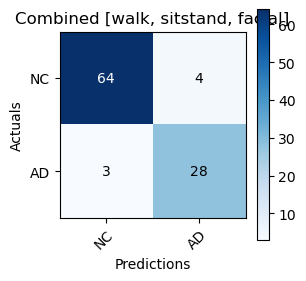

------------------------------ Seed_value=20, Combined [walk, turn, facial] ------------------------------
0) TN: 66, FP: 2, FN: 3, TP: 28
1) Accuracy: 94.95%
2) Sensitivity (Recall): 90.32%
3) Specificity: 97.06%
4) G-Mean: 93.63%
5) Precision: 93.33%
6) F1-Score: 0.92
7) F2-Measure: 0.91
8) Number of Subjects: 99



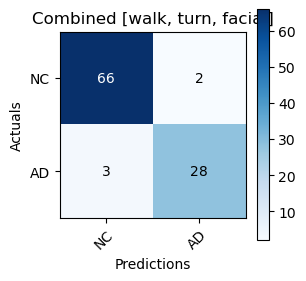

------------------------------ Seed_value=20, Combined [sitstand, turn, facial] ------------------------------
0) TN: 67, FP: 1, FN: 17, TP: 14
1) Accuracy: 81.82%
2) Sensitivity (Recall): 45.16%
3) Specificity: 98.53%
4) G-Mean: 66.71%
5) Precision: 93.33%
6) F1-Score: 0.61
7) F2-Measure: 0.5
8) Number of Subjects: 99



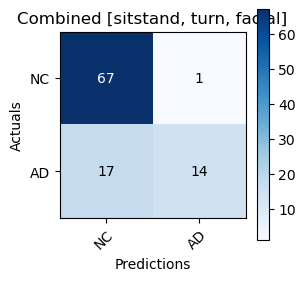

------------------------------ Seed_value=42, Combined [walk, sitstand, turn] ------------------------------
Combined [walk, sitstand, turn] pid 8 NOT exist.
Combined [walk, sitstand, turn] pid 14 NOT exist.
Combined [walk, sitstand, turn] pid 15 NOT exist.
Combined [walk, sitstand, turn] pid 23 NOT exist.
Combined [walk, sitstand, turn] pid 42 NOT exist.
Combined [walk, sitstand, turn] pid 47 NOT exist.
Combined [walk, sitstand, turn] pid 50 NOT exist.
Combined [walk, sitstand, turn] pid 53 NOT exist.
Combined [walk, sitstand, turn] pid 54 NOT exist.
Combined [walk, sitstand, turn] pid 55 NOT exist.
Combined [walk, sitstand, turn] pid 56 NOT exist.
0) TN: 55, FP: 3, FN: 3, TP: 27
1) Accuracy: 93.18%
2) Sensitivity (Recall): 90.0%
3) Specificity: 94.83%
4) G-Mean: 92.38%
5) Precision: 90.0%
6) F1-Score: 0.9
7) F2-Measure: 0.9
8) Number of Subjects: 88



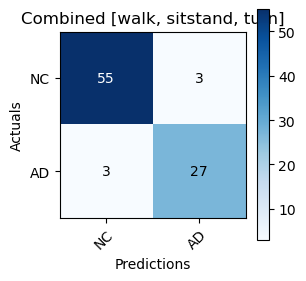

------------------------------ Seed_value=42, Combined [walk, sitstand, facial] ------------------------------
0) TN: 65, FP: 3, FN: 4, TP: 27
1) Accuracy: 92.93%
2) Sensitivity (Recall): 87.1%
3) Specificity: 95.59%
4) G-Mean: 91.25%
5) Precision: 90.0%
6) F1-Score: 0.89
7) F2-Measure: 0.88
8) Number of Subjects: 99



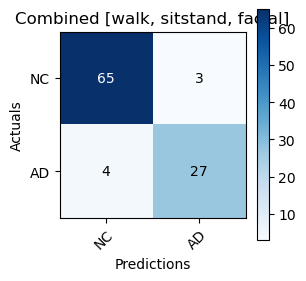

------------------------------ Seed_value=42, Combined [walk, turn, facial] ------------------------------
0) TN: 65, FP: 3, FN: 4, TP: 27
1) Accuracy: 92.93%
2) Sensitivity (Recall): 87.1%
3) Specificity: 95.59%
4) G-Mean: 91.25%
5) Precision: 90.0%
6) F1-Score: 0.89
7) F2-Measure: 0.88
8) Number of Subjects: 99



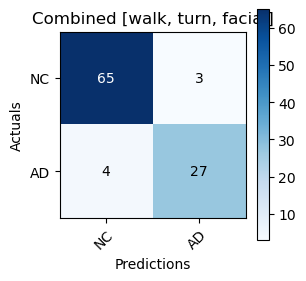

------------------------------ Seed_value=42, Combined [sitstand, turn, facial] ------------------------------
0) TN: 67, FP: 1, FN: 19, TP: 12
1) Accuracy: 79.8%
2) Sensitivity (Recall): 38.71%
3) Specificity: 98.53%
4) G-Mean: 61.76%
5) Precision: 92.31%
6) F1-Score: 0.55
7) F2-Measure: 0.44
8) Number of Subjects: 99



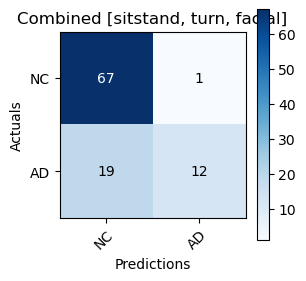

------------------------------ Seed_value=64, Combined [walk, sitstand, turn] ------------------------------
Combined [walk, sitstand, turn] pid 8 NOT exist.
Combined [walk, sitstand, turn] pid 14 NOT exist.
Combined [walk, sitstand, turn] pid 15 NOT exist.
Combined [walk, sitstand, turn] pid 23 NOT exist.
Combined [walk, sitstand, turn] pid 42 NOT exist.
Combined [walk, sitstand, turn] pid 47 NOT exist.
Combined [walk, sitstand, turn] pid 50 NOT exist.
Combined [walk, sitstand, turn] pid 53 NOT exist.
Combined [walk, sitstand, turn] pid 54 NOT exist.
Combined [walk, sitstand, turn] pid 55 NOT exist.
Combined [walk, sitstand, turn] pid 56 NOT exist.
0) TN: 54, FP: 4, FN: 3, TP: 27
1) Accuracy: 92.05%
2) Sensitivity (Recall): 90.0%
3) Specificity: 93.1%
4) G-Mean: 91.54%
5) Precision: 87.1%
6) F1-Score: 0.89
7) F2-Measure: 0.89
8) Number of Subjects: 88



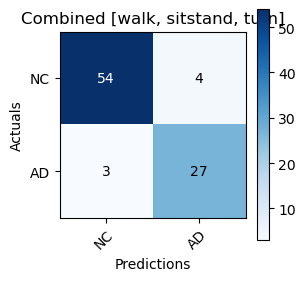

------------------------------ Seed_value=64, Combined [walk, sitstand, facial] ------------------------------
0) TN: 64, FP: 4, FN: 0, TP: 31
1) Accuracy: 95.96%
2) Sensitivity (Recall): 100.0%
3) Specificity: 94.12%
4) G-Mean: 97.02%
5) Precision: 88.57%
6) F1-Score: 0.94
7) F2-Measure: 0.97
8) Number of Subjects: 99



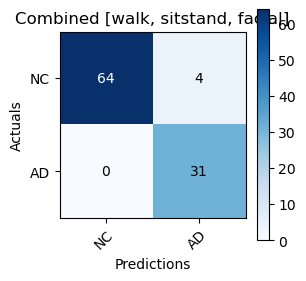

------------------------------ Seed_value=64, Combined [walk, turn, facial] ------------------------------
0) TN: 64, FP: 4, FN: 2, TP: 29
1) Accuracy: 93.94%
2) Sensitivity (Recall): 93.55%
3) Specificity: 94.12%
4) G-Mean: 93.83%
5) Precision: 87.88%
6) F1-Score: 0.91
7) F2-Measure: 0.92
8) Number of Subjects: 99



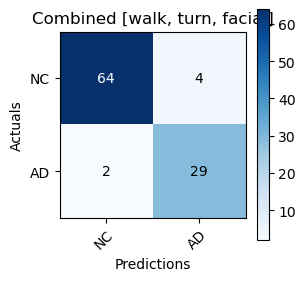

------------------------------ Seed_value=64, Combined [sitstand, turn, facial] ------------------------------
0) TN: 65, FP: 3, FN: 18, TP: 13
1) Accuracy: 78.79%
2) Sensitivity (Recall): 41.94%
3) Specificity: 95.59%
4) G-Mean: 63.32%
5) Precision: 81.25%
6) F1-Score: 0.55
7) F2-Measure: 0.46
8) Number of Subjects: 99



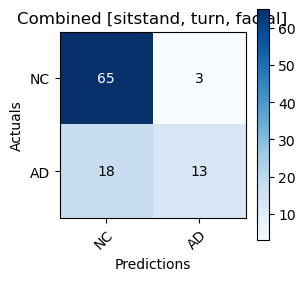

------------------------------ Seed_value=100, Combined [walk, sitstand, turn] ------------------------------
Combined [walk, sitstand, turn] pid 8 NOT exist.
Combined [walk, sitstand, turn] pid 14 NOT exist.
Combined [walk, sitstand, turn] pid 15 NOT exist.
Combined [walk, sitstand, turn] pid 23 NOT exist.
Combined [walk, sitstand, turn] pid 42 NOT exist.
Combined [walk, sitstand, turn] pid 47 NOT exist.
Combined [walk, sitstand, turn] pid 50 NOT exist.
Combined [walk, sitstand, turn] pid 53 NOT exist.
Combined [walk, sitstand, turn] pid 54 NOT exist.
Combined [walk, sitstand, turn] pid 55 NOT exist.
Combined [walk, sitstand, turn] pid 56 NOT exist.
0) TN: 55, FP: 3, FN: 2, TP: 28
1) Accuracy: 94.32%
2) Sensitivity (Recall): 93.33%
3) Specificity: 94.83%
4) G-Mean: 94.08%
5) Precision: 90.32%
6) F1-Score: 0.92
7) F2-Measure: 0.93
8) Number of Subjects: 88



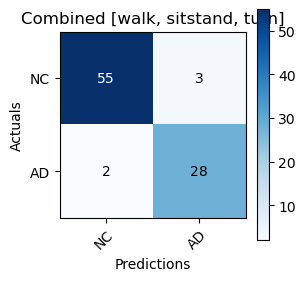

------------------------------ Seed_value=100, Combined [walk, sitstand, facial] ------------------------------
0) TN: 66, FP: 2, FN: 2, TP: 29
1) Accuracy: 95.96%
2) Sensitivity (Recall): 93.55%
3) Specificity: 97.06%
4) G-Mean: 95.29%
5) Precision: 93.55%
6) F1-Score: 0.94
7) F2-Measure: 0.94
8) Number of Subjects: 99



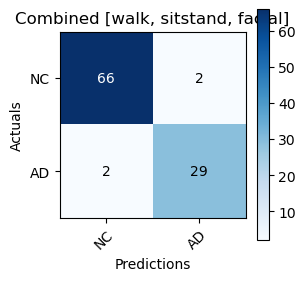

------------------------------ Seed_value=100, Combined [walk, turn, facial] ------------------------------
0) TN: 67, FP: 1, FN: 3, TP: 28
1) Accuracy: 95.96%
2) Sensitivity (Recall): 90.32%
3) Specificity: 98.53%
4) G-Mean: 94.34%
5) Precision: 96.55%
6) F1-Score: 0.93
7) F2-Measure: 0.92
8) Number of Subjects: 99



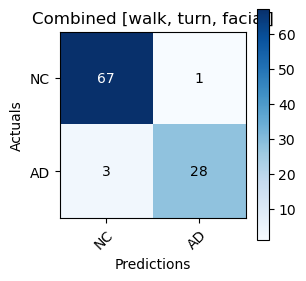

------------------------------ Seed_value=100, Combined [sitstand, turn, facial] ------------------------------
0) TN: 66, FP: 2, FN: 18, TP: 13
1) Accuracy: 79.8%
2) Sensitivity (Recall): 41.94%
3) Specificity: 97.06%
4) G-Mean: 63.8%
5) Precision: 86.67%
6) F1-Score: 0.57
7) F2-Measure: 0.47
8) Number of Subjects: 99



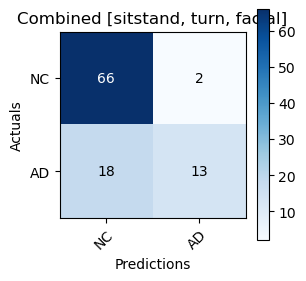

------------------------------ Seed_value=123, Combined [walk, sitstand, turn] ------------------------------
Combined [walk, sitstand, turn] pid 8 NOT exist.
Combined [walk, sitstand, turn] pid 14 NOT exist.
Combined [walk, sitstand, turn] pid 15 NOT exist.
Combined [walk, sitstand, turn] pid 23 NOT exist.
Combined [walk, sitstand, turn] pid 42 NOT exist.
Combined [walk, sitstand, turn] pid 47 NOT exist.
Combined [walk, sitstand, turn] pid 50 NOT exist.
Combined [walk, sitstand, turn] pid 53 NOT exist.
Combined [walk, sitstand, turn] pid 54 NOT exist.
Combined [walk, sitstand, turn] pid 55 NOT exist.
Combined [walk, sitstand, turn] pid 56 NOT exist.
0) TN: 54, FP: 4, FN: 2, TP: 28
1) Accuracy: 93.18%
2) Sensitivity (Recall): 93.33%
3) Specificity: 93.1%
4) G-Mean: 93.21%
5) Precision: 87.5%
6) F1-Score: 0.9
7) F2-Measure: 0.92
8) Number of Subjects: 88



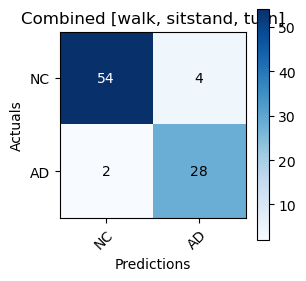

------------------------------ Seed_value=123, Combined [walk, sitstand, facial] ------------------------------
0) TN: 62, FP: 6, FN: 3, TP: 28
1) Accuracy: 90.91%
2) Sensitivity (Recall): 90.32%
3) Specificity: 91.18%
4) G-Mean: 90.75%
5) Precision: 82.35%
6) F1-Score: 0.86
7) F2-Measure: 0.89
8) Number of Subjects: 99



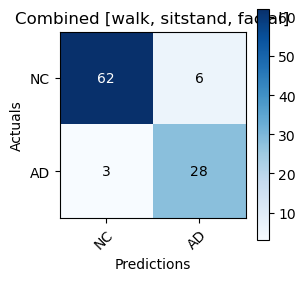

------------------------------ Seed_value=123, Combined [walk, turn, facial] ------------------------------
0) TN: 62, FP: 6, FN: 3, TP: 28
1) Accuracy: 90.91%
2) Sensitivity (Recall): 90.32%
3) Specificity: 91.18%
4) G-Mean: 90.75%
5) Precision: 82.35%
6) F1-Score: 0.86
7) F2-Measure: 0.89
8) Number of Subjects: 99



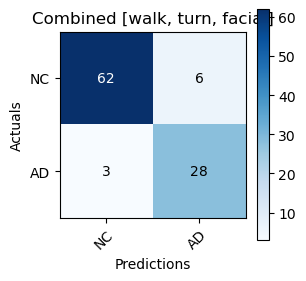

------------------------------ Seed_value=123, Combined [sitstand, turn, facial] ------------------------------
0) TN: 62, FP: 6, FN: 17, TP: 14
1) Accuracy: 76.77%
2) Sensitivity (Recall): 45.16%
3) Specificity: 91.18%
4) G-Mean: 64.17%
5) Precision: 70.0%
6) F1-Score: 0.55
7) F2-Measure: 0.49
8) Number of Subjects: 99



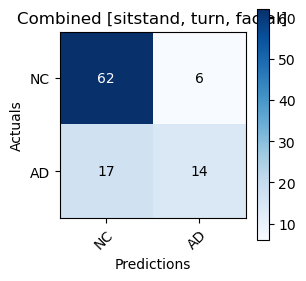

------------------------------ Seed_value=200, Combined [walk, sitstand, turn] ------------------------------
Combined [walk, sitstand, turn] pid 8 NOT exist.
Combined [walk, sitstand, turn] pid 14 NOT exist.
Combined [walk, sitstand, turn] pid 15 NOT exist.
Combined [walk, sitstand, turn] pid 23 NOT exist.
Combined [walk, sitstand, turn] pid 42 NOT exist.
Combined [walk, sitstand, turn] pid 47 NOT exist.
Combined [walk, sitstand, turn] pid 50 NOT exist.
Combined [walk, sitstand, turn] pid 53 NOT exist.
Combined [walk, sitstand, turn] pid 54 NOT exist.
Combined [walk, sitstand, turn] pid 55 NOT exist.
Combined [walk, sitstand, turn] pid 56 NOT exist.
0) TN: 52, FP: 6, FN: 3, TP: 27
1) Accuracy: 89.77%
2) Sensitivity (Recall): 90.0%
3) Specificity: 89.66%
4) G-Mean: 89.83%
5) Precision: 81.82%
6) F1-Score: 0.86
7) F2-Measure: 0.88
8) Number of Subjects: 88



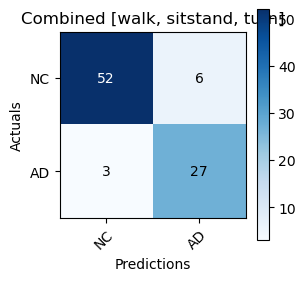

------------------------------ Seed_value=200, Combined [walk, sitstand, facial] ------------------------------
0) TN: 62, FP: 6, FN: 3, TP: 28
1) Accuracy: 90.91%
2) Sensitivity (Recall): 90.32%
3) Specificity: 91.18%
4) G-Mean: 90.75%
5) Precision: 82.35%
6) F1-Score: 0.86
7) F2-Measure: 0.89
8) Number of Subjects: 99



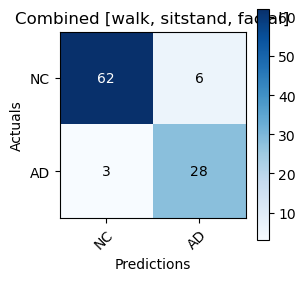

------------------------------ Seed_value=200, Combined [walk, turn, facial] ------------------------------
0) TN: 63, FP: 5, FN: 5, TP: 26
1) Accuracy: 89.9%
2) Sensitivity (Recall): 83.87%
3) Specificity: 92.65%
4) G-Mean: 88.15%
5) Precision: 83.87%
6) F1-Score: 0.84
7) F2-Measure: 0.84
8) Number of Subjects: 99



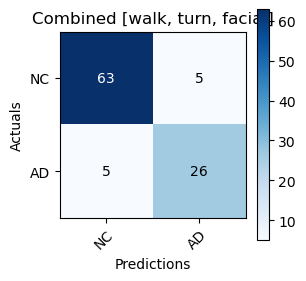

------------------------------ Seed_value=200, Combined [sitstand, turn, facial] ------------------------------
0) TN: 66, FP: 2, FN: 18, TP: 13
1) Accuracy: 79.8%
2) Sensitivity (Recall): 41.94%
3) Specificity: 97.06%
4) G-Mean: 63.8%
5) Precision: 86.67%
6) F1-Score: 0.57
7) F2-Measure: 0.47
8) Number of Subjects: 99



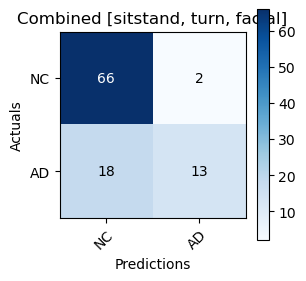

------------------------------ Seed_value=456, Combined [walk, sitstand, turn] ------------------------------
Combined [walk, sitstand, turn] pid 8 NOT exist.
Combined [walk, sitstand, turn] pid 14 NOT exist.
Combined [walk, sitstand, turn] pid 15 NOT exist.
Combined [walk, sitstand, turn] pid 23 NOT exist.
Combined [walk, sitstand, turn] pid 42 NOT exist.
Combined [walk, sitstand, turn] pid 47 NOT exist.
Combined [walk, sitstand, turn] pid 50 NOT exist.
Combined [walk, sitstand, turn] pid 53 NOT exist.
Combined [walk, sitstand, turn] pid 54 NOT exist.
Combined [walk, sitstand, turn] pid 55 NOT exist.
Combined [walk, sitstand, turn] pid 56 NOT exist.
0) TN: 54, FP: 4, FN: 3, TP: 27
1) Accuracy: 92.05%
2) Sensitivity (Recall): 90.0%
3) Specificity: 93.1%
4) G-Mean: 91.54%
5) Precision: 87.1%
6) F1-Score: 0.89
7) F2-Measure: 0.89
8) Number of Subjects: 88



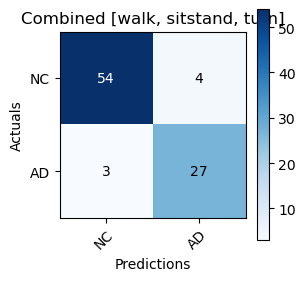

------------------------------ Seed_value=456, Combined [walk, sitstand, facial] ------------------------------
0) TN: 65, FP: 3, FN: 1, TP: 30
1) Accuracy: 95.96%
2) Sensitivity (Recall): 96.77%
3) Specificity: 95.59%
4) G-Mean: 96.18%
5) Precision: 90.91%
6) F1-Score: 0.94
7) F2-Measure: 0.96
8) Number of Subjects: 99



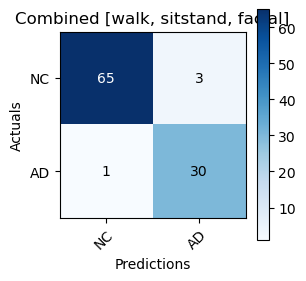

------------------------------ Seed_value=456, Combined [walk, turn, facial] ------------------------------
0) TN: 64, FP: 4, FN: 4, TP: 27
1) Accuracy: 91.92%
2) Sensitivity (Recall): 87.1%
3) Specificity: 94.12%
4) G-Mean: 90.54%
5) Precision: 87.1%
6) F1-Score: 0.87
7) F2-Measure: 0.87
8) Number of Subjects: 99



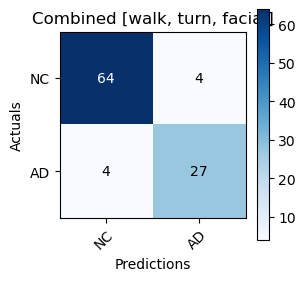

------------------------------ Seed_value=456, Combined [sitstand, turn, facial] ------------------------------
0) TN: 63, FP: 5, FN: 17, TP: 14
1) Accuracy: 77.78%
2) Sensitivity (Recall): 45.16%
3) Specificity: 92.65%
4) G-Mean: 64.68%
5) Precision: 73.68%
6) F1-Score: 0.56
7) F2-Measure: 0.49
8) Number of Subjects: 99



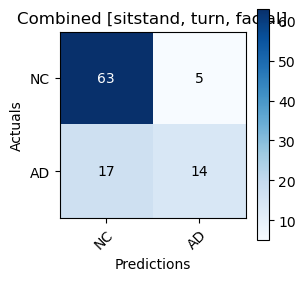

------------------------------ Seed_value=1001, Combined [walk, sitstand, turn] ------------------------------
Combined [walk, sitstand, turn] pid 8 NOT exist.
Combined [walk, sitstand, turn] pid 14 NOT exist.
Combined [walk, sitstand, turn] pid 15 NOT exist.
Combined [walk, sitstand, turn] pid 23 NOT exist.
Combined [walk, sitstand, turn] pid 42 NOT exist.
Combined [walk, sitstand, turn] pid 47 NOT exist.
Combined [walk, sitstand, turn] pid 50 NOT exist.
Combined [walk, sitstand, turn] pid 53 NOT exist.
Combined [walk, sitstand, turn] pid 54 NOT exist.
Combined [walk, sitstand, turn] pid 55 NOT exist.
Combined [walk, sitstand, turn] pid 56 NOT exist.
0) TN: 53, FP: 5, FN: 3, TP: 27
1) Accuracy: 90.91%
2) Sensitivity (Recall): 90.0%
3) Specificity: 91.38%
4) G-Mean: 90.69%
5) Precision: 84.38%
6) F1-Score: 0.87
7) F2-Measure: 0.89
8) Number of Subjects: 88



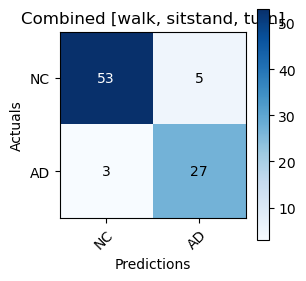

------------------------------ Seed_value=1001, Combined [walk, sitstand, facial] ------------------------------
0) TN: 62, FP: 6, FN: 2, TP: 29
1) Accuracy: 91.92%
2) Sensitivity (Recall): 93.55%
3) Specificity: 91.18%
4) G-Mean: 92.36%
5) Precision: 82.86%
6) F1-Score: 0.88
7) F2-Measure: 0.91
8) Number of Subjects: 99



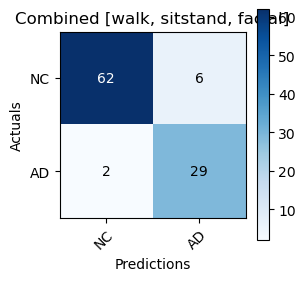

------------------------------ Seed_value=1001, Combined [walk, turn, facial] ------------------------------
0) TN: 63, FP: 5, FN: 3, TP: 28
1) Accuracy: 91.92%
2) Sensitivity (Recall): 90.32%
3) Specificity: 92.65%
4) G-Mean: 91.48%
5) Precision: 84.85%
6) F1-Score: 0.87
7) F2-Measure: 0.89
8) Number of Subjects: 99



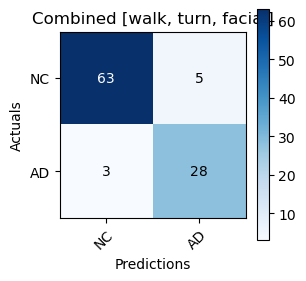

------------------------------ Seed_value=1001, Combined [sitstand, turn, facial] ------------------------------
0) TN: 63, FP: 5, FN: 15, TP: 16
1) Accuracy: 79.8%
2) Sensitivity (Recall): 51.61%
3) Specificity: 92.65%
4) G-Mean: 69.15%
5) Precision: 76.19%
6) F1-Score: 0.62
7) F2-Measure: 0.55
8) Number of Subjects: 99



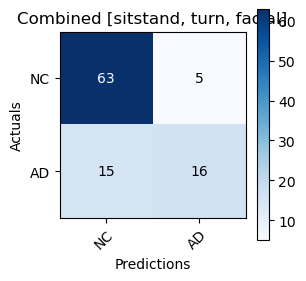

------------------------------ Seed_value=12321, Combined [walk, sitstand, turn] ------------------------------
Combined [walk, sitstand, turn] pid 8 NOT exist.
Combined [walk, sitstand, turn] pid 14 NOT exist.
Combined [walk, sitstand, turn] pid 15 NOT exist.
Combined [walk, sitstand, turn] pid 23 NOT exist.
Combined [walk, sitstand, turn] pid 42 NOT exist.
Combined [walk, sitstand, turn] pid 47 NOT exist.
Combined [walk, sitstand, turn] pid 50 NOT exist.
Combined [walk, sitstand, turn] pid 53 NOT exist.
Combined [walk, sitstand, turn] pid 54 NOT exist.
Combined [walk, sitstand, turn] pid 55 NOT exist.
Combined [walk, sitstand, turn] pid 56 NOT exist.
0) TN: 55, FP: 3, FN: 3, TP: 27
1) Accuracy: 93.18%
2) Sensitivity (Recall): 90.0%
3) Specificity: 94.83%
4) G-Mean: 92.38%
5) Precision: 90.0%
6) F1-Score: 0.9
7) F2-Measure: 0.9
8) Number of Subjects: 88



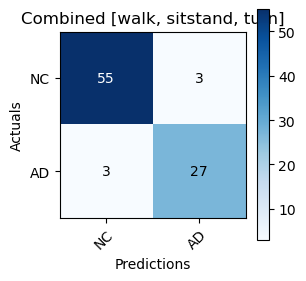

------------------------------ Seed_value=12321, Combined [walk, sitstand, facial] ------------------------------
0) TN: 64, FP: 4, FN: 3, TP: 28
1) Accuracy: 92.93%
2) Sensitivity (Recall): 90.32%
3) Specificity: 94.12%
4) G-Mean: 92.2%
5) Precision: 87.5%
6) F1-Score: 0.89
7) F2-Measure: 0.9
8) Number of Subjects: 99



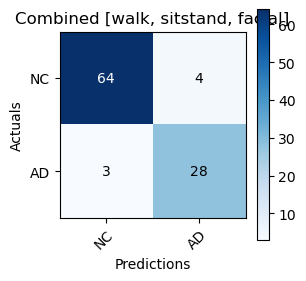

------------------------------ Seed_value=12321, Combined [walk, turn, facial] ------------------------------
0) TN: 64, FP: 4, FN: 5, TP: 26
1) Accuracy: 90.91%
2) Sensitivity (Recall): 83.87%
3) Specificity: 94.12%
4) G-Mean: 88.85%
5) Precision: 86.67%
6) F1-Score: 0.85
7) F2-Measure: 0.84
8) Number of Subjects: 99



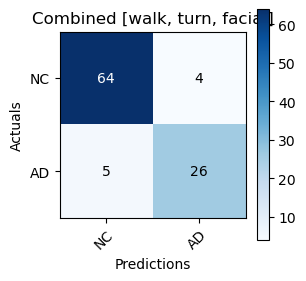

------------------------------ Seed_value=12321, Combined [sitstand, turn, facial] ------------------------------
0) TN: 65, FP: 3, FN: 20, TP: 11
1) Accuracy: 76.77%
2) Sensitivity (Recall): 35.48%
3) Specificity: 95.59%
4) G-Mean: 58.24%
5) Precision: 78.57%
6) F1-Score: 0.49
7) F2-Measure: 0.4
8) Number of Subjects: 99



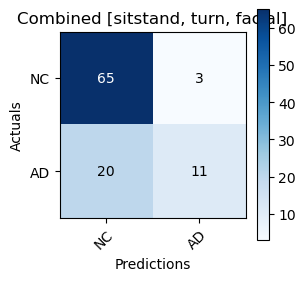

In [150]:
# threeSubtask_weighted_result_dict = combination_result_with_3_subtask(all_pid_list, subtask_combination, seed_value_list)
combination_result_with_3_subtask(all_pid_list, subtask_combination, seed_value_list)

In [151]:
print(f'Accuracy    ({len(WST_accuracy)}), mean({round(statistics.mean(WST_accuracy), 2)}), std({round(statistics.pstdev(WST_accuracy), 2)}): {WST_accuracy}')
print(f'Sensitivity ({len(WST_sensitivity)}), mean({round(statistics.mean(WST_sensitivity), 2)}), std({round(statistics.pstdev(WST_sensitivity), 2)}): {WST_sensitivity}')
print(f'Specificity ({len(WST_specificity)}), mean({round(statistics.mean(WST_specificity), 2)}), std({round(statistics.pstdev(WST_specificity), 2)}): {WST_specificity}')
print(f'Precision   ({len(WST_precision)}), mean({round(statistics.mean(WST_precision), 2)}), std({round(statistics.pstdev(WST_precision), 2)}): {WST_precision}')
print(f'F1-Score    ({len(WST_f1score)}), mean({round(statistics.mean(WST_f1score), 2)}), std({round(statistics.pstdev(WST_f1score), 2)}): {WST_f1score}')

Accuracy    (10), mean(92.5), std(1.36): [92.05, 94.32, 93.18, 92.05, 94.32, 93.18, 89.77, 92.05, 90.91, 93.18]
Sensitivity (10), mean(91.0), std(1.53): [90.0, 93.33, 90.0, 90.0, 93.33, 93.33, 90.0, 90.0, 90.0, 90.0]
Specificity (10), mean(93.28), std(1.63): [93.1, 94.83, 94.83, 93.1, 94.83, 93.1, 89.66, 93.1, 91.38, 94.83]
Precision   (10), mean(87.56), std(2.66): [87.1, 90.32, 90.0, 87.1, 90.32, 87.5, 81.82, 87.1, 84.38, 90.0]
F1-Score    (10), mean(0.89), std(0.02): [0.89, 0.92, 0.9, 0.89, 0.92, 0.9, 0.86, 0.89, 0.87, 0.9]


In [152]:
print(f'Accuracy    ({len(WSF_accuracy)}), mean({round(statistics.mean(WSF_accuracy), 2)}), std({round(statistics.pstdev(WSF_accuracy), 2)}): {WSF_accuracy}')
print(f'Sensitivity ({len(WSF_sensitivity)}), mean({round(statistics.mean(WSF_sensitivity), 2)}), std({round(statistics.pstdev(WSF_sensitivity), 2)}): {WSF_sensitivity}')
print(f'Specificity ({len(WSF_specificity)}), mean({round(statistics.mean(WSF_specificity), 2)}), std({round(statistics.pstdev(WSF_specificity), 2)}): {WSF_specificity}')
print(f'Precision   ({len(WSF_precision)}), mean({round(statistics.mean(WSF_precision), 2)}), std({round(statistics.pstdev(WSF_precision), 2)}): {WSF_precision}')
print(f'F1-Score    ({len(WSF_f1score)}), mean({round(statistics.mean(WSF_f1score), 2)}), std({round(statistics.pstdev(WSF_f1score), 2)}): {WSF_f1score}')

Accuracy    (10), mean(93.13), std(2.01): [90.91, 92.93, 92.93, 95.96, 95.96, 90.91, 90.91, 95.96, 91.92, 92.93]
Sensitivity (10), mean(91.94), std(3.88): [87.1, 90.32, 87.1, 100.0, 93.55, 90.32, 90.32, 96.77, 93.55, 90.32]
Specificity (10), mean(93.68), std(1.98): [92.65, 94.12, 95.59, 94.12, 97.06, 91.18, 91.18, 95.59, 91.18, 94.12]
Precision   (10), mean(87.0), std(3.71): [84.38, 87.5, 90.0, 88.57, 93.55, 82.35, 82.35, 90.91, 82.86, 87.5]
F1-Score    (10), mean(0.9), std(0.03): [0.86, 0.89, 0.89, 0.94, 0.94, 0.86, 0.86, 0.94, 0.88, 0.89]


In [153]:
print(f'Accuracy    ({len(WTF_accuracy)}), mean({round(statistics.mean(WTF_accuracy), 2)}), std({round(statistics.pstdev(WTF_accuracy), 2)}): {WTF_accuracy}')
print(f'Sensitivity ({len(WTF_sensitivity)}), mean({round(statistics.mean(WTF_sensitivity), 2)}), std({round(statistics.pstdev(WTF_sensitivity), 2)}): {WTF_sensitivity}')
print(f'Specificity ({len(WTF_specificity)}), mean({round(statistics.mean(WTF_specificity), 2)}), std({round(statistics.pstdev(WTF_specificity), 2)}): {WTF_specificity}')
print(f'Precision   ({len(WTF_precision)}), mean({round(statistics.mean(WTF_precision), 2)}), std({round(statistics.pstdev(WTF_precision), 2)}): {WTF_precision}')
print(f'F1-Score    ({len(WTF_f1score)}), mean({round(statistics.mean(WTF_f1score), 2)}), std({round(statistics.pstdev(WTF_f1score), 2)}): {WTF_f1score}')

Accuracy    (10), mean(92.53), std(1.82): [91.92, 94.95, 92.93, 93.94, 95.96, 90.91, 89.9, 91.92, 91.92, 90.91]
Sensitivity (10), mean(88.39), std(2.96): [87.1, 90.32, 87.1, 93.55, 90.32, 90.32, 83.87, 87.1, 90.32, 83.87]
Specificity (10), mean(94.41), std(2.06): [94.12, 97.06, 95.59, 94.12, 98.53, 91.18, 92.65, 94.12, 92.65, 94.12]
Precision   (10), mean(87.97), std(4.1): [87.1, 93.33, 90.0, 87.88, 96.55, 82.35, 83.87, 87.1, 84.85, 86.67]
F1-Score    (10), mean(0.88), std(0.03): [0.87, 0.92, 0.89, 0.91, 0.93, 0.86, 0.84, 0.87, 0.87, 0.85]


In [154]:
print(f'Accuracy    ({len(STF_accuracy)}), mean({round(statistics.mean(STF_accuracy), 2)}), std({round(statistics.pstdev(STF_accuracy), 2)}): {STF_accuracy}')
print(f'Sensitivity ({len(STF_sensitivity)}), mean({round(statistics.mean(STF_sensitivity), 2)}), std({round(statistics.pstdev(STF_sensitivity), 2)}): {STF_sensitivity}')
print(f'Specificity ({len(STF_specificity)}), mean({round(statistics.mean(STF_specificity), 2)}), std({round(statistics.pstdev(STF_specificity), 2)}): {STF_specificity}')
print(f'Precision   ({len(STF_precision)}), mean({round(statistics.mean(STF_precision), 2)}), std({round(statistics.pstdev(STF_precision), 2)}): {STF_precision}')
print(f'F1-Score    ({len(STF_f1score)}), mean({round(statistics.mean(STF_f1score), 2)}), std({round(statistics.pstdev(STF_f1score), 2)}): {STF_f1score}')

Accuracy    (10), mean(79.3), std(1.71): [81.82, 81.82, 79.8, 78.79, 79.8, 76.77, 79.8, 77.78, 79.8, 76.77]
Sensitivity (10), mean(43.87), std(4.83): [51.61, 45.16, 38.71, 41.94, 41.94, 45.16, 41.94, 45.16, 51.61, 35.48]
Specificity (10), mean(95.44), std(2.41): [95.59, 98.53, 98.53, 95.59, 97.06, 91.18, 97.06, 92.65, 92.65, 95.59]
Precision   (10), mean(82.29), std(7.36): [84.21, 93.33, 92.31, 81.25, 86.67, 70.0, 86.67, 73.68, 76.19, 78.57]
F1-Score    (10), mean(0.57), std(0.04): [0.64, 0.61, 0.55, 0.55, 0.57, 0.55, 0.57, 0.56, 0.62, 0.49]


### 4 Subtasks

In [155]:
WSTF_accuracy, WSTF_sensitivity, WSTF_specificity, WSTF_precision, WSTF_f1score = [], [], [], [], []


def show_weighted_result_with_confusion_matrix_RandomSeed_4tasks(pred_list, true_list):
    predict_label_array = np.array(pred_list)
    actual_label_array = np.array(true_list)

    ### F1-Score
    # print(f'==============  Classification Report  ==============')
    # print(classification_report(actual_label_array, predict_label_array))

    ### Confusion Matrix
    matrix = confusion_matrix(actual_label_array, predict_label_array)
    TN, FP, FN, TP = matrix.ravel()

    value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    value_sensitivity = round(TP/(TP+FN), 4)
    value_specificity = round(TN/(TN+FP), 4)
    value_gmean = round(np.sqrt(value_sensitivity*value_specificity), 4)
    value_precision = round(TP/(TP+FP), 4)
    value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
    value_f2_measure = round(5*value_precision*value_sensitivity / (4*value_precision+value_sensitivity), 2)

    # print(f'==================  Performance  ====================')
    print(f'0) TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    print(f'1) Accuracy: {round(value_accuracy*100, 2)}%')
    print(f'2) Sensitivity (Recall): {round(value_sensitivity*100, 2)}%')
    print(f'3) Specificity: {round(value_specificity*100, 2)}%')
    print(f'4) G-Mean: {round(value_gmean*100, 2)}%')
    print(f'5) Precision: {round(value_precision*100, 2)}%')
    print(f'6) F1-Score: {value_f1_score}')
    print(f'7) F2-Measure: {value_f2_measure}')
    print(f'8) Number of Subjects: {len(pred_list)}\n')
    
    classList = ['NC', 'AD']
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(3, 3), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title(f'Combined [W+S+T+F]', fontsize=12)
    plt.show()
    
    WSTF_accuracy.append(round(value_accuracy*100, 2))
    WSTF_sensitivity.append(round(value_sensitivity*100, 2))
    WSTF_specificity.append(round(value_specificity*100, 2))
    WSTF_precision.append(round(value_precision*100, 2))
    WSTF_f1score.append(value_f1_score)

In [156]:
def get_weighted_result_RandomSeed_4tasks(pidList, score1, score2, score3, score4, result1, result2, result3, result4, subtask_importance):
    lambda1 = score1
    lambda2 = score2
    lambda3 = score3
    lambda4 = score4

    tmp_result_dict = {}
    tmp_pred_list, tmp_true_list = [], []

    for pid in pidList:
        task1_probNC, task1_probAD = 0, 0
        task2_probNC, task2_probAD = 0, 0
        task3_probNC, task3_probAD = 0, 0
        task4_probNC, task4_probAD = 0, 0
        conf1, conf2, conf3, conf4 = 0, 0, 0, 0

        n_subtask = 0
        if pid in result1:
            n_subtask += 1
            task1_probNC = result1[pid]['prob_class0']
            task1_probAD = result1[pid]['prob_class1']
            actual_label = result1[pid]['actual']
            conf1 = subtask_importance[pid]['Walk']['conf']
        if pid in result2:
            n_subtask += 1
            task2_probNC = result2[pid]['prob_class0']
            task2_probAD = result2[pid]['prob_class1']
            actual_label = result2[pid]['actual']
            conf2 = subtask_importance[pid]['SitStand']['conf']
        if pid in result3:
            n_subtask += 1
            task3_probNC = result3[pid]['prob_class0']
            task3_probAD = result3[pid]['prob_class1']
            actual_label = result3[pid]['actual']
            conf3 = subtask_importance[pid]['Turn']['conf']
        if pid in result4:
            n_subtask += 1
            task4_probNC = result4[pid]['prob_class0']
            task4_probAD = result4[pid]['prob_class1']
            actual_label = result4[pid]['actual']
            conf4 = subtask_importance[pid]['Facial']['conf']

        if n_subtask==0:
            print(f'Combined [{task1}, {task2}, {task3}, {task4}] pid {pid} NOT exist.')
        else:
            probNC = (lambda1*conf1*task1_probNC + lambda2*conf2*task2_probNC + lambda3*conf3*task3_probNC + lambda4*conf4*task4_probNC)/n_subtask
            probAD = (lambda1*conf1*task1_probAD + lambda2*conf2*task2_probAD + lambda3*conf3*task3_probAD + lambda4*conf4*task4_probAD)/n_subtask
            
            if probAD >= probNC: pred_label = 1
            else: pred_label = 0
    
            tmp_result_dict[pid] = {}
            tmp_result_dict[pid]['probNC'] = probNC
            tmp_result_dict[pid]['probAD'] = probAD
            tmp_result_dict[pid]['prediction'] = pred_label
            tmp_result_dict[pid]['actual'] = actual_label
            
            tmp_pred_list.append(pred_label)
            tmp_true_list.append(actual_label)
    return tmp_pred_list, tmp_true_list, tmp_result_dict


def combination_result_RandomSeed_4tasks(pidList, seed_value_list):
    for idx, seed_value in enumerate(seed_value_list):
        w_f1score = walking_f1score_list[idx]
        s_f1score = sitstand_f1score_list[idx]
        t_f1score = f1_score_turn
        f_f1score = facial_f1score_list[idx]
        
        w_filename = "../1_GaitAnalysis_ver3_YOLO7_Training/Walking_RandomSeed_FS_0516_v2/Results/" + str(seed_value) + "_FS_weighted.csv"
        s_filename = "../1_GaitAnalysis_ver3_YOLO7_Training/SitAndStand_RandomSeed/Results/" + str(seed_value) + "_SitStand_combined.csv "
        t_filename = "../3_TurningSubtask/RandomSeed/" + str(seed_value) + "_Turning_Subtask.csv "
        f_filename = "../2_EyeTrackingAnalysis/Facial_RandomSeed_FS_0516_v2/Results/" + str(seed_value) + "_FS_weighted.csv "
        
        w_result_dict = create_walking_sitstand_facial_subtask_dictionary_RandomSeed(w_filename)
        s_result_dict = create_walking_sitstand_facial_subtask_dictionary_RandomSeed(s_filename)
        t_result_dict = create_turning_subtask_dictionary_RandomSeed(t_filename)
        f_result_dict = create_walking_sitstand_facial_subtask_dictionary_RandomSeed(f_filename)
        
        subtask_importance = {}
        subtask_importance = organize_subtask_importance_data_RandomSeed(pidList, w_f1score, s_f1score, t_f1score, f_f1score, w_result_dict, s_result_dict, t_result_dict, f_result_dict)
            

        print(f'------------------------------ Seed_value={seed_value}, Combined [W+S+T+F] ------------------------------')
        pred_list, true_list, weighted_result_dict = get_weighted_result_RandomSeed_4tasks(pidList, w_f1score, s_f1score, t_f1score, f_f1score, w_result_dict, s_result_dict, t_result_dict, f_result_dict, subtask_importance)
        show_weighted_result_with_confusion_matrix_RandomSeed_4tasks(pred_list, true_list)

------------------------------ Seed_value=10, Combined [W+S+T+F] ------------------------------
0) TN: 64, FP: 4, FN: 4, TP: 27
1) Accuracy: 91.92%
2) Sensitivity (Recall): 87.1%
3) Specificity: 94.12%
4) G-Mean: 90.54%
5) Precision: 87.1%
6) F1-Score: 0.87
7) F2-Measure: 0.87
8) Number of Subjects: 99



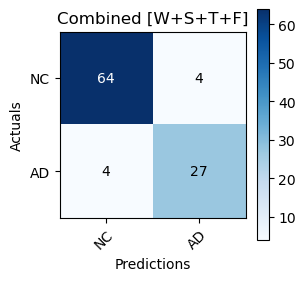

------------------------------ Seed_value=20, Combined [W+S+T+F] ------------------------------
0) TN: 66, FP: 2, FN: 3, TP: 28
1) Accuracy: 94.95%
2) Sensitivity (Recall): 90.32%
3) Specificity: 97.06%
4) G-Mean: 93.63%
5) Precision: 93.33%
6) F1-Score: 0.92
7) F2-Measure: 0.91
8) Number of Subjects: 99



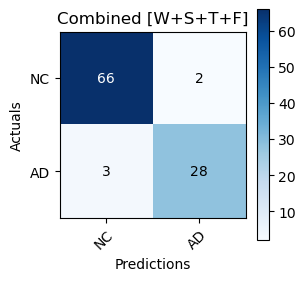

------------------------------ Seed_value=42, Combined [W+S+T+F] ------------------------------
0) TN: 65, FP: 3, FN: 4, TP: 27
1) Accuracy: 92.93%
2) Sensitivity (Recall): 87.1%
3) Specificity: 95.59%
4) G-Mean: 91.25%
5) Precision: 90.0%
6) F1-Score: 0.89
7) F2-Measure: 0.88
8) Number of Subjects: 99



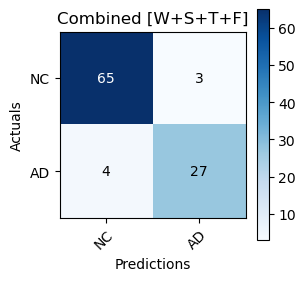

------------------------------ Seed_value=64, Combined [W+S+T+F] ------------------------------
0) TN: 65, FP: 3, FN: 3, TP: 28
1) Accuracy: 93.94%
2) Sensitivity (Recall): 90.32%
3) Specificity: 95.59%
4) G-Mean: 92.92%
5) Precision: 90.32%
6) F1-Score: 0.9
7) F2-Measure: 0.9
8) Number of Subjects: 99



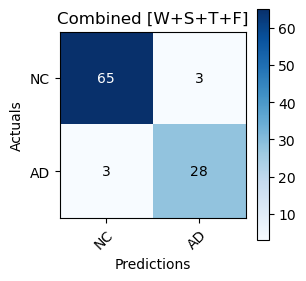

------------------------------ Seed_value=100, Combined [W+S+T+F] ------------------------------
0) TN: 67, FP: 1, FN: 4, TP: 27
1) Accuracy: 94.95%
2) Sensitivity (Recall): 87.1%
3) Specificity: 98.53%
4) G-Mean: 92.64%
5) Precision: 96.43%
6) F1-Score: 0.92
7) F2-Measure: 0.89
8) Number of Subjects: 99



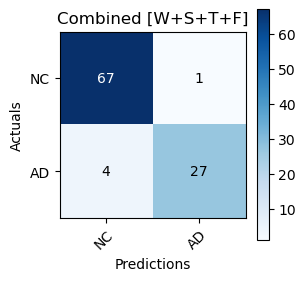

------------------------------ Seed_value=123, Combined [W+S+T+F] ------------------------------
0) TN: 63, FP: 5, FN: 3, TP: 28
1) Accuracy: 91.92%
2) Sensitivity (Recall): 90.32%
3) Specificity: 92.65%
4) G-Mean: 91.48%
5) Precision: 84.85%
6) F1-Score: 0.87
7) F2-Measure: 0.89
8) Number of Subjects: 99



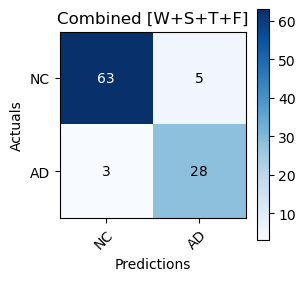

------------------------------ Seed_value=200, Combined [W+S+T+F] ------------------------------
0) TN: 63, FP: 5, FN: 5, TP: 26
1) Accuracy: 89.9%
2) Sensitivity (Recall): 83.87%
3) Specificity: 92.65%
4) G-Mean: 88.15%
5) Precision: 83.87%
6) F1-Score: 0.84
7) F2-Measure: 0.84
8) Number of Subjects: 99



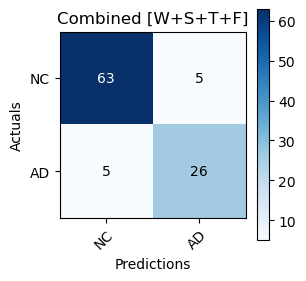

------------------------------ Seed_value=456, Combined [W+S+T+F] ------------------------------
0) TN: 64, FP: 4, FN: 4, TP: 27
1) Accuracy: 91.92%
2) Sensitivity (Recall): 87.1%
3) Specificity: 94.12%
4) G-Mean: 90.54%
5) Precision: 87.1%
6) F1-Score: 0.87
7) F2-Measure: 0.87
8) Number of Subjects: 99



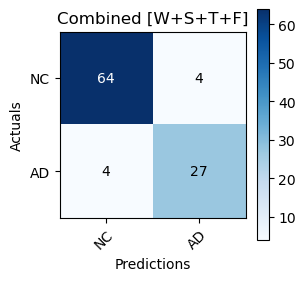

------------------------------ Seed_value=1001, Combined [W+S+T+F] ------------------------------
0) TN: 63, FP: 5, FN: 3, TP: 28
1) Accuracy: 91.92%
2) Sensitivity (Recall): 90.32%
3) Specificity: 92.65%
4) G-Mean: 91.48%
5) Precision: 84.85%
6) F1-Score: 0.87
7) F2-Measure: 0.89
8) Number of Subjects: 99



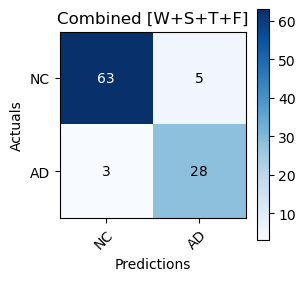

------------------------------ Seed_value=12321, Combined [W+S+T+F] ------------------------------
0) TN: 64, FP: 4, FN: 5, TP: 26
1) Accuracy: 90.91%
2) Sensitivity (Recall): 83.87%
3) Specificity: 94.12%
4) G-Mean: 88.85%
5) Precision: 86.67%
6) F1-Score: 0.85
7) F2-Measure: 0.84
8) Number of Subjects: 99



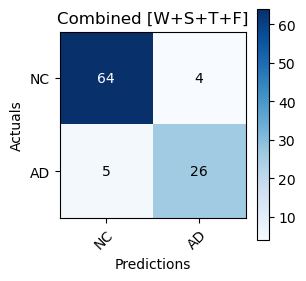

In [157]:
combination_result_RandomSeed_4tasks(all_pid_list, seed_value_list)

In [158]:
print(f'Accuracy    ({len(WSTF_accuracy)}), mean({round(statistics.mean(WSTF_accuracy), 2)}), std({round(statistics.pstdev(WSTF_accuracy), 2)}): {WSTF_accuracy}')
print(f'Sensitivity ({len(WSTF_sensitivity)}), mean({round(statistics.mean(WSTF_sensitivity), 2)}), std({round(statistics.pstdev(WSTF_sensitivity), 2)}): {WSTF_sensitivity}')
print(f'Specificity ({len(WSTF_specificity)}), mean({round(statistics.mean(WSTF_specificity), 2)}), std({round(statistics.pstdev(WSTF_specificity), 2)}): {WSTF_specificity}')
print(f'Precision   ({len(WSTF_precision)}), mean({round(statistics.mean(WSTF_precision), 2)}), std({round(statistics.pstdev(WSTF_precision), 2)}): {WSTF_precision}')
print(f'F1-Score    ({len(WSTF_f1score)}), mean({round(statistics.mean(WSTF_f1score), 2)}), std({round(statistics.pstdev(WSTF_f1score), 2)}): {WSTF_f1score}')

Accuracy    (10), mean(92.53), std(1.58): [91.92, 94.95, 92.93, 93.94, 94.95, 91.92, 89.9, 91.92, 91.92, 90.91]
Sensitivity (10), mean(87.74), std(2.41): [87.1, 90.32, 87.1, 90.32, 87.1, 90.32, 83.87, 87.1, 90.32, 83.87]
Specificity (10), mean(94.71), std(1.88): [94.12, 97.06, 95.59, 95.59, 98.53, 92.65, 92.65, 94.12, 92.65, 94.12]
Precision   (10), mean(88.45), std(3.84): [87.1, 93.33, 90.0, 90.32, 96.43, 84.85, 83.87, 87.1, 84.85, 86.67]
F1-Score    (10), mean(0.88), std(0.03): [0.87, 0.92, 0.89, 0.9, 0.92, 0.87, 0.84, 0.87, 0.87, 0.85]


# P-Value

In [34]:
len(df_raw['pid'].values)

99

In [35]:
### All Subjects ==============================================
tmp_df = df_raw.copy()
tmp_labelList = []
tmp_genderList = []
tmp_ageList = []
for idx in range(tmp_df.shape[0]):
    if tmp_df.iloc[idx][1]==0:
        tmp_genderList.append('Female')
    else:
        tmp_genderList.append('Male')
    if tmp_df.iloc[idx][3]==0:
        tmp_labelList.append('CN')
    else:
        tmp_labelList.append('AD')
    tmp_ageList.append(int(tmp_df.iloc[idx][2]))
        
tmp_data = {'gender': tmp_genderList, 'age': tmp_ageList, 'label': tmp_labelList}
new_df = pd.DataFrame(tmp_data)
new_df.head()
# table_all = TableOne(new_df, categorical=['gender'], min_max=['age'], groupby=['label'], nonnormal=['age'],
#                      pval=True, smd=True, htest_name=True)
table_all = TableOne(new_df, categorical=['gender'], groupby=['label'],
                     pval=True, smd=True, htest_name=True)
table_all

Grouped by label                                                                             
                               Missing      Overall          AD           CN P-Value               Test SMD (AD,CN)
n                                                99          31           68                                       
gender, n (%)  Female                0    64 (64.6)   17 (54.8)    47 (69.1)   0.249        Chi-squared       0.297
               Male                       35 (35.4)   14 (45.2)    21 (30.9)                                       
age, mean (SD)                       0  66.2 (16.5)  80.2 (6.4)  59.8 (15.8)  <0.001  Two Sample T-test      -1.689

In [36]:
table_all.to_latex('mytable.tex')

In [165]:
### Walking Subtask ===============================================
tmp_df = df_raw.copy()
tmp_labelList = []
tmp_genderList = []
tmp_ageList = []

df_selected = tmp_df[tmp_df['pid'].isin(walk_subtask_dict)]
print(df_selected.head())

for idx in range(df_selected.shape[0]):
    if df_selected.iloc[idx][1]==0:
        tmp_genderList.append('Female')
    else:
        tmp_genderList.append('Male')
    if df_selected.iloc[idx][3]==0:
        tmp_labelList.append('CN')
    else:
        tmp_labelList.append('AD')
    tmp_ageList.append(int(df_selected.iloc[idx][2]))
        
tmp_data = {'gender': tmp_genderList, 'age': tmp_ageList, 'label': tmp_labelList}
new_df = pd.DataFrame(tmp_data)
new_df.head()
table_walk = TableOne(new_df, categorical=['gender'], groupby=['label'], 
                      pval=True, smd=True, htest_name=True)
# table_walk = TableOne(new_df, categorical=['gender'], min_max=['age'], groupby=['label'], nonnormal=['age'], 
#                       pval=True, smd=True, htest_name=True)
table_walk

   pid  gender  age  _Label  _Pred_Walk  _Pred_SitStand  _Pred_Eye
0    1       0   40       0         0.0             0.0        0.0
1    2       1   28       0         0.0             0.0        0.0
2    3       0   29       0         0.0             0.0        0.0
3    4       0   71       1         0.0             0.0        0.0
4    5       0   75       0         0.0             0.0        0.0


Grouped by label                                                                             
                               Missing      Overall          AD           CN P-Value               Test SMD (AD,CN)
n                                                88          30           58                                       
gender, n (%)  Female                0    57 (64.8)   17 (56.7)    40 (69.0)   0.363        Chi-squared       0.257
               Male                       31 (35.2)   13 (43.3)    18 (31.0)                                       
age, mean (SD)                       0  67.6 (16.2)  79.9 (6.4)  61.2 (16.1)  <0.001  Two Sample T-test      -1.529

In [166]:
### SitStand Subtask ==============================================
tmp_df = df_raw.copy()
tmp_labelList = []
tmp_genderList = []
tmp_ageList = []

df_selected = tmp_df[tmp_df['pid'].isin(sitstand_subtask_dict)]
print(df_selected.head())

for idx in range(df_selected.shape[0]):
    if df_selected.iloc[idx][1]==0:
        tmp_genderList.append('Female')
    else:
        tmp_genderList.append('Male')
    if df_selected.iloc[idx][3]==0:
        tmp_labelList.append('CN')
    else:
        tmp_labelList.append('AD')
    tmp_ageList.append(int(df_selected.iloc[idx][2]))
        
tmp_data = {'gender': tmp_genderList, 'age': tmp_ageList, 'label': tmp_labelList}
new_df = pd.DataFrame(tmp_data)
new_df.head()
table_sitstand = TableOne(new_df, categorical=['gender'], groupby=['label'], 
                      pval=True, smd=True, htest_name=True)
# table_sitstand = TableOne(new_df, categorical=['gender'], min_max=['age'], groupby=['label'], nonnormal=['age'], 
#                       pval=True, smd=True, htest_name=True)
table_sitstand

   pid  gender  age  _Label  _Pred_Walk  _Pred_SitStand  _Pred_Eye
0    1       0   40       0         0.0             0.0        0.0
1    2       1   28       0         0.0             0.0        0.0
2    3       0   29       0         0.0             0.0        0.0
3    4       0   71       1         0.0             0.0        0.0
4    5       0   75       0         0.0             0.0        0.0


Grouped by label                                                                             
                               Missing      Overall          AD           CN P-Value               Test SMD (AD,CN)
n                                                88          30           58                                       
gender, n (%)  Female                0    57 (64.8)   17 (56.7)    40 (69.0)   0.363        Chi-squared       0.257
               Male                       31 (35.2)   13 (43.3)    18 (31.0)                                       
age, mean (SD)                       0  67.6 (16.2)  79.9 (6.4)  61.2 (16.1)  <0.001  Two Sample T-test      -1.529

In [167]:
### Turning Subtask ===============================================
tmp_df = df_raw.copy()
tmp_labelList = []
tmp_genderList = []
tmp_ageList = []

df_selected = tmp_df[tmp_df['pid'].isin(turn_subtask_dict)]
print(df_selected.head())

for idx in range(df_selected.shape[0]):
    if df_selected.iloc[idx][1]==0:
        tmp_genderList.append('Female')
    else:
        tmp_genderList.append('Male')
    if df_selected.iloc[idx][3]==0:
        tmp_labelList.append('CN')
    else:
        tmp_labelList.append('AD')
    tmp_ageList.append(int(df_selected.iloc[idx][2]))
        
tmp_data = {'gender': tmp_genderList, 'age': tmp_ageList, 'label': tmp_labelList}
new_df = pd.DataFrame(tmp_data)
new_df.head()
table_turn = TableOne(new_df, categorical=['gender'], groupby=['label'], 
                      pval=True, smd=True, htest_name=True)
# table_turn = TableOne(new_df, categorical=['gender'], min_max=['age'], groupby=['label'], nonnormal=['age'], 
#                       pval=True, smd=True, htest_name=True)
table_turn

   pid  gender  age  _Label  _Pred_Walk  _Pred_SitStand  _Pred_Eye
0    1       0   40       0         0.0             0.0        0.0
1    2       1   28       0         0.0             0.0        0.0
2    3       0   29       0         0.0             0.0        0.0
4    5       0   75       0         0.0             0.0        0.0
5    6       1   80       0         0.0             0.0        0.0


Grouped by label                                                                             
                               Missing      Overall          AD           CN P-Value               Test SMD (AD,CN)
n                                                83          26           57                                       
gender, n (%)  Female                0    53 (63.9)   14 (53.8)    39 (68.4)   0.300        Chi-squared       0.302
               Male                       30 (36.1)   12 (46.2)    18 (31.6)                                       
age, mean (SD)                       0  67.3 (16.1)  79.8 (6.2)  61.6 (16.0)  <0.001  Two Sample T-test      -1.504

In [168]:
### Facial Subtask ================================================
tmp_df = df_raw.copy()
tmp_labelList = []
tmp_genderList = []
tmp_ageList = []

df_selected = tmp_df[tmp_df['pid'].isin(facial_subtask_dict)]
print(df_selected.head())

for idx in range(df_selected.shape[0]):
    if df_selected.iloc[idx][1]==0:
        tmp_genderList.append('Female')
    else:
        tmp_genderList.append('Male')
    if df_selected.iloc[idx][3]==0:
        tmp_labelList.append('CN')
    else:
        tmp_labelList.append('AD')
    tmp_ageList.append(int(df_selected.iloc[idx][2]))
        
tmp_data = {'gender': tmp_genderList, 'age': tmp_ageList, 'label': tmp_labelList}
new_df = pd.DataFrame(tmp_data)
new_df.head()
table_facial = TableOne(new_df, categorical=['gender'], groupby=['label'], 
                       pval=True, smd=True, htest_name=True)
# table_facial = TableOne(new_df, categorical=['gender'], min_max=['age'], groupby=['label'], nonnormal=['age'], 
#                       pval=True, smd=True, htest_name=True)
table_facial

   pid  gender  age  _Label  _Pred_Walk  _Pred_SitStand  _Pred_Eye
0    1       0   40       0         0.0             0.0        0.0
1    2       1   28       0         0.0             0.0        0.0
2    3       0   29       0         0.0             0.0        0.0
3    4       0   71       1         0.0             0.0        0.0
4    5       0   75       0         0.0             0.0        0.0


Grouped by label                                                                             
                               Missing      Overall          AD           CN P-Value               Test SMD (AD,CN)
n                                                96          29           67                                       
gender, n (%)  Female                0    63 (65.6)   16 (55.2)    47 (70.1)   0.236        Chi-squared       0.313
               Male                       33 (34.4)   13 (44.8)    20 (29.9)                                       
age, mean (SD)                       0  65.8 (16.6)  79.9 (6.4)  59.7 (15.9)  <0.001  Two Sample T-test      -1.671

In [77]:
# def analysis_gender_distribution():
#     ### gender=0 : female, gender=1 : male
#     ### _Label=0 : NC, _Label=1 : AD
#     group_df = df_raw.value_counts(["gender", "_Label"]).reset_index().rename(columns={0:'count'})
#     print(f'{group_df}\n')

#     n_subjects = 0
#     for idx in group_df.index:
#         cnt = group_df.iloc[idx][2]
#         n_subjects += cnt

#     for idx in group_df.index:
#         gender = group_df.iloc[idx][0]
#         label = group_df.iloc[idx][1]
#         cnt = group_df.iloc[idx][2]
#         ratio = round(cnt/n_subjects*100, 4)
#         print(f'(Gender, Label)=({gender}, {label}) -> {cnt} subjects, ratio={ratio}%')

# def calculate_gender_pvalue(df):
#     ### ---------------- Method 1 ----------------
#     # X = df_raw[['gender']]
#     # y = df_raw['_Label']
#     # print(stats.levene(X['gender'][y == 0], X['gender'][y == 1]))
#     # t_stat, p_value = stats.ttest_ind(X['gender'][y == 0], X['gender'][y == 1])
#     # print(f'\np_value: {p_value}')

#     ### ---------------- Method 2 ----------------
#     df = df[['gender', '_Label']]
#     n_subjects, n_cols = df.shape[0], df.shape[1]

#     dataA, dataB = [], []
#     for idx in range(n_subjects):
#         gender = df.iloc[idx][0]
#         label = df.iloc[idx][1]
#         if label==0:
#             dataA.append(gender)
#         elif label==1:
#             dataB.append(gender)
#     t_stat, p_value = stats.ttest_ind(dataA, dataB)
#     print(f'\np_value: {p_value}')


# analysis_gender_distribution()
# calculate_gender_pvalue(df_raw)

In [78]:
# def analysis_age_distribution():
#     # group_df = df_raw.value_counts(["age"]).reset_index().rename(columns={0:'count'})
#     group_df = df_raw.value_counts(["age", "_Label"]).reset_index().rename(columns={0:'count'})
#     # print(group_df)
    
#     # plt.hist(group_df['age'], color='blue', edgecolor='black', bins=5)
#     # plt.title('Histogram of Age Distribution')
#     # plt.xlabel('Age')
#     # plt.ylabel('# of sunjects')

#     n_0to65, n_0to65_AD, n_0to65_NC = 0, 0, 0
#     n_65to80, n_65to80_AD, n_65to80_NC = 0, 0, 0
#     n_over80, n_over80_AD, n_over80_NC = 0, 0, 0
#     n_subjects = group_df['count'].sum()
#     for idx in group_df.index:
#         age = group_df.iloc[idx][0]
#         label = group_df.iloc[idx][1]
#         cnt = group_df.iloc[idx][2]
#         if age<65: 
#             n_0to65+=cnt
#             if label==0: n_0to65_NC += cnt
#             elif label==1: n_0to65_AD += cnt
#         elif age>=65 and age<80: 
#             n_65to80+=cnt
#             if label==0: n_65to80_NC += cnt
#             elif label==1: n_65to80_AD += cnt
#         elif age>=80: 
#             n_over80+=cnt
#             if label==0: n_over80_NC += cnt
#             elif label==1: n_over80_AD += cnt
                
#     print(f'Range (0~65):  {n_0to65} subjects, Ratio: {round(n_0to65/n_subjects*100, 4)}%, (AD, NC)=({n_0to65_AD}, {n_0to65_NC})')
#     print(f'Range (65~80): {n_65to80} subjects, Ratio: {round(n_65to80/n_subjects*100, 4)}%, (AD, NC)=({n_65to80_AD}, {n_65to80_NC})')
#     print(f'Range (80~ ):  {n_over80} subjects, Ratio: {round(n_over80/n_subjects*100, 4)}%, (AD, NC)=({n_over80_AD}, {n_over80_NC})')


# def calculate_age_pvalue(df):
#     ### ---------------- Method 1 ----------------
#     # X = df_raw[['age']]
#     # y = df_raw['_Label']
#     # print(stats.levene(X['age'][y == 0], X['age'][y == 1]))
#     # t_stat, p_value = stats.ttest_ind(X['age'][y==0], X['age'][y==1], equal_var=False)
#     # print(f'\np_value: {p_value}')
    
#     ### ---------------- Method 2 ----------------
#     df = df[['age', '_Label']]
#     n_subjects, n_cols = df.shape[0], df.shape[1]

#     dataA, dataB = [], []
#     for idx in range(n_subjects):
#         gender = df.iloc[idx][0]
#         label = df.iloc[idx][1]
#         if label==0:
#             dataA.append(gender)
#         elif label==1:
#             dataB.append(gender)
            
#     print(len(dataA), len(dataB))
#     t_stat, p_value = stats.ttest_ind(dataA, dataB)
#     print(f'\np_value: {p_value}')


# analysis_age_distribution()
# calculate_age_pvalue(df_raw)

# Correlation Matrix

In [39]:
def create_correlation_dataframe(df):
    pid_list, gender_list, age_list = [], [], []
    label_list, pred_list = [], []

    n_subjects = df.shape[0]
    for idx in range(n_subjects):
        pid = int(df.iloc[idx][0])
        gender = int(df.iloc[idx][1])
        age = int(df.iloc[idx][2])
        label = int(df.iloc[idx][3])
        
        pid_list.append(pid)
        gender_list.append(gender)
        age_list.append(age)
        label_list.append(label)

    for pid in pid_list:
        pred = combined_result_dict[pid]['prediction']
        pred_list.append(pred)

    data = {'gender': gender_list, 
            'age': age_list, 
            'prediction': pred_list, 
            'label': label_list}
    new_df = pd.DataFrame(data)
    return new_df


df_correlation = create_correlation_dataframe(df_raw)
df_correlation.head()

,gender,age,prediction,label
0,0,40,0,0
1,1,28,0,0
2,0,29,0,0
3,0,71,1,1
4,0,75,0,0


In [40]:
df_correlation.corr(method='pearson')

,gender,age,prediction,label
gender,1.000000,0.096230,0.138518,0.138518
age,0.096230,1.000000,0.484191,0.574215
prediction,0.138518,0.484191,1.000000,0.812144
label,0.138518,0.574215,0.812144,1.000000


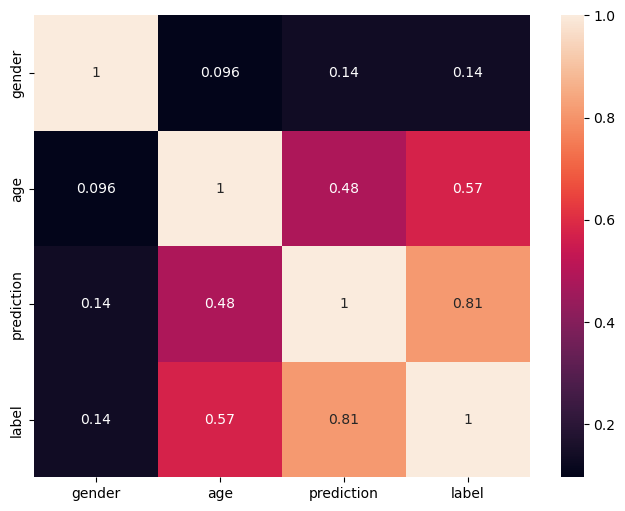

In [41]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_correlation.corr(), annot=True)
plt.show()

# ----- History -----

# Check Subtask Performance

### All Subtasks

In [10]:
df_walk = pd.read_csv(f'Training_Result/Walking_Subtask_val_threshold.csv')
df_sitstand = pd.read_csv(f'Training_Result/SitStand_Subtask_val_threshold_method1.csv') 
df_turn = pd.read_csv(f'Training_Result/Turning_Subtask_val_threshold.csv')
df_eye = pd.read_csv('Training_Result/Facial_Subtask_val_threshold.csv')

walk_subtask_dict = {}
sitstand_subtask_dict = {}
eye_subtask_dict = {}
turn_subtask_dict = {}

def create_walking_sitstand_facial_subtask_dictionary(data):
    tmp_dict = {}
    for i in range(data.shape[0]):
        pid = data.loc[i, 'pid']
        p_class1 = data.loc[i, 'avgProb'] ### probability for class 1 (AD)
        prediction = data.loc[i, 'prediction']
        actual = data.loc[i, 'actual']
        
        p_class0 = 1 - p_class1 ### probability for class 0 (NC)
        
        tmp_dict[pid] = {}
        tmp_dict[pid]['prob_class0'] = p_class0
        tmp_dict[pid]['prob_class1'] = p_class1
        tmp_dict[pid]['prediction'] = prediction
        tmp_dict[pid]['actual'] = actual
    return tmp_dict


def create_turning_subtask_dictionary(data):
    tmp_dict = {}
    for i in range(data.shape[0]):
        pid = data.loc[i, 'pid']
        p_class0 = data.loc[i, 'prob_NC']
        p_class1 = data.loc[i, 'prob_AD']
        prediction = data.loc[i, 'prediction']
        actual = data.loc[i, 'actual']
        
        tmp_dict[pid] = {}
        tmp_dict[pid]['prob_class0'] = p_class0
        tmp_dict[pid]['prob_class1'] = p_class1
        tmp_dict[pid]['prediction'] = prediction
        tmp_dict[pid]['actual'] = actual
    return tmp_dict


walk_subtask_dict = create_walking_sitstand_facial_subtask_dictionary(df_walk)
sitstand_subtask_dict = create_walking_sitstand_facial_subtask_dictionary(df_sitstand)
eye_subtask_dict = create_walking_sitstand_facial_subtask_dictionary(df_eye)
turn_subtask_dict = create_turning_subtask_dictionary(df_turn)

print(f'# of pid in [Walk Subtask]: {len(walk_subtask_dict)} subjects.')
print(f'# of pid in [Sit&Stand Subtask]: {len(sitstand_subtask_dict)} subjects.')
print(f'# of pid in [Eye Subtask]: {len(eye_subtask_dict)} subjects.')
print(f'# of pid in [Turning Subtask]: {len(turn_subtask_dict)} subjects.')

# of pid in [Walk Subtask]: 88 subjects.
# of pid in [Sit&Stand Subtask]: 88 subjects.
# of pid in [Eye Subtask]: 96 subjects.
# of pid in [Turning Subtask]: 83 subjects.


In [11]:
all_pid_list = []

def get_all_pid(walk, sitstand, eye, turn):
    tmp_list = []
    
    for i in range(walk.shape[0]):
        pid = walk.loc[i, 'pid']
        tmp_list.append(pid)
    for i in range(sitstand.shape[0]):
        pid = sitstand.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
            print(f'[add pid: Sit&Stand] pid: {pid}')
    for i in range(eye.shape[0]):
        pid = eye.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
            print(f'[add pid: Eye] pid: {pid}')
    for i in range(turn.shape[0]):
        pid = turn.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
            print(f'[add pid: Turning] pid: {pid}')
    
    return tmp_list


all_pid_list = get_all_pid(df_walk, df_sitstand, df_eye, df_turn)

print(f'\n# of valid pid: {len(all_pid_list)} subjects.\n')
print(all_pid_list)

[add pid: Eye] pid: 8
[add pid: Eye] pid: 14
[add pid: Eye] pid: 15
[add pid: Eye] pid: 23
[add pid: Eye] pid: 42
[add pid: Eye] pid: 47
[add pid: Eye] pid: 50
[add pid: Eye] pid: 53
[add pid: Eye] pid: 54
[add pid: Eye] pid: 55
[add pid: Eye] pid: 56

# of valid pid: 99 subjects.

[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 48, 49, 51, 52, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 8, 14, 15, 23, 42, 47, 50, 53, 54, 55, 56]


In [ ]:
all_subtasks_dict = {}

def combine_all_subtasks_dict(pidList):
    for pid in pidList:

        if pid in walk_subtask_dict:
            n_subtask += 1
            walk_p1 = walk_subtask_dict[pid]['prob_class0']
            walk_p2 = walk_subtask_dict[pid]['prob_class1']
            actual_label = walk_subtask_dict[pid]['actual']
        if pid in sitstand_subtask_dict:
            n_subtask += 1
            sitstand_p1 = sitstand_subtask_dict[pid]['prob_class0']
            sitstand_p2 = sitstand_subtask_dict[pid]['prob_class1']
            actual_label = sitstand_subtask_dict[pid]['actual']
        if pid in turn_subtask_dict:
            n_subtask += 1
            turn_p1 = turn_subtask_dict[pid]['prob_class0']
            turn_p2 = turn_subtask_dict[pid]['prob_class1']
            actual_label = turn_subtask_dict[pid]['actual']
        if pid in eye_subtask_dict:
            n_subtask += 1
            facial_p1 = eye_subtask_dict[pid]['prob_class0'] 
            facial_p2 = eye_subtask_dict[pid]['prob_class1'] 
            actual_label = eye_subtask_dict[pid]['actual']
        
        prob1 = (lambda_walk*walk_p1 + lambda_sitstand*sitstand_p1 + lambda_turn*turn_p1 + lambda_eye*facial_p1)/n_subtask
        prob2 = (lambda_walk*walk_p2 + lambda_sitstand*sitstand_p2 + lambda_turn*turn_p2 + lambda_eye*facial_p2)/n_subtask
        
        if prob2 >= prob1: pred_label = 1
        else: pred_label = 0

        result_dict[pid] = {}
        result_dict[pid]['prediction'] = pred_label
        result_dict[pid]['actual'] = actual_label
        
        tmp_pred_list.append(pred_label)
        tmp_true_list.append(actual_label)
        
    return tmp_pred_list, tmp_true_list
    
result_pred_list, result_true_list = combine_all_subtasks_dict(all_pid_list) 

### Turning Subtask

In [7]:
df_turn = pd.read_csv(f'Training_Result/Turning_Subtask_val_threshold.csv')

turn_subtask_dict = {}

def create_turning_subtask_dictionary(data):
    
    tmp_dict = {}
    for i in range(data.shape[0]):
        pid = data.loc[i, 'pid']
        p_class0 = data.loc[i, 'prob_NC']
        p_class1 = data.loc[i, 'prob_AD']
        prediction = data.loc[i, 'prediction']
        actual = data.loc[i, 'actual']
        
        tmp_dict[pid] = {}
        tmp_dict[pid]['prob_class0'] = p_class0
        tmp_dict[pid]['prob_class1'] = p_class1
        tmp_dict[pid]['prediction'] = prediction
        tmp_dict[pid]['actual'] = actual
    return tmp_dict

turn_subtask_dict = create_turning_subtask_dictionary(df_turn)

print(f'# of pid in [Turning Subtask]: {len(turn_subtask_dict)} subjects.')

# of pid in [Turning Subtask]: 83 subjects.


# Check correlation

In [10]:
remove_index_list = []
for i in range(n_row):
    tmp1 = df_raw.loc[i, "_Pred_Walk"]
    tmp2 = df_raw.loc[i, "_Pred_SitStand"]
    tmp3 = df_raw.loc[i, "_Pred_Eye"]
    # print(f'i: {i}, tmp1: {tmp1}, tmp2: {tmp2}, tmp3: {tmp3}')
    if tmp1=="x" or tmp2=="x" or tmp3=="x":
        remove_index_list.append(i)
        
df_correlation = df_raw.drop(labels=remove_index_list, axis=0)
df_correlation = df_correlation.astype({"_Pred_Walk": int, "_Pred_SitStand": int, "_Pred_Eye": int})

df_correlation.reset_index(drop=True, inplace=True)

print(f'n_row: {df_correlation.shape[0]}, n_col: {df_correlation.shape[1]}')

n_row: 74, n_col: 7


In [11]:
df_correlation.corr()

,pid,gender,age,_Label,_Pred_Walk,_Pred_SitStand,_Pred_Eye
pid,1.000000,-0.114575,-0.277610,-0.452961,-0.204077,-0.212175,-0.096442
gender,-0.114575,1.000000,0.038870,0.074553,-0.124494,0.111485,-0.059918
age,-0.277610,0.038870,1.000000,0.504154,0.287748,0.171982,0.004234
_Label,-0.452961,0.074553,0.504154,1.000000,0.370413,-0.006598,0.187530
_Pred_Walk,-0.204077,-0.124494,0.287748,0.370413,1.000000,0.035479,0.159140
_Pred_SitStand,-0.212175,0.111485,0.171982,-0.006598,0.035479,1.000000,-0.092803
_Pred_Eye,-0.096442,-0.059918,0.004234,0.187530,0.159140,-0.092803,1.000000


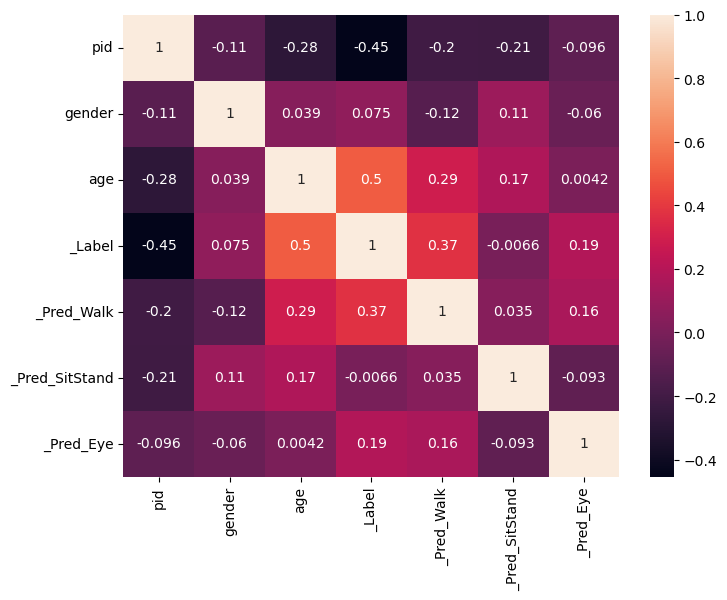

In [12]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(df_correlation.corr(), annot=True)
plt.show()

In [23]:
corr_matrix = df_correlation.corr()

print(corr_matrix['_Label'].sort_values(ascending=False))

_Label            1.000000
age               0.504154
_Pred_Walk        0.370413
_Pred_Eye         0.187530
gender            0.074553
_Pred_SitStand   -0.006598
pid              -0.452961
Name: _Label, dtype: float64


# Check Subtask Relationship

### Read CSV file
* Walking Subtask: 【walk_subtask_dict】
* Sit-and-Stand Subtask: 【sitstand_subtask_dict】
* Turning Subtask: 【turn_subtask_dict】
* Facial Subtask: 【eye_subtask_dict】

In [14]:
# df_walk = pd.read_csv('Training_Result/Walking_Subtask_val_threshold.csv') ### [update] 2023/09/21
df_walk = pd.read_csv('Training_Result/Walking_Subtask_val_threshold_240306.csv') ### [update] 2024/03/06

df_sitstand = pd.read_csv('Training_Result/SitStand_Subtask_val_threshold_method1.csv') ### [update] 2023/10/18

df_turn = pd.read_csv('Training_Result/Turning_Subtask_val_threshold.csv') ### [update] 2023/09/21

# df_eye = pd.read_csv('Training_Result/Facial_Subtask_val_threshold.csv') ### [update] 2023/09/21
df_eye = pd.read_csv('Training_Result/Facial_Subtask_val_threshold_0227.csv') ### [update] 2024/02/27

In [15]:
walk_subtask_dict = {}
sitstand_subtask_dict = {}
eye_subtask_dict = {}
turn_subtask_dict = {}

def create_walking_sitstand_facial_subtask_dictionary(data):
    tmp_dict = {}
    for i in range(data.shape[0]):
        pid = data.loc[i, 'pid']
        p_class1 = data.loc[i, 'avgProb'] ### probability for class 1 (AD)
        prediction = data.loc[i, 'prediction']
        actual = data.loc[i, 'actual']
        
        p_class0 = 1 - p_class1 ### probability for class 0 (NC)
        
        tmp_dict[pid] = {}
        tmp_dict[pid]['prob_class0'] = p_class0
        tmp_dict[pid]['prob_class1'] = p_class1
        tmp_dict[pid]['prediction'] = prediction
        tmp_dict[pid]['actual'] = actual
    return tmp_dict


def create_turning_subtask_dictionary(data):
    tmp_dict = {}
    for i in range(data.shape[0]):
        pid = data.loc[i, 'pid']
        p_class0 = data.loc[i, 'prob_NC']
        p_class1 = data.loc[i, 'prob_AD']
        prediction = data.loc[i, 'prediction']
        actual = data.loc[i, 'actual']
        
        tmp_dict[pid] = {}
        tmp_dict[pid]['prob_class0'] = p_class0
        tmp_dict[pid]['prob_class1'] = p_class1
        tmp_dict[pid]['prediction'] = prediction
        tmp_dict[pid]['actual'] = actual
    return tmp_dict


walk_subtask_dict = create_walking_sitstand_facial_subtask_dictionary(df_walk)
sitstand_subtask_dict = create_walking_sitstand_facial_subtask_dictionary(df_sitstand)
eye_subtask_dict = create_walking_sitstand_facial_subtask_dictionary(df_eye)
turn_subtask_dict = create_turning_subtask_dictionary(df_turn)

In [16]:
print(f'# of pid in [Walk Subtask]: {len(walk_subtask_dict)} subjects.')
print(f'# of pid in [Sit&Stand Subtask]: {len(sitstand_subtask_dict)} subjects.')
print(f'# of pid in [Eye Subtask]: {len(eye_subtask_dict)} subjects.')
print(f'# of pid in [Turning Subtask]: {len(turn_subtask_dict)} subjects.')

# of pid in [Walk Subtask]: 88 subjects.
# of pid in [Sit&Stand Subtask]: 88 subjects.
# of pid in [Eye Subtask]: 96 subjects.
# of pid in [Turning Subtask]: 83 subjects.


### Get all subjects pid
* 【all_pid_list】

In [17]:
all_pid_list = []

def get_all_pid(walk, sitstand, eye, turn):
    tmp_list = []
    
    for i in range(walk.shape[0]):
        pid = walk.loc[i, 'pid']
        tmp_list.append(pid)
    for i in range(sitstand.shape[0]):
        pid = sitstand.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
    for i in range(eye.shape[0]):
        pid = eye.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
    for i in range(turn.shape[0]):
        pid = turn.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
    
    return tmp_list


all_pid_list = get_all_pid(df_walk, df_sitstand, df_eye, df_turn)

print(f'# of valid pid: {len(all_pid_list)} subjects.\n')
print(f'all_pid_list:\n{all_pid_list}')

# of valid pid: 99 subjects.

all_pid_list:
[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 48, 49, 51, 52, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 8, 14, 15, 23, 42, 47, 50, 53, 54, 55, 56]


### Metrics of One/Single Subtask

In [18]:
turn_subtask_dict[1]

{'prob_class0': 0.9142, 'prob_class1': 0.0858, 'prediction': 0, 'actual': 0}

In [19]:
f1Score_Walking = 0
f1Score_SitStand = 0
f1Score_Facial = 0
f1Score_Turning = 0

def metrics_Single_Subtask(pidList, subtask):
    tmp_label_list = []
    tmp_pred_list = []
    
    if subtask == "Walking":
        for pid in pidList:
            if pid in walk_subtask_dict:
                label = walk_subtask_dict[pid]['actual']
                pred = walk_subtask_dict[pid]['prediction']
                tmp_label_list.append(label)
                tmp_pred_list.append(pred)
                
    elif subtask == "SitStand":
        for pid in pidList:
            if pid in sitstand_subtask_dict:
                label = sitstand_subtask_dict[pid]['actual']
                pred = sitstand_subtask_dict[pid]['prediction']
                tmp_label_list.append(label)
                tmp_pred_list.append(pred)
                
    elif subtask == "Facial":
        for pid in pidList:
            if pid in eye_subtask_dict:
                label = eye_subtask_dict[pid]['actual']
                pred = eye_subtask_dict[pid]['prediction']
                tmp_label_list.append(label)
                tmp_pred_list.append(pred)
                
    elif subtask == "Turning":
        for pid in pidList:
            if pid in turn_subtask_dict:
                label = turn_subtask_dict[pid]['actual']
                pred = turn_subtask_dict[pid]['prediction']
                tmp_label_list.append(label)
                tmp_pred_list.append(pred)
    else:
        print(f'[Notice] Something wrong with the flag. ---------------------------')

    tmp_label_array = np.array(tmp_label_list)
    tmp_pred_array = np.array(tmp_pred_list)

    ### F1-Score
    matrix = confusion_matrix(tmp_label_array, tmp_pred_array)
    TN, FP, FN, TP = matrix.ravel()

    accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    sensitivity = round(TP/(TP+FN), 4)
    specificity = round(TN/(TN+FP), 4)
    precision = round(TP/(TP+FP), 4)
    f1_score = round(2*precision*sensitivity/(precision+sensitivity), 2)
    gmean = round(np.sqrt(sensitivity*specificity), 4)

    print(f'---------- [{subtask} Subtask] ----------')
    print(f' 1) Accuracy:     {round(accuracy*100, 2)}%')
    print(f' 2) Sensitivity:  {round(sensitivity*100, 2)}%')
    print(f' 3) Specificity:  {round(specificity*100, 2)}%')
    print(f' 4) Precision:    {round(precision*100, 2)}%')
    print(f' 5) F1-Score:     {f1_score}')
    print(f' 6) G-Mean Score: {gmean}\n')
    
    return f1_score
    

f1Score_Walking = metrics_Single_Subtask(all_pid_list, "Walking")    
f1Score_SitStand = metrics_Single_Subtask(all_pid_list, "SitStand")
f1Score_Facial = metrics_Single_Subtask(all_pid_list, "Facial")
f1Score_Turning = metrics_Single_Subtask(all_pid_list, "Turning") 

---------- [Walking Subtask] ----------
 1) Accuracy:     67.05%
 2) Sensitivity:  73.33%
 3) Specificity:  63.79%
 4) Precision:    51.16%
 5) F1-Score:     0.6
 6) G-Mean Score: 0.6839

---------- [SitStand Subtask] ----------
 1) Accuracy:     59.09%
 2) Sensitivity:  50.0%
 3) Specificity:  63.79%
 4) Precision:    41.67%
 5) F1-Score:     0.45
 6) G-Mean Score: 0.5648

---------- [Facial Subtask] ----------
 1) Accuracy:     64.58%
 2) Sensitivity:  41.38%
 3) Specificity:  74.63%
 4) Precision:    41.38%
 5) F1-Score:     0.41
 6) G-Mean Score: 0.5557

---------- [Turning Subtask] ----------
 1) Accuracy:     81.93%
 2) Sensitivity:  69.23%
 3) Specificity:  87.72%
 4) Precision:    72.0%
 5) F1-Score:     0.71
 6) G-Mean Score: 0.7793



### Metrices of Combining Two Subtasks

In [20]:
def metrics_Two_Subtasks(pidList, t1, s1, t2, s2): ### t1: subtask1, s1: f1-score of subtask1
    lambda1 = s1*s1
    lambda2 = s2*s2
    
    tmp_pred_list, tmp_true_list = [], []
    t1_result_dict, t2_result_dict = {}, {}
    result_dict = {}
    
    if t1=="Turning": t1_result_dict = turn_subtask_dict
    elif t1=="Walking": t1_result_dict = walk_subtask_dict
    elif t1=="SitStand": t1_result_dict = sitstand_subtask_dict
    elif t1=="Facial": t1_result_dict = eye_subtask_dict
    else: print(f'[Notice] Something wrong with the flag t1 -----------------------')
    
    if t2=="Walking": t2_result_dict = walk_subtask_dict
    elif t2=="SitStand": t2_result_dict = sitstand_subtask_dict
    elif t2=="Turning": t2_result_dict = turn_subtask_dict
    elif t2=="Facial": t2_result_dict = eye_subtask_dict
    else: print(f'[Notice] Something wrong with the flag t2 -----------------------')
        
    
    for pid in pidList:
        t1_prob_NC, t1_prob_AD = 0, 0
        t2_prob_NC, t2_prob_AD = 0, 0
        t1_pred_label, t2_pred_label = 0, 0
        prob_NC, prob_AD = 0, 0
        pred_label, actual_label = 0, 0
        
        n_subtask = 0
        
        if pid in t1_result_dict:
            n_subtask += 1
            t1_prob_NC = t1_result_dict[pid]['prob_class0']
            t1_prob_AD = t1_result_dict[pid]['prob_class1']
            t1_pred_label = t1_result_dict[pid]['prediction']
            actual_label = t1_result_dict[pid]['actual']
        if pid in t2_result_dict:
            n_subtask += 1
            t2_prob_NC = t2_result_dict[pid]['prob_class0']
            t2_prob_AD = t2_result_dict[pid]['prob_class1']
            t2_pred_label = t2_result_dict[pid]['prediction']
            actual_label = t2_result_dict[pid]['actual']
        
        if n_subtask != 0:
            prob_NC = (lambda1*t1_prob_NC + lambda2*t2_prob_NC)/n_subtask
            prob_AD = (lambda1*t1_prob_AD + lambda2*t2_prob_AD)/n_subtask

            if prob_AD >= prob_NC: pred_label = 1
            else: pred_label = 0

            tmp_pred_list.append(pred_label)
            tmp_true_list.append(actual_label)
            
            result_dict[pid] = {}
            result_dict[pid][t1] = t1_pred_label
            result_dict[pid][t2] = t2_pred_label
            result_dict[pid]['actual'] = actual_label
            result_dict[pid]['prediction'] = pred_label
    
    ### Calculate F1-Score
    tmp_true_array = np.array(tmp_true_list)
    tmp_pred_array = np.array(tmp_pred_list)

    ### F1-Score
    matrix = confusion_matrix(tmp_true_array, tmp_pred_array)
    TN, FP, FN, TP = matrix.ravel()

    accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    sensitivity = round(TP/(TP+FN), 4)
    specificity = round(TN/(TN+FP), 4)
    precision = round(TP/(TP+FP), 4)
    f1_score = round(2*precision*sensitivity/(precision+sensitivity), 2)
    gmean = round(np.sqrt(sensitivity*specificity), 4)

    print(f'----------[{t1} + {t2}] ----------')
    print(f' 1) Accuracy:     {round(accuracy*100, 2)}%')
    print(f' 2) Sensitivity:  {round(sensitivity*100, 2)}%')
    print(f' 3) Specificity:  {round(specificity*100, 2)}%')
    print(f' 4) Precision:    {round(precision*100, 2)}%')
    print(f' 5) F1-Score:     {f1_score}')
    print(f' 6) G-Mean Score: {gmean}\n')

    return result_dict
    
    
result_dict1 = metrics_Two_Subtasks(all_pid_list, "Turning", f1Score_Turning, "Walking", f1Score_Walking)
result_dict2 = metrics_Two_Subtasks(all_pid_list, "Turning", f1Score_Turning, "SitStand", f1Score_SitStand)
result_dict3 = metrics_Two_Subtasks(all_pid_list, "Turning", f1Score_Turning, "Facial", f1Score_Facial)

print(f'result_dict1[1]: {result_dict1[1]}')

----------[Turning + Walking] ----------
 1) Accuracy:     77.27%
 2) Sensitivity:  56.67%
 3) Specificity:  87.93%
 4) Precision:    70.83%
 5) F1-Score:     0.63
 6) G-Mean Score: 0.7059

----------[Turning + SitStand] ----------
 1) Accuracy:     76.14%
 2) Sensitivity:  46.67%
 3) Specificity:  91.38%
 4) Precision:    73.68%
 5) F1-Score:     0.57
 6) G-Mean Score: 0.653

----------[Turning + Facial] ----------
 1) Accuracy:     77.55%
 2) Sensitivity:  43.33%
 3) Specificity:  92.65%
 4) Precision:    72.22%
 5) F1-Score:     0.54
 6) G-Mean Score: 0.6336

result_dict1[1]: {'Turning': 0, 'Walking': 1, 'actual': 0, 'prediction': 0}


In [24]:
def check_prediction_change(result_dict, base_dict, add_dict, t1, t2):
    nb_t1_NC, nb_t1_AD = 0, 0
    
    print(f'--------------------------- {t1} Subtask + {t2} Subtask---------------------------')
    for pid in result_dict:
        if pid in base_dict:
            original = result_dict[pid][t1]
            new = result_dict[pid]['prediction']
            if original != new:
                print(f'[pid {pid}] Label Changed: {original} -> {new}, Actual Label: {result_dict[pid]["actual"]}')
            
            if new==0: nb_t1_NC += 1
            elif new==1: nb_t1_AD += 1
                
    for pid in result_dict:
        if pid not in base_dict:
            pred = result_dict[pid]['prediction']
            actual = result_dict[pid]['actual']
            print(f'[Add pid {pid} from {t2} Subtask] Prediction: {pred}, Actual: {actual}')
    
    print(f'\nNew predicted result...')
    print(f'# of NC pid: {nb_t1_NC}')
    print(f'# of AD pid: {nb_t1_AD}\n')

check_prediction_change(result_dict1, turn_subtask_dict, walk_subtask_dict, "Turning", "Walking") ### Turning + Walking
check_prediction_change(result_dict2, turn_subtask_dict, sitstand_subtask_dict, "Turning", "SitStand") ### Turning + SitStand
check_prediction_change(result_dict3, turn_subtask_dict, eye_subtask_dict, "Turning", "Facial") ### Turning + Facial


--------------------------- Turning Subtask + Walking Subtask---------------------------
[pid 17] Label Changed: 1 -> 0, Actual Label: 1
[pid 24] Label Changed: 1 -> 0, Actual Label: 1
[pid 28] Label Changed: 1 -> 0, Actual Label: 1
[pid 29] Label Changed: 0 -> 1, Actual Label: 0
[pid 39] Label Changed: 1 -> 0, Actual Label: 1
[pid 51] Label Changed: 1 -> 0, Actual Label: 0
[pid 85] Label Changed: 1 -> 0, Actual Label: 0
[Add pid 4 from Walking Subtask] Prediction: 1, Actual: 1
[Add pid 7 from Walking Subtask] Prediction: 0, Actual: 0
[Add pid 9 from Walking Subtask] Prediction: 1, Actual: 1
[Add pid 32 from Walking Subtask] Prediction: 1, Actual: 1
[Add pid 60 from Walking Subtask] Prediction: 1, Actual: 1

New predicted result...
# of NC pid: 63
# of AD pid: 20

--------------------------- Turning Subtask + SitStand Subtask---------------------------
[pid 17] Label Changed: 1 -> 0, Actual Label: 1
[pid 24] Label Changed: 1 -> 0, Actual Label: 1
[pid 28] Label Changed: 1 -> 0, Actual 

# Table Info

### Read CSV file
* Walking Subtask: 【walk_subtask_dict】
* Sit-and-Stand Subtask: 【sitstand_subtask_dict】
* Turning Subtask: 【turn_subtask_dict】
* Facial Subtask: 【eye_subtask_dict】

In [22]:
df_walk = pd.read_csv('Training_Result/Walking_Subtask_val_threshold.csv') ### [update] 2023/09/21
df_sitstand = pd.read_csv('Training_Result/SitStand_Subtask_val_threshold_method1.csv') ### [update] 2023/10/18
df_turn = pd.read_csv('Training_Result/Turning_Subtask_val_threshold.csv') ### [update] 2023/09/21
# df_eye = pd.read_csv('Training_Result/Facial_Subtask_val_threshold.csv') ### [update] 2023/09/21
df_eye = pd.read_csv('Training_Result/Facial_Subtask_val_threshold_0227.csv') ### [update] 2024/02/27

In [23]:
walk_subtask_dict = {}
sitstand_subtask_dict = {}
eye_subtask_dict = {}
turn_subtask_dict = {}

def create_walking_sitstand_facial_subtask_dictionary(data):
    tmp_dict = {}
    for i in range(data.shape[0]):
        pid = data.loc[i, 'pid']
        p_class1 = data.loc[i, 'avgProb'] ### probability for class 1 (AD)
        prediction = data.loc[i, 'prediction']
        actual = data.loc[i, 'actual']
        
        p_class0 = 1 - p_class1 ### probability for class 0 (NC)
        
        tmp_dict[pid] = {}
        tmp_dict[pid]['prob_class0'] = p_class0
        tmp_dict[pid]['prob_class1'] = p_class1
        tmp_dict[pid]['prediction'] = prediction
        tmp_dict[pid]['actual'] = actual
    return tmp_dict


def create_turning_subtask_dictionary(data):
    tmp_dict = {}
    for i in range(data.shape[0]):
        pid = data.loc[i, 'pid']
        p_class0 = data.loc[i, 'prob_NC']
        p_class1 = data.loc[i, 'prob_AD']
        prediction = data.loc[i, 'prediction']
        actual = data.loc[i, 'actual']
        
        tmp_dict[pid] = {}
        tmp_dict[pid]['prob_class0'] = p_class0
        tmp_dict[pid]['prob_class1'] = p_class1
        tmp_dict[pid]['prediction'] = prediction
        tmp_dict[pid]['actual'] = actual
    return tmp_dict


walk_subtask_dict = create_walking_sitstand_facial_subtask_dictionary(df_walk)
sitstand_subtask_dict = create_walking_sitstand_facial_subtask_dictionary(df_sitstand)
eye_subtask_dict = create_walking_sitstand_facial_subtask_dictionary(df_eye)
turn_subtask_dict = create_turning_subtask_dictionary(df_turn)

In [24]:
print(f'# of pid in [Walk Subtask]: {len(walk_subtask_dict)} subjects.')
print(f'# of pid in [Sit&Stand Subtask]: {len(sitstand_subtask_dict)} subjects.')
print(f'# of pid in [Eye Subtask]: {len(eye_subtask_dict)} subjects.')
print(f'# of pid in [Turning Subtask]: {len(turn_subtask_dict)} subjects.')

# of pid in [Walk Subtask]: 88 subjects.
# of pid in [Sit&Stand Subtask]: 88 subjects.
# of pid in [Eye Subtask]: 96 subjects.
# of pid in [Turning Subtask]: 83 subjects.


### Get all subjects pid
* 【all_pid_list】

In [25]:
all_pid_list = []

def get_all_pid(walk, sitstand, eye, turn):
    tmp_list = []
    
    for i in range(walk.shape[0]):
        pid = walk.loc[i, 'pid']
        tmp_list.append(pid)
    for i in range(sitstand.shape[0]):
        pid = sitstand.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
    for i in range(eye.shape[0]):
        pid = eye.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
    for i in range(turn.shape[0]):
        pid = turn.loc[i, 'pid']
        if (pid in tmp_list) == False:
            tmp_list.append(pid)
    
    return tmp_list


all_pid_list = get_all_pid(df_walk, df_sitstand, df_eye, df_turn)

print(f'# of valid pid: {len(all_pid_list)} subjects.\n')
print(f'all_pid_list:\n{all_pid_list}')

# of valid pid: 99 subjects.

all_pid_list:
[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 48, 49, 51, 52, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 8, 14, 15, 23, 42, 47, 50, 53, 54, 55, 56]


### Analyze Table info
* 每個subtask分別有多少人的資料
* Each subtask true/predict: ?AD + ?NC

In [26]:
walking_info = [30, 58, 52, 36]
sitting_info = [30, 58, 44, 44]
turning_info = [26, 57, 25, 58]
facial_info  = [29, 67, 29, 67]

df_table = pd.DataFrame([walking_info, sitting_info, turning_info, facial_info],
                        index=pd.Index(['Walking Subtask', 'SitStand Subtask', 'Turning Subtask', 'Facial Subtask']),
                        columns=pd.MultiIndex.from_product([['Actual Label', 'Predicted Label'],['AD', 'NC']]))

nb_pid_list = [88, 88, 83, 96]
f1score_list = [0.66, 0.49, 0.71, 0.41]

df_table.insert(0, "# of subjects", nb_pid_list, True)
df_table.insert(5, "F1-Score", f1score_list, True)
df_table

# of subjects Actual Label     Predicted Label     F1-Score
                                         AD  NC              AD  NC         
Walking Subtask             88           30  58              52  36     0.66
SitStand Subtask            88           30  58              44  44     0.49
Turning Subtask             83           26  57              25  58     0.71
Facial Subtask              96           29  67              29  67     0.41